In [42]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
import xarray as xr
warnings.filterwarnings('ignore')

In [43]:
#load train, validation, and test datasets for all cities
#train datasets
abuja_train = pd.read_csv(r'Datasets\Train_Valid_Test\Abuja_train_imp.csv')
lagos_train = pd.read_csv(r'Datasets\Train_Valid_Test\Lagos_train_imp.csv')
chennai_train = pd.read_csv(r'Datasets\Train_Valid_Test\Chennai_train_imp.csv')
newdelhi_train = pd.read_csv(r'Datasets\Train_Valid_Test\NewDelhi_train_imp.csv')

#validation datasets
abuja_valid = pd.read_csv(r'Datasets\Train_Valid_Test\Abuja_valid_imp.csv')
lagos_valid = pd.read_csv(r'Datasets\Train_Valid_Test\Lagos_valid_imp.csv')
chennai_valid = pd.read_csv(r'Datasets\Train_Valid_Test\Chennai_valid_imp.csv')
newdelhi_valid = pd.read_csv(r'Datasets\Train_Valid_Test\NewDelhi_valid_imp.csv')

#test datasets
abuja_test = pd.read_csv(r'Datasets\Train_Valid_Test\Abuja_test_imp.csv')
lagos_test = pd.read_csv(r'Datasets\Train_Valid_Test\Lagos_test_imp.csv')
chennai_test = pd.read_csv(r'Datasets\Train_Valid_Test\Chennai_test_imp.csv')
newdelhi_test = pd.read_csv(r'Datasets\Train_Valid_Test\NewDelhi_test_imp.csv')




In [44]:
#load raw data for all cities
abuja_raw = pd.read_csv(r'Datasets\Train_Valid_Test\Abuja_train_raw_flagged.csv')
lagos_raw = pd.read_csv(r'Datasets\Train_Valid_Test\Lagos_train_raw_flagged.csv')
chennai_raw = pd.read_csv(r'Datasets\Train_Valid_Test\Chennai_train_raw_flagged.csv')
newdelhi_raw = pd.read_csv(r'Datasets\Train_Valid_Test\NewDelhi_train_raw_flagged.csv') 

#validation raw data
abuja_valid_raw = pd.read_csv(r'Datasets\Train_Valid_Test\Abuja_valid_raw_flagged.csv')
lagos_valid_raw = pd.read_csv(r'Datasets\Train_Valid_Test\Lagos_valid_raw_flagged.csv')
chennai_valid_raw = pd.read_csv(r'Datasets\Train_Valid_Test\Chennai_valid_raw_flagged .csv')
newdelhi_valid_raw = pd.read_csv(r'Datasets\Train_Valid_Test\NewDelhi_valid_raw_flagged.csv')

#test raw data
abuja_test_raw = pd.read_csv(r'Datasets\Train_Valid_Test\Abuja_test_raw_flagged.csv')
lagos_test_raw = pd.read_csv(r'Datasets\Train_Valid_Test\Lagos_test_raw_flagged.csv')
chennai_test_raw = pd.read_csv(r'Datasets\Train_Valid_Test\Chennai_test_raw_flagged.csv')
newdelhi_test_raw = pd.read_csv(r'Datasets\Train_Valid_Test\NewDelhi_test_raw_flagged.csv')

### Correlation checks 

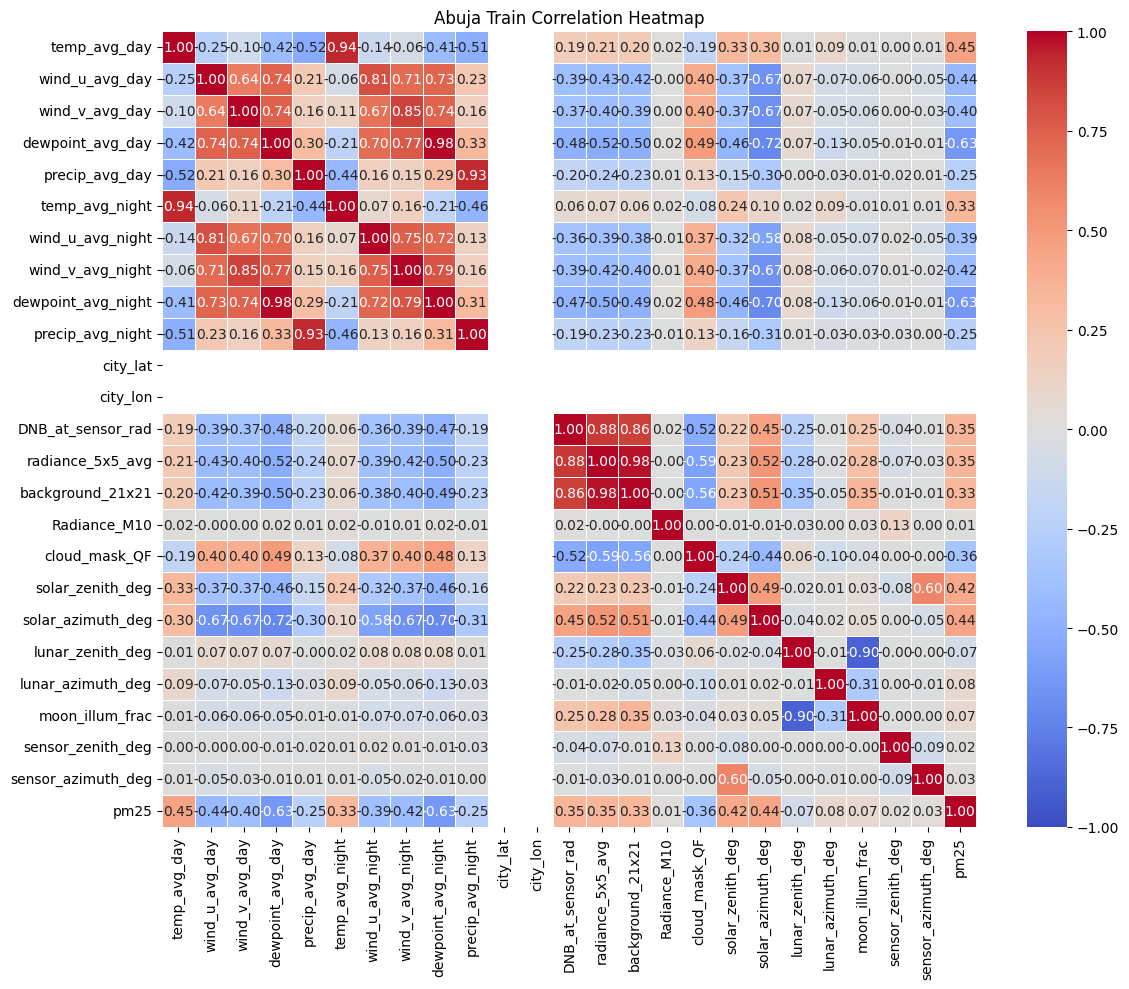

In [45]:
#train datasets
# Only numeric columns
numeric_features = abuja_train.select_dtypes(include='number')

# Filter to a cleaner subset, e.g., exclude _missing columns
features_subset = [col for col in numeric_features if 'miss' not in col and col != 'pm25']
corr = abuja_train[features_subset + ['pm25']].corr()

# Plot with annotations
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title("Abuja Train Correlation Heatmap")
plt.tight_layout()
plt.show()

PM2.5 is most negatively correlated with dewpoint (day and night), wind (u and v) amd cloud mask
It is positively correlated with temp (day), and other satellite features like DNB at sensor radiance, solar zenith, solar azimuth.

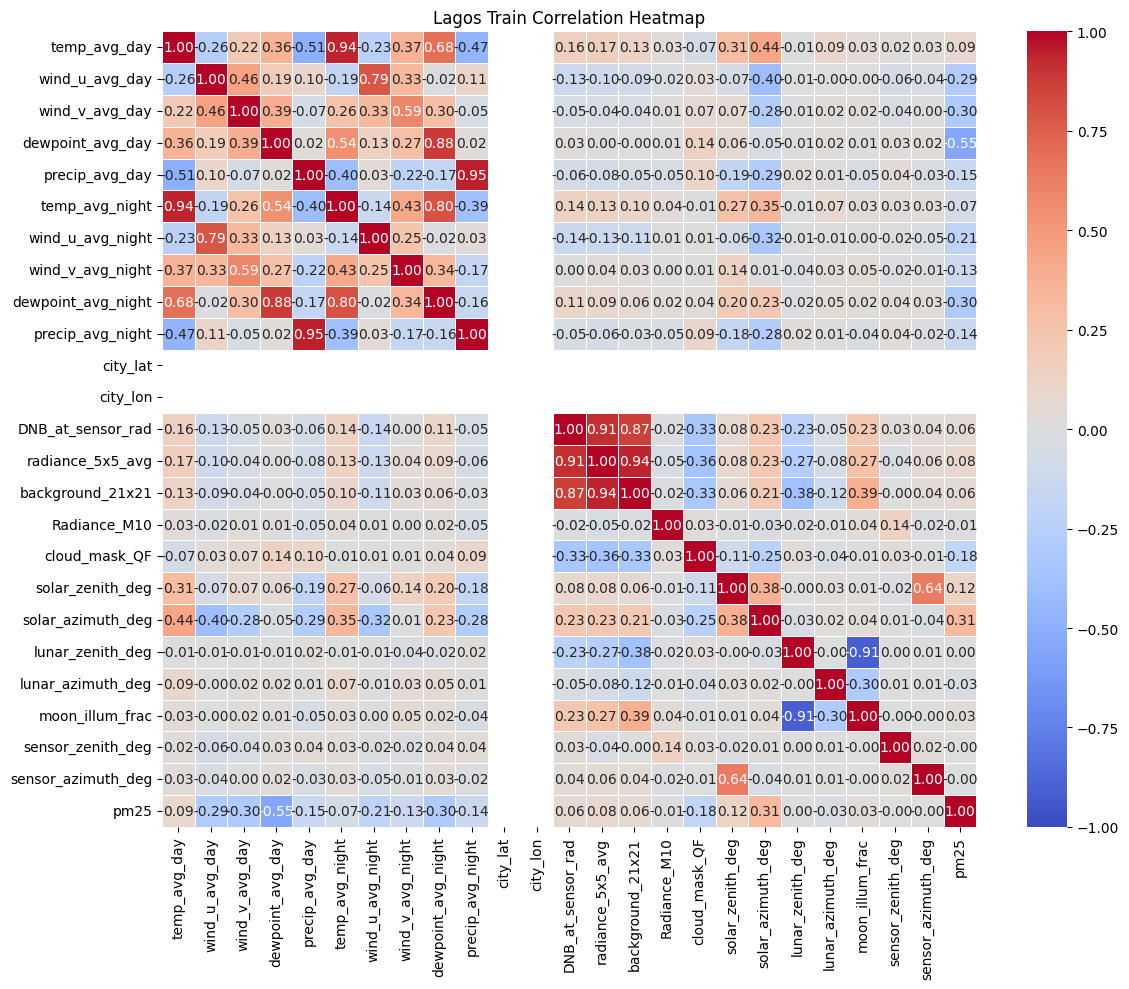

In [46]:
#plotting the heatmap for other cities
# Lagos
corr_lagos = lagos_train[features_subset + ['pm25']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_lagos, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title("Lagos Train Correlation Heatmap")
plt.tight_layout()
plt.show()

In lagos, PM2.5 is most negatively correlated with dewpoint (day), wind (u and v) and positively correlated with solar azimuth, with almost negligible positive corrilation with other features like temperature

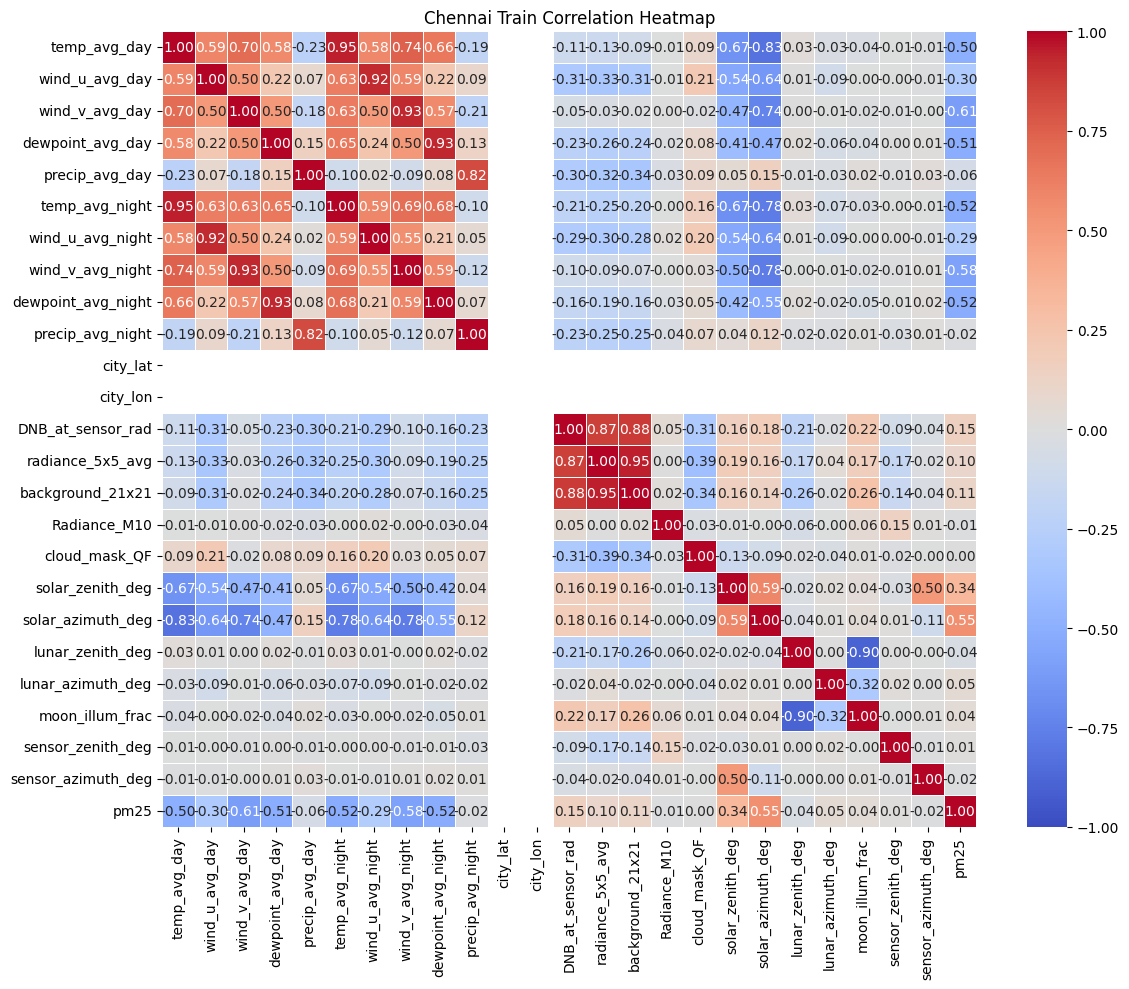

In [47]:
#Chennai
corr_chennai = chennai_train[features_subset + ['pm25']].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_chennai, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title("Chennai Train Correlation Heatmap")
plt.tight_layout()
plt.show()

In Chennai, we see negative correlations for most meteorological features , and the strongest positive correlation with solar azimuth

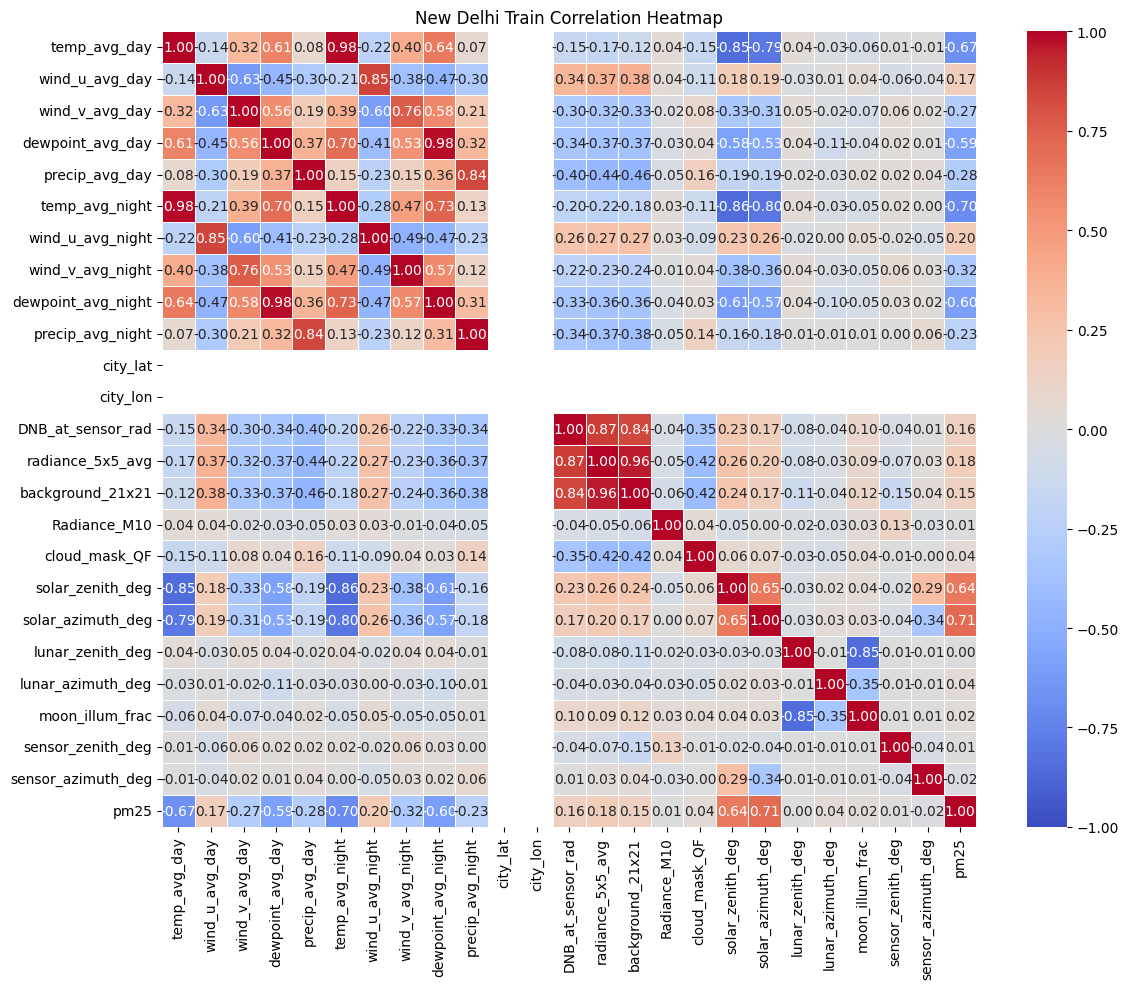

In [48]:
#newdelhi
corr_newdelhi = newdelhi_train[features_subset + ['pm25']].corr()
plt.figure(figsize=(12, 10))    
sns.heatmap(corr_newdelhi, annot=True, fmt=".2f", cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title("New Delhi Train Correlation Heatmap")
plt.tight_layout()
plt.show()

We see strong negative correlations for new delhi including temperature and dewpoint. A strong positive correlation with solar zenith and solar azimuth as well.

I will add new feature like "Day of the week" and "weekend/weekday flags" but I will see the accuracy of the models with these features first.

In [49]:
def prepare_features_and_target(train_df, valid_df, test_df):
    excluded = ['pm25', 'date', 'timestamp_utc', 'city_lat', 'city_lon']
    feature_cols = [col for col in train_df.columns if col not in excluded]

    X_train = train_df[feature_cols]
    y_train = train_df['pm25']

    X_valid = valid_df[feature_cols]
    y_valid = valid_df['pm25']

    X_test = test_df[feature_cols]
    y_test = test_df['pm25']

    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test), feature_cols

In [50]:
# Prepare features and target for Abuja dataset
(abuja_X_train, abuja_y_train), (abuja_X_val, abuja_y_val), (abuja_X_test, abuja_y_test), abuja_features = prepare_features_and_target(
    abuja_train, abuja_valid, abuja_test 
)

#check the shape of the x and y datasets
print(f"Abuja Train Features Shape: {abuja_X_train.shape}, Target Shape: {abuja_y_train.shape}")
print(f"Abuja Validation Features Shape: {abuja_X_val.shape}, Target Shape: {abuja_y_val.shape}")
print(f"Abuja Test Features Shape: {abuja_X_test.shape}, Target Shape: {abuja_y_test.shape}")

Abuja Train Features Shape: (1095, 48), Target Shape: (1095,)
Abuja Validation Features Shape: (182, 48), Target Shape: (182,)
Abuja Test Features Shape: (184, 48), Target Shape: (184,)


In [51]:
# Prepare features and target for other cities
(lagos_X_train, lagos_y_train), (lagos_X_val, lagos_y_val), (lagos_X_test, lagos_y_test), lagos_features = prepare_features_and_target(
    lagos_train, lagos_valid, lagos_test
)
(chennai_X_train, chennai_y_train), (chennai_X_val, chennai_y_val), (chennai_X_test, chennai_y_test), chennai_features = prepare_features_and_target(
    chennai_train, chennai_valid, chennai_test
)
(newdelhi_X_train, newdelhi_y_train), (newdelhi_X_val, newdelhi_y_val), (newdelhi_X_test, newdelhi_y_test), newdelhi_features = prepare_features_and_target(
    newdelhi_train, newdelhi_valid, newdelhi_test)

## XGBoost

In [52]:
# Define and train model
xgb_abuja = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_abuja.fit(abuja_X_train, abuja_y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=-1, num_parallel_tree=None, ...)

In [53]:
def evaluate_model(model, X_val, y_val, label="Validation"):
    preds = model.predict(X_val)

    # Filter out rows where pm25 is missing (just in case)
    mask = y_val.notna()
    y_true, y_pred = y_val[mask], preds[mask]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{label} Results:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²:   {r2:.3f}")
    return y_pred

In [54]:
# Evaluate on validation
abuja_val_preds = evaluate_model(xgb_abuja, abuja_X_val, abuja_y_val)

Validation Results:
RMSE: 45.01
MAE: 29.15
R²:   0.155


In [55]:
# Define and train model for other cities
xgb_lagos = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_lagos.fit(lagos_X_train, lagos_y_train)
# Evaluate on validation for Lagos
lagos_val_preds = evaluate_model(xgb_lagos, lagos_X_val, lagos_y_val, label="Lagos Validation")
# Define and train model for Chennai
xgb_chennai = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_chennai.fit(chennai_X_train, chennai_y_train)
# Evaluate on validation for Chennai
chennai_val_preds = evaluate_model(xgb_chennai, chennai_X_val, chennai_y_val, label="Chennai Validation")
# Define and train model for New Delhi  
xgb_newdelhi = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_newdelhi.fit(newdelhi_X_train, newdelhi_y_train)
# Evaluate on validation for New Delhi
newdelhi_val_preds = evaluate_model(xgb_newdelhi, newdelhi_X_val, newdelhi_y_val, label="New Delhi Validation") 


Lagos Validation Results:
RMSE: 45.69
MAE: 43.57
R²:   -1270.707
Chennai Validation Results:
RMSE: 15.46
MAE: 9.66
R²:   0.314
New Delhi Validation Results:
RMSE: 38.71
MAE: 25.78
R²:   0.729


In [56]:
#use model trained on New Delhi to predict validation set for Abuja, Lagos, and Chennai
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(newdelhi_X_train, newdelhi_y_train)

# Predict on Lagos validation set using New Delhi-trained model
lagos_val_preds_from_delhi = evaluate_model(
    xgb, lagos_X_val, lagos_y_val, label="Lagos (using New Delhi model)"
)

# Predict on Chennai validation set
chennai_val_preds_from_delhi = evaluate_model(
    xgb, chennai_X_val, chennai_y_val, label="Chennai (using New Delhi model)"
)

# Predict on Abuja validation set
abuja_val_preds_from_delhi = evaluate_model(
    xgb, abuja_X_val, abuja_y_val, label="Abuja (using New Delhi model)"
)

Lagos (using New Delhi model) Results:
RMSE: 105.64
MAE: 84.34
R²:   -6796.211
Chennai (using New Delhi model) Results:
RMSE: 132.66
MAE: 100.67
R²:   -49.531
Abuja (using New Delhi model) Results:
RMSE: 131.42
MAE: 99.78
R²:   -6.205


In [57]:
#add calendar features to the mean imputed datasets
#day of the week, month and is_weekend
def add_calendar_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    return df



In [58]:
# add calendar seasonal features
def add_seasonality_features(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek  # 0= Monday, 6 = Sunday
    df['month'] = df['date'].dt.month  # 1 = January, 12 = December
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['date'].dt.dayofyear / 365.25)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['date'].dt.dayofyear / 365.25)  
    return df


In [114]:
# Apply calendar features to all datasets
abuja_train_clean = add_calendar_features(abuja_train)
lagos_train_clean = add_calendar_features(lagos_train)
chennai_train_clean = add_calendar_features(chennai_train)
newdelhi_train_clean = add_calendar_features(newdelhi_train)
# Apply calendar features to validation datasets
abuja_valid_clean = add_calendar_features(abuja_valid)
lagos_valid_clean = add_calendar_features(lagos_valid)
chennai_valid_clean = add_calendar_features(chennai_valid)
newdelhi_valid_clean = add_calendar_features(newdelhi_valid)
# Apply calendar features to test datasets
abuja_test_clean = add_calendar_features(abuja_test)
lagos_test_clean = add_calendar_features(lagos_test)
chennai_test_clean = add_calendar_features(chennai_test)
newdelhi_test_clean = add_calendar_features(newdelhi_test)
# Prepare features and target for all cities with calendar features
(abuja_X_train_cal, abuja_y_train_cal), (abuja_X_val_cal, abuja_y_val_cal), (abuja_X_test_cal, abuja_y_test_cal), abuja_features_cal = prepare_features_and_target(
    abuja_train_clean, abuja_valid_clean, abuja_test_clean
)
(lagos_X_train_cal, lagos_y_train_cal), (lagos_X_val_cal, lagos_y_val_cal), (lagos_X_test_cal, lagos_y_test_cal), lagos_features_cal = prepare_features_and_target(
    lagos_train_clean, lagos_valid_clean, lagos_test_clean   
)
(chennai_X_train_cal, chennai_y_train_cal), (chennai_X_val_cal, chennai_y_val_cal), (chennai_X_test_cal, chennai_y_test_cal), chennai_features_cal = prepare_features_and_target(
    chennai_train_clean, chennai_valid_clean, chennai_test_clean
)
(newdelhi_X_train_cal, newdelhi_y_train_cal), (newdelhi_X_val_cal, newdelhi_y_val_cal), (newdelhi_X_test_cal, newdelhi_y_test_cal), newdelhi_features_cal = prepare_features_and_target(
    newdelhi_train_clean, newdelhi_valid_clean, newdelhi_test_clean
)


In [115]:
# Define and train model for all cities with calendar features
xgb_abuja_cal = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_abuja_cal.fit(abuja_X_train_cal, abuja_y_train_cal)
# Evaluate on validation for Abuja with calendar features
abuja_val_preds_cal = evaluate_model(xgb_abuja_cal, abuja_X_val_cal, abuja_y_val_cal, label="Abuja Validation  Imputed + Calendar Features)")


# Define and train model for Lagos with calendar features
xgb_lagos_cal = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_lagos_cal.fit(lagos_X_train_cal, lagos_y_train_cal)

# Evaluate on validation for Lagos with calendar features   
lagos_val_preds_cal = evaluate_model(xgb_lagos_cal, lagos_X_val_cal, lagos_y_val_cal, label="Lagos Validation  Imputed + Calendar Features)")
# Define and train model for Chennai with calendar features
xgb_chennai_cal = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_chennai_cal.fit(chennai_X_train_cal, chennai_y_train_cal)
# Evaluate on validation for Chennai with calendar features
chennai_val_preds_cal = evaluate_model(xgb_chennai_cal, chennai_X_val_cal, chennai_y_val_cal, label="Chennai Validation  Imputed + Calendar Features)")


# Define and train model for New Delhi with calendar features
xgb_newdelhi_cal = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_newdelhi_cal.fit(newdelhi_X_train_cal, newdelhi_y_train_cal)
# Evaluate on validation for New Delhi with calendar features
newdelhi_val_preds_cal = evaluate_model(xgb_newdelhi_cal, newdelhi_X_val_cal, newdelhi_y_val_cal, label="New Delhi Validation  Imputed + Calendar Features)")  


Abuja Validation  Imputed + Calendar Features) Results:
RMSE: 41.82
MAE: 28.48
R²:   0.270
Lagos Validation  Imputed + Calendar Features) Results:
RMSE: 42.16
MAE: 40.00
R²:   -1081.560
Chennai Validation  Imputed + Calendar Features) Results:
RMSE: 15.50
MAE: 9.55
R²:   0.310
New Delhi Validation  Imputed + Calendar Features) Results:
RMSE: 40.47
MAE: 27.43
R²:   0.704


In [116]:
# Apply seasonality features to all imputed datasets
abuja_train_clean_season = add_seasonality_features(abuja_train_clean)
lagos_train_clean_season = add_seasonality_features(lagos_train_clean)
chennai_train_clean_season = add_seasonality_features(chennai_train_clean)
newdelhi_train_clean_season = add_seasonality_features(newdelhi_train_clean)
# Apply seasonality features to validation datasets
abuja_valid_clean_season = add_seasonality_features(abuja_valid_clean)
lagos_valid_clean_season = add_seasonality_features(lagos_valid_clean)
chennai_valid_clean_season = add_seasonality_features(chennai_valid_clean)
newdelhi_valid_clean_season = add_seasonality_features(newdelhi_valid_clean)
# Apply seasonality features to test datasets
abuja_test_clean_season = add_seasonality_features(abuja_test_clean)
lagos_test_clean_season = add_seasonality_features(lagos_test_clean)
chennai_test_clean_season = add_seasonality_features(chennai_test_clean)
newdelhi_test_clean_season = add_seasonality_features(newdelhi_test_clean)

# Prepare features and target for all cities with seasonality features
(abuja_X_train_season, abuja_y_train_season), (abuja_X_val_season, abuja_y_val_season), (abuja_X_test_season, abuja_y_test_season), abuja_features_season = prepare_features_and_target(
    abuja_train_clean_season, abuja_valid_clean_season, abuja_test_clean_season
)
(lagos_X_train_season, lagos_y_train_season), (lagos_X_val_season, lagos_y_val_season), (lagos_X_test_season, lagos_y_test_season), lagos_features_season = prepare_features_and_target(
    lagos_train_clean_season, lagos_valid_clean_season, lagos_test_clean_season
)
(chennai_X_train_season, chennai_y_train_season), (chennai_X_val_season, chennai_y_val_season), (chennai_X_test_season, chennai_y_test_season), chennai_features_season = prepare_features_and_target(
    chennai_train_clean_season, chennai_valid_clean_season, chennai_test_clean_season
)
(newdelhi_X_train_season, newdelhi_y_train_season), (newdelhi_X_val_season, newdelhi_y_val_season), (newdelhi_X_test_season, newdelhi_y_test_season), newdelhi_features_season = prepare_features_and_target(
    newdelhi_train_clean_season, newdelhi_valid_clean_season, newdelhi_test_clean_season
)

In [117]:
#check size of x and y datasets with seasonality features
print(f"Abuja_Train Features Shape: {abuja_X_train_season.shape}, Target Shape: {abuja_y_train_season.shape}")
print(f"Abuja_Validation Features Shape: {abuja_X_val_season.shape}, Target Shape: {abuja_y_val_season.shape}")
print(f"Abuja_Test Features Shape: {abuja_X_test_season.shape}, Target Shape: {abuja_y_test_season.shape}")
#lagos  
print(f"Lagos_Train Features Shape: {lagos_X_train_season.shape}, Target Shape: {lagos_y_train_season.shape}")
print(f"Lagos_Validation Features Shape: {lagos_X_val_season.shape}, Target Shape: {lagos_y_val_season.shape}")
print(f"Lagos_Test Features Shape: {lagos_X_test_season.shape}, Target Shape: {lagos_y_test_season.shape}")
#chennai
print(f"Chennai_Train Features Shape: {chennai_X_train_season.shape}, Target Shape: {chennai_y_train_season.shape}")
print(f"Chennai_Validation Features Shape: {chennai_X_val_season.shape}, Target Shape: {chennai_y_val_season.shape}")
print(f"Chennai_Test Features Shape: {chennai_X_test_season.shape}, Target Shape: {chennai_y_test_season.shape}")
#newdelhi
print(f"New Delhi_Train Features Shape: {newdelhi_X_train_season.shape}, Target Shape: {newdelhi_y_train_season.shape}")
print(f"New Delhi_Validation Features Shape: {newdelhi_X_val_season.shape}, Target Shape: {newdelhi_y_val_season.shape}")
print(f"New Delhi_Test Features Shape: {newdelhi_X_test_season.shape}, Target Shape: {newdelhi_y_test_season.shape}")

Abuja_Train Features Shape: (1095, 53), Target Shape: (1095,)
Abuja_Validation Features Shape: (182, 53), Target Shape: (182,)
Abuja_Test Features Shape: (184, 53), Target Shape: (184,)
Lagos_Train Features Shape: (1095, 53), Target Shape: (1095,)
Lagos_Validation Features Shape: (182, 53), Target Shape: (182,)
Lagos_Test Features Shape: (184, 53), Target Shape: (184,)
Chennai_Train Features Shape: (1095, 53), Target Shape: (1095,)
Chennai_Validation Features Shape: (182, 53), Target Shape: (182,)
Chennai_Test Features Shape: (184, 53), Target Shape: (184,)
New Delhi_Train Features Shape: (1095, 53), Target Shape: (1095,)
New Delhi_Validation Features Shape: (182, 53), Target Shape: (182,)
New Delhi_Test Features Shape: (184, 53), Target Shape: (184,)


In [118]:
# Define and train model for all cities with seasonality features
xgb_abuja_season = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,    random_state=42,
    n_jobs=-1
)
xgb_abuja_season.fit(abuja_X_train_season, abuja_y_train_season)
# Evaluate on validation for Abuja with seasonality features
abuja_val_preds_season = evaluate_model(xgb_abuja_season, abuja_X_val_season, abuja_y_val_season, label="Abuja Validation (Imputed + Seasonality Features)")
# Define and train model for Lagos with seasonality features
xgb_lagos_season = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_lagos_season.fit(lagos_X_train_season, lagos_y_train_season)
# Evaluate on validation for Lagos with seasonality features
lagos_val_preds_season = evaluate_model(xgb_lagos_season, lagos_X_val_season, lagos_y_val_season, label="Lagos Validation (Imputed + Seasonality Features)")
# Define and train model for Chennai with seasonality features
xgb_chennai_season = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_chennai_season.fit(chennai_X_train_season, chennai_y_train_season)
# Evaluate on validation for Chennai with seasonality features
chennai_val_preds_season = evaluate_model(xgb_chennai_season, chennai_X_val_season, chennai_y_val_season, label="Chennai Validation (Imputed + Seasonality Features)")
# Define and train model for New Delhi with seasonality features
xgb_newdelhi_season = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_newdelhi_season.fit(newdelhi_X_train_season, newdelhi_y_train_season)
# Evaluate on validation for New Delhi with seasonality features
newdelhi_val_preds_season = evaluate_model(xgb_newdelhi_season, newdelhi_X_val_season, newdelhi_y_val_season, label="New Delhi Validation (Imputed + Seasonality Features)")


Abuja Validation (Imputed + Seasonality Features) Results:
RMSE: 42.83
MAE: 28.93
R²:   0.235
Lagos Validation (Imputed + Seasonality Features) Results:
RMSE: 42.53
MAE: 40.92
R²:   -1100.621
Chennai Validation (Imputed + Seasonality Features) Results:
RMSE: 15.90
MAE: 9.52
R²:   0.274
New Delhi Validation (Imputed + Seasonality Features) Results:
RMSE: 41.46
MAE: 27.22
R²:   0.690



Lagos struggles a lot due to having the most missing data levels and only 2 PM2.5 readings for the validation set, used to impute the entire validation set. By treating Lagos as a special case, I will check the performance of the non interpolated dataset to gauge the difference in performance.

In [119]:
# Add calendar and seasonality features to the raw datasets 
abuja_train_raw = add_calendar_features(abuja_raw)
lagos_train_raw = add_calendar_features(lagos_raw)
chennai_train_raw = add_calendar_features(chennai_raw)
newdelhi_train_raw = add_calendar_features(newdelhi_raw)

abuja_valid_raw = add_calendar_features(abuja_valid_raw)
lagos_valid_raw = add_calendar_features(lagos_valid_raw)
chennai_valid_raw = add_calendar_features(chennai_valid_raw)
newdelhi_valid_raw = add_calendar_features(newdelhi_valid_raw)

abuja_test_raw = add_calendar_features(abuja_test_raw)
lagos_test_raw = add_calendar_features(lagos_test_raw)
chennai_test_raw = add_calendar_features(chennai_test_raw)
newdelhi_test_raw = add_calendar_features(newdelhi_test_raw)


#add seasonality features to the raw datasets
abuja_train_raw = add_seasonality_features(abuja_train_raw)
lagos_train_raw = add_seasonality_features(lagos_train_raw)
chennai_train_raw = add_seasonality_features(chennai_train_raw)
newdelhi_train_raw = add_seasonality_features(newdelhi_train_raw)

abuja_valid_raw = add_seasonality_features(abuja_valid_raw)
lagos_valid_raw = add_seasonality_features(lagos_valid_raw)
chennai_valid_raw = add_seasonality_features(chennai_valid_raw)
newdelhi_valid_raw = add_seasonality_features(newdelhi_valid_raw)



In [120]:

# --- Helper function for masked evaluation ---
def masked_evaluate(model, X_val, y_val, label=""):
    preds = model.predict(X_val)
    mask = ~y_val.isna()

    mae = mean_absolute_error(y_val[mask], preds[mask])
    rmse = np.sqrt(mean_squared_error(y_val[mask], preds[mask]))
    r2 = r2_score(y_val[mask], preds[mask])

    print(f"{label}")
    print(f" - RMSE  : {rmse:.2f}")
    print(f" - MAE : {mae:.2f}")
    print(f" - R²    : {r2:.3f}")
    return preds

# 🔹 Abuja
abuja_train_raw = abuja_train_raw.dropna(subset=['pm25'])
X_abuja_val_raw = abuja_valid_raw.drop(columns=['pm25', 'date', 'timestamp_utc', 'city_lat', 'city_lon'])
y_abuja_val_raw = abuja_valid_raw['pm25']

xgb_abuja_raw = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_abuja_raw.fit(
    abuja_train_raw.drop(columns=['pm25', 'date', 'timestamp_utc', 'city_lat', 'city_lon']),
    abuja_train_raw['pm25']
)
abuja_val_preds_raw = masked_evaluate(xgb_abuja_raw, X_abuja_val_raw, y_abuja_val_raw,
    label="Abuja Validation (Raw Data + Calendar + Seasonality Features)")

# 🔹 Lagos
lagos_train_raw = lagos_train_raw.dropna(subset=['pm25'])
X_lagos_val_raw = lagos_valid_raw.drop(columns=['pm25', 'date', 'timestamp_utc', 'city_lat', 'city_lon'])
y_lagos_val_raw = lagos_valid_raw['pm25']

xgb_lagos_raw = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_lagos_raw.fit(
    lagos_train_raw.drop(columns=['pm25', 'date', 'timestamp_utc', 'city_lat', 'city_lon']),
    lagos_train_raw['pm25']
)
lagos_val_preds_raw = masked_evaluate(xgb_lagos_raw, X_lagos_val_raw, y_lagos_val_raw,
    label="Lagos Validation (Raw Data + Calendar + Seasonality Features)")

# 🔹 Chennai
chennai_train_raw = chennai_train_raw.dropna(subset=['pm25'])
X_chennai_val_raw = chennai_valid_raw.drop(columns=['pm25', 'date', 'timestamp_utc', 'city_lat', 'city_lon'])
y_chennai_val_raw = chennai_valid_raw['pm25']

xgb_chennai_raw = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_chennai_raw.fit(
    chennai_train_raw.drop(columns=['pm25', 'date', 'timestamp_utc', 'city_lat', 'city_lon']),
    chennai_train_raw['pm25']
)
chennai_val_preds_raw = masked_evaluate(xgb_chennai_raw, X_chennai_val_raw, y_chennai_val_raw,
    label="Chennai Validation (Raw Data + Calendar + Seasonality Features)")

# 🔹 New Delhi
newdelhi_train_raw = newdelhi_train_raw.dropna(subset=['pm25'])
X_newdelhi_val_raw = newdelhi_valid_raw.drop(columns=['pm25', 'date', 'timestamp_utc', 'city_lat', 'city_lon'])
y_newdelhi_val_raw = newdelhi_valid_raw['pm25']

xgb_newdelhi_raw = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_newdelhi_raw.fit(
    newdelhi_train_raw.drop(columns=['pm25', 'date', 'timestamp_utc', 'city_lat', 'city_lon']),
    newdelhi_train_raw['pm25']
)
newdelhi_val_preds_raw = masked_evaluate(xgb_newdelhi_raw, X_newdelhi_val_raw, y_newdelhi_val_raw,
    label="New Delhi Validation (Raw Data + Calendar + Seasonality Features)")

Abuja Validation (Raw Data + Calendar + Seasonality Features)
 - RMSE  : 43.54
 - MAE : 29.47
 - R²    : 0.183
Lagos Validation (Raw Data + Calendar + Seasonality Features)
 - RMSE  : 35.27
 - MAE : 34.82
 - R²    : -15.564
Chennai Validation (Raw Data + Calendar + Seasonality Features)
 - RMSE  : 17.30
 - MAE : 11.02
 - R²    : 0.268
New Delhi Validation (Raw Data + Calendar + Seasonality Features)
 - RMSE  : 42.05
 - MAE : 26.77
 - R²    : 0.681


- Interpolation  slightly edges out raw data for three of the four cities (Abuja, Chennai, New Delhi), but it absolutely collapses for Lagos.
- Raw data + missingness flags delivers a far more stable result in Lagos, at a small cost in the other cities.


In Abuja Chennai and New Delhi, it clarified structure, reduced errors, and boosted fit. In Lagos, it amplified noise, possibly due to the very scarce data we started with in the validation set. And in New Delhi, it added nuance rather than precision.



I will focus on Abuja, Chennai and New Delhi alone now. I am excluding Lagos because interpolation creates artificial smoothness that doesn't reflect real air quality patterns
Model learns from this smooth, fake pattern during training.

## Lagged Features testing

In [121]:

def create_lags(df, meteo_features, pm25_feature, max_lag=3):
    df = df.copy().sort_values('date').reset_index(drop=True)  
    for lag in range(1, max_lag + 1):
        for feature in meteo_features + pm25_feature:
            if feature in df.columns:
                df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    return df

# Define features
meteo_features = [
    'temp_avg_day', 'dewpoint_avg_day', 'wind_u_avg_day', 'wind_v_avg_day', 'precip_avg_day',
    'temp_avg_night', 'dewpoint_avg_night', 'wind_u_avg_night', 'wind_v_avg_night', 'precip_avg_night'
]
pm25_feature = ['pm25']
required_lag_cols = [f'{f}_lag{l}' for f in meteo_features + pm25_feature for l in range(1, 4)]
required_cols = ['pm25'] + required_lag_cols

# Define cities
cities = ['abuja', 'chennai', 'newdelhi']
results = {}

for city in cities:
    print(f"Processing {city}...")

    train = globals()[f"{city}_train_clean"].copy()
    valid = globals()[f"{city}_valid_clean"].copy()
    test = globals()[f"{city}_test_clean"].copy()

    # Store original date ranges
    train_start, train_end = train.date.min(), train.date.max()
    valid_start, valid_end = valid.date.min(), valid.date.max()
    test_start, test_end = test.date.min(), test.date.max()

    # Combine and sort full dataset
    full = pd.concat([train, valid, test]).sort_values('date').reset_index(drop=True)
    full_lags = create_lags(full, meteo_features, pm25_feature, max_lag=3)

    # Split using original date ranges
    train_lags = full_lags[(full_lags.date >= train_start) & (full_lags.date <= train_end)].copy()
    valid_lags = full_lags[(full_lags.date >= valid_start) & (full_lags.date <= valid_end)].copy()
    test_lags = full_lags[(full_lags.date >= test_start) & (full_lags.date <= test_end)].copy()

    # Drop rows with missing critical features
    train_lags = train_lags.dropna(subset=required_cols)
    valid_lags = valid_lags.dropna(subset=required_cols)
    test_lags = test_lags.dropna(subset=required_cols)

    # Verify temporal consistency
    assert valid_lags.date.min() > train_lags.date.max(), f"{city}: Train-validation overlap!"
    assert test_lags.date.min() > valid_lags.date.max(), f"{city}: Validation-test overlap!"

    # Save results
    results[city] = {'train': train_lags, 'valid': valid_lags, 'test': test_lags}
    print(f"  ✅ {city} processed: {len(train_lags)}/{len(valid_lags)}/{len(test_lags)} samples")


print("All cities processed with clean lag indexing!")

# Update original variables for downstream use
abuja_train_lags = results['abuja']['train']
abuja_valid_lags = results['abuja']['valid']
abuja_test_lags = results['abuja']['test']
chennai_train_lags = results['chennai']['train']
chennai_valid_lags = results['chennai']['valid']
chennai_test_lags = results['chennai']['test']
newdelhi_train_lags = results['newdelhi']['train']
newdelhi_valid_lags = results['newdelhi']['valid']
newdelhi_test_lags = results['newdelhi']['test']

Processing abuja...
  ✅ abuja processed: 1092/182/184 samples
Processing chennai...
  ✅ chennai processed: 1092/182/184 samples
Processing newdelhi...
  ✅ newdelhi processed: 1092/182/184 samples
All cities processed with clean lag indexing!


In [122]:
#train models with lag features
def train_model_with_lags(X_train, y_train):
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model
# Prepare features and target for Abuja with lags
(abuja_X_train_lags, abuja_y_train_lags), (abuja_X_val_lags, abuja_y_val_lags), (abuja_X_test_lags, abuja_y_test_lags), abuja_features_lags = prepare_features_and_target(
    abuja_train_lags, abuja_valid_lags, abuja_test_lags
)
# Train model for Abuja with lags
xgb_abuja_lags = train_model_with_lags(abuja_X_train_lags, abuja_y_train_lags)
# Evaluate on validation for Abuja with lags
abuja_val_preds_lags = evaluate_model(xgb_abuja_lags, abuja_X_val_lags, abuja_y_val_lags, label="Abuja Validation (Lags)")
# Prepare features and target for Chennai with lags 
(chennai_X_train_lags, chennai_y_train_lags), (chennai_X_val_lags, chennai_y_val_lags), (chennai_X_test_lags, chennai_y_test_lags), chennai_features_lags = prepare_features_and_target(
    chennai_train_lags, chennai_valid_lags, chennai_test_lags
)
# Train model for Chennai with lags
xgb_chennai_lags = train_model_with_lags(chennai_X_train_lags, chennai_y_train_lags)
# Evaluate on validation for Chennai with lags
chennai_val_preds_lags = evaluate_model(xgb_chennai_lags, chennai_X_val_lags, chennai_y_val_lags, label="Chennai Validation (Lags)")
# Prepare features and target for New Delhi with lags
(newdelhi_X_train_lags, newdelhi_y_train_lags), (newdelhi_X_val_lags, newdelhi_y_val_lags), (newdelhi_X_test_lags, newdelhi_y_test_lags), newdelhi_features_lags = prepare_features_and_target(
    newdelhi_train_lags, newdelhi_valid_lags, newdelhi_test_lags
)

# Train model for New Delhi with lags
xgb_newdelhi_lags = train_model_with_lags(newdelhi_X_train_lags, newdelhi_y_train_lags)
# Evaluate on validation for New Delhi with lags

newdelhi_val_preds_lags = evaluate_model(xgb_newdelhi_lags, newdelhi_X_val_lags, newdelhi_y_val_lags, label="New Delhi Validation (Lags)")  


Abuja Validation (Lags) Results:
RMSE: 19.38
MAE: 11.51
R²:   0.843
Chennai Validation (Lags) Results:
RMSE: 11.15
MAE: 6.29
R²:   0.643
New Delhi Validation (Lags) Results:
RMSE: 35.96
MAE: 24.12
R²:   0.766


### Model Fine-Tuning

In [123]:
# define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

In [124]:
#looping through the  cities to find the best hyperparameters

result_dict = {}
# Function to perform hyperparameter tuning and evaluation
def tune_and_evaluate(X_train, y_train, X_val, y_val, city_name):
    xgb_reg = XGBRegressor(objective='reg:squarederror', verbosity=0)
    
    random_search = RandomizedSearchCV(
        estimator=xgb_reg,
        param_distributions=param_dist,
        n_iter=50,
        scoring='neg_root_mean_squared_error',
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        verbose=0,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    
    print(f"\nBest Hyperparameters for {city_name}:")
    print(random_search.best_params_)
    
    best_model = random_search.best_estimator_
    val_preds = evaluate_model(best_model, X_val, y_val, label=f"{city_name} Validation (Best Hyperparameters)")
    
    result_dict[city_name] = {
        'best_params': random_search.best_params_,
        'val_preds': val_preds
    }
    
    return best_model

In [127]:
#tune with multi-day lags
def tune_and_evaluate_3(X_train, y_train, X_val, y_val, city_name):
    xgb_reg = XGBRegressor(objective='reg:squarederror', verbosity=0)
    
    random_search = RandomizedSearchCV(
        estimator=xgb_reg,
        param_distributions=param_dist,
        n_iter=75,
        scoring='r2',
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    
    print(f"\nBest Hyperparameters for {city_name} with Multi-day Lags:")
    print(random_search.best_params_)
    
    best_model = random_search.best_estimator_
    val_preds = evaluate_model(best_model, X_val, y_val, label=f"{city_name} Validation (Best Hyperparameters with Multi-day Lags)")
    
    result_dict[city_name] = {
        'best_params': random_search.best_params_,
        'val_preds': val_preds
    }
    
    return best_model

In [128]:
#call the function for each city with multi-day lags
tune_and_evaluate_3(abuja_X_train_lags, abuja_y_train_lags, abuja_X_val_lags, abuja_y_val_lags, "Abuja")
tune_and_evaluate_3(chennai_X_train_lags, chennai_y_train_lags, chennai_X_val_lags, chennai_y_val_lags, "Chennai")
tune_and_evaluate_3(newdelhi_X_train_lags, newdelhi_y_train_lags, newdelhi_X_val_lags, newdelhi_y_val_lags, "New Delhi")


Fitting 5 folds for each of 75 candidates, totalling 375 fits

Best Hyperparameters for Abuja with Multi-day Lags:
{'subsample': 0.6, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Abuja Validation (Best Hyperparameters with Multi-day Lags) Results:
RMSE: 20.64
MAE: 12.84
R²:   0.822
Fitting 5 folds for each of 75 candidates, totalling 375 fits

Best Hyperparameters for Chennai with Multi-day Lags:
{'subsample': 0.6, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Chennai Validation (Best Hyperparameters with Multi-day Lags) Results:
RMSE: 11.13
MAE: 6.03
R²:   0.645
Fitting 5 folds for each of 75 candidates, totalling 375 fits

Best Hyperparameters for New Delhi with Multi-day Lags:
{'subsample': 0.6, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.7}
New Delhi Validation (Best Hyperparameters with Multi-day Lags) Results:
RMSE: 33.81
MAE: 22.58
R²:   0.793


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

### Adding Lagged Meteorological and PM2.5 values certainly improved model performance.



Chennai and New Delhi benefitted from multi day Lags

## Retrain with larger dataset of training and Validation data on the best models per city

In [129]:
#Store results and models
final_result_dict = {}
final_models = {}
city_data = {} 

# 📊 Evaluation Function for Test Set
def evaluate_model_test(model, X_test, y_test, city_name):
    preds = model.predict(X_test)
    mask = y_test.notna().values & np.isfinite(y_test.values)  
    y_true = y_test.iloc[mask]
    y_pred = preds[mask]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n📌 Final Test Results for {city_name}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"R²:    {r2:.3f}")

    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'preds': y_pred}

# City configurations for training + evaluation
city_configs = {
    "Abuja": {
        "X_trainval": pd.concat([abuja_X_train_lags, abuja_X_val_lags]).reset_index(drop=True),
        "y_trainval": pd.concat([abuja_y_train_lags, abuja_y_val_lags]).reset_index(drop=True),
        "X_test": abuja_X_test_lags,
        "y_test": abuja_y_test_lags,
        "params": {
            
    }},
    "Chennai": {
        "X_trainval": pd.concat([chennai_X_train_lags, chennai_X_val_lags]).reset_index(drop=True),
        "y_trainval": pd.concat([chennai_y_train_lags, chennai_y_val_lags]).reset_index(drop=True),
        "X_test": chennai_X_test_lags,
        "y_test": chennai_y_test_lags,
        "params": {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
    },
    "New Delhi": {
        "X_trainval": pd.concat([newdelhi_X_train_lags, newdelhi_X_val_lags]).reset_index(drop=True),
        "y_trainval": pd.concat([newdelhi_y_train_lags, newdelhi_y_val_lags]).reset_index(drop=True),
        "X_test": newdelhi_X_test_lags,
        "y_test": newdelhi_y_test_lags,
        "params": {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.7
        }
    }}

# Train and evaluate per city
for city, config in city_configs.items():
    # Mask valid training targets
    mask = config["y_trainval"].notna().values & np.isfinite(config["y_trainval"].values)
    X_clean = config["X_trainval"].iloc[mask]
    y_clean = config["y_trainval"].iloc[mask]

    # Train model
    model = XGBRegressor(objective='reg:squarederror', verbosity=0, **config["params"])
    model.fit(X_clean, y_clean)

    # Store model and cleaned training data
    final_models[city] = model
    city_data[city] = {'X_train': X_clean, 'y_train': y_clean}

    # Evaluate on test set
    results = evaluate_model_test(model, config["X_test"], config["y_test"], city)

    # Store
    final_result_dict[city] = results
    final_models[city] = model


📌 Final Test Results for Abuja:
RMSE: 11.84
MAE:  7.67
R²:    0.578

📌 Final Test Results for Chennai:
RMSE: 15.62
MAE:  8.24
R²:    0.573

📌 Final Test Results for New Delhi:
RMSE: 43.33
MAE:  21.13
R²:    0.808


Discuss


## Explainability with Permutation Importance, SHAP and ALE curves

<!-- - Bar plots: a fair, interaction‐aware ranking of your features
- Beeswarm: how high/low feature values push predictions up or down
- Force plots: exactly why one day’s forecast was high or low—great for peak events
- Dependence: uncover non‐linear trends and interaction hotspots -->


In [130]:
import skexplain

city_explainers = {}
for city in final_models.keys():
    explainer = skexplain.ExplainToolkit(
        estimators=[(f"{city}_model", final_models[city])],
        X=city_data[city]['X_train'],
        y=city_data[city]['y_train']
)
    city_explainers[city] = explainer

In [133]:
for city, explainer in city_explainers.items():
    print(f"Running permutation importance for {city}...")

    # Recompute
    results = explainer.permutation_importance(
        evaluation_fn='mse',
        n_vars=10,
        n_permute=30,
        direction='backward',
        n_jobs=8,
        random_seed=42,
        subsample=0.1,
        verbose=False
    )

    # Save to NetCDF
    results.to_netcdf(f"Datasets/results_csv/{city}_permu.nc")

Running permutation importance for Abuja...


Perm. Imp.: 100%|██████████| 10/10 [09:01<00:00, 54.14s/it]


Running permutation importance for Chennai...


Perm. Imp.: 100%|██████████| 10/10 [07:01<00:00, 42.14s/it]


Running permutation importance for New Delhi...


Perm. Imp.: 100%|██████████| 10/10 [06:23<00:00, 38.34s/it]


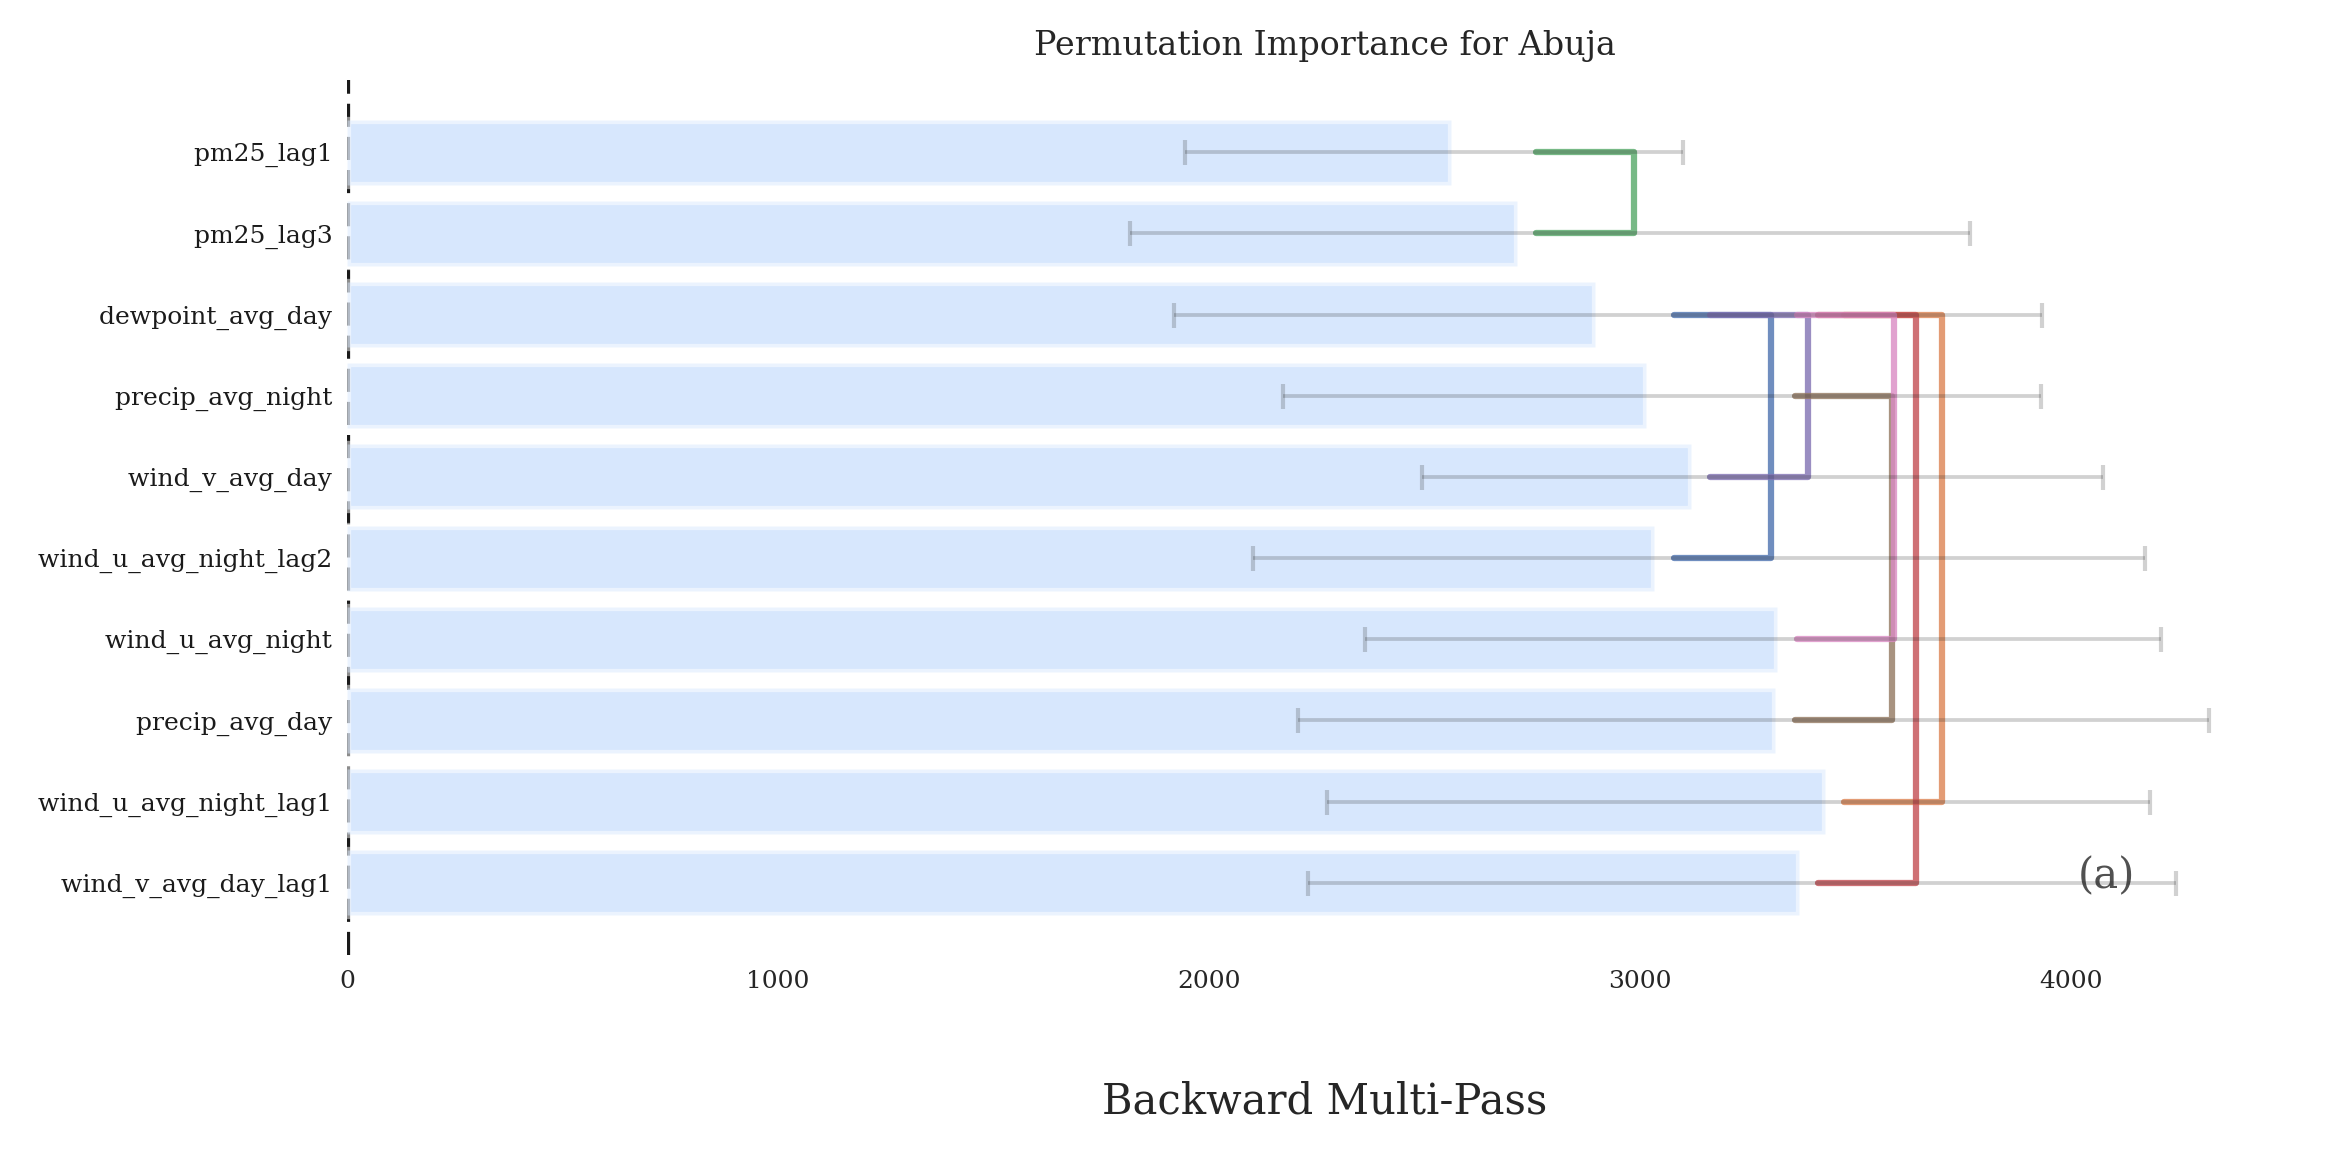

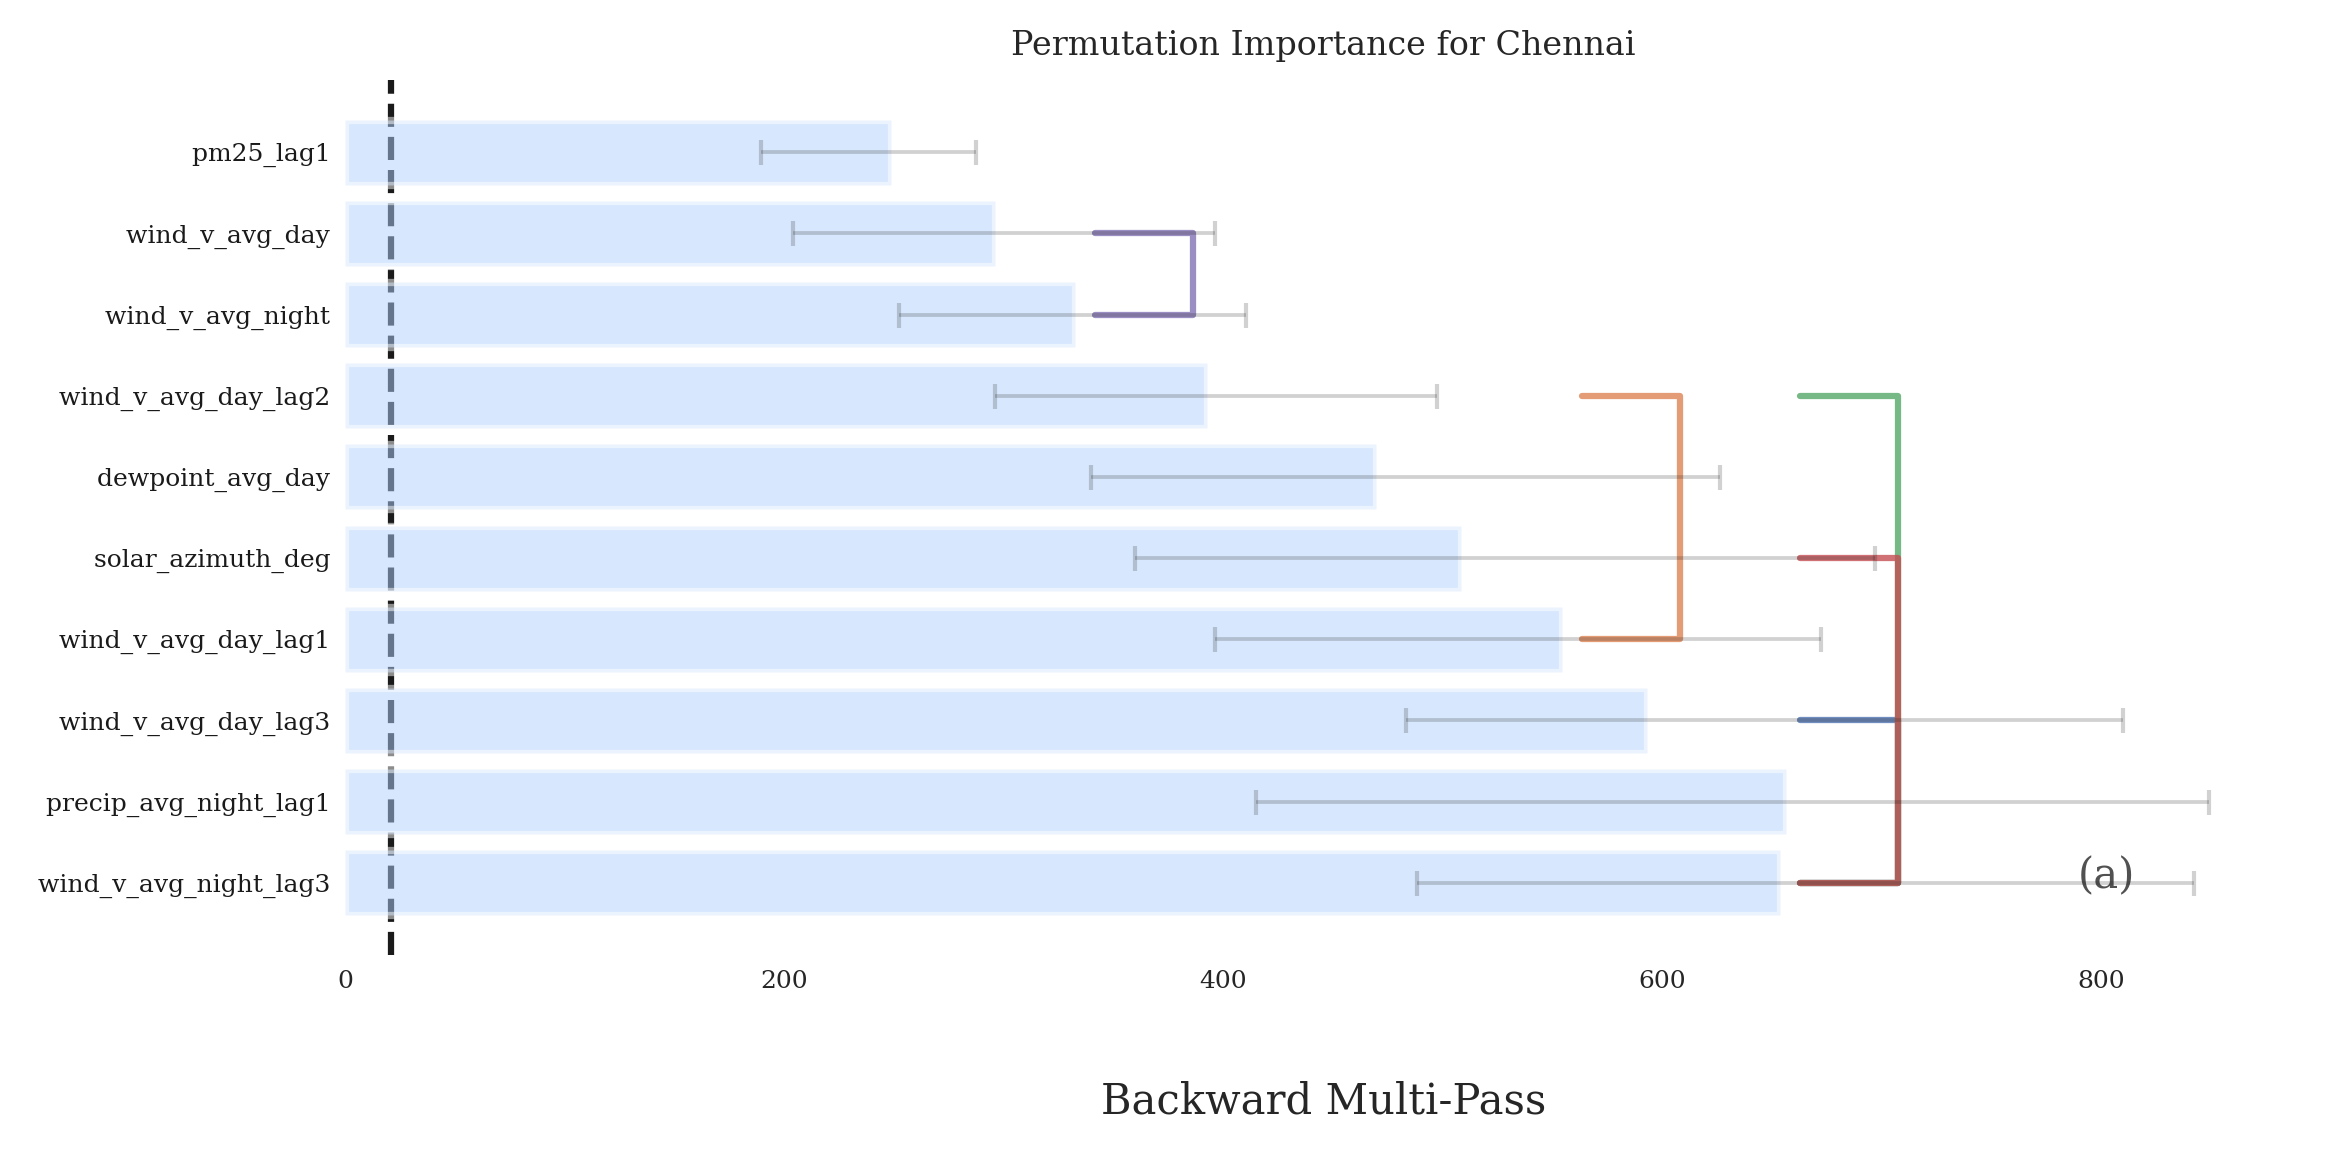

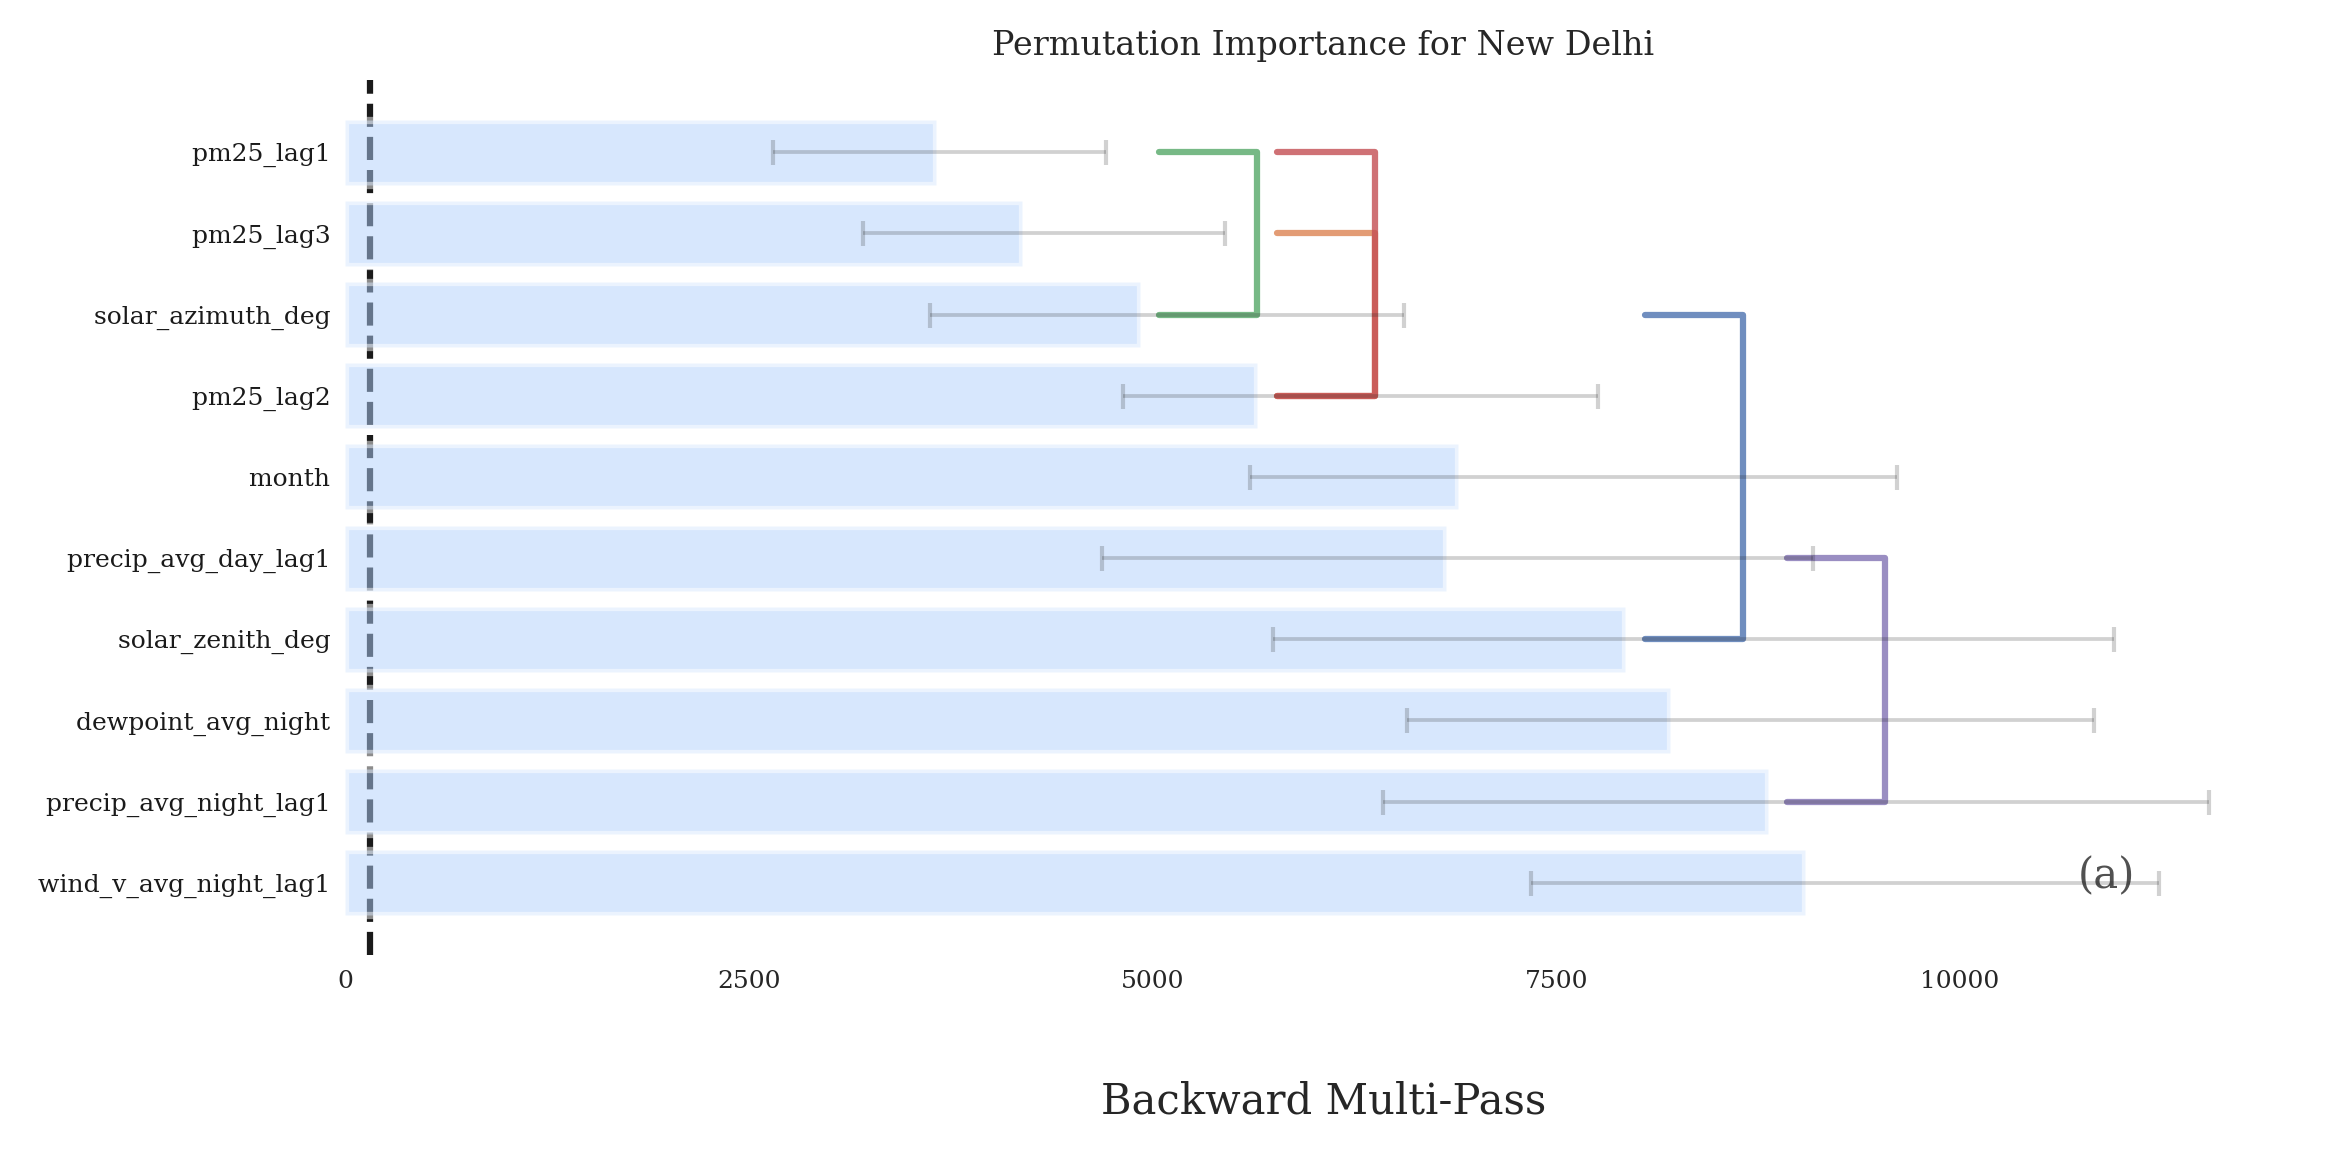

In [135]:
import xarray as xr

for city, explainer in city_explainers.items():
    perm_results = xr.open_dataset(f"Datasets/results_csv/{city}_permu.nc")

    fig = explainer.plot_importance(
        data=perm_results,
        panels=[('backward_multipass', f"{city}_model")],
        num_vars_to_plot=10,
        plot_correlated_features=True,
        rho_threshold=0.6,
        sort_vars=True,
        figsize=(8, 4)
    )

    plt.title(f"Permutation Importance for {city}")
    plt.tight_layout()
    plt.show()

Running TEST permutation importance for Abuja...


Perm. Imp.: 100%|██████████| 10/10 [07:23<00:00, 44.39s/it]


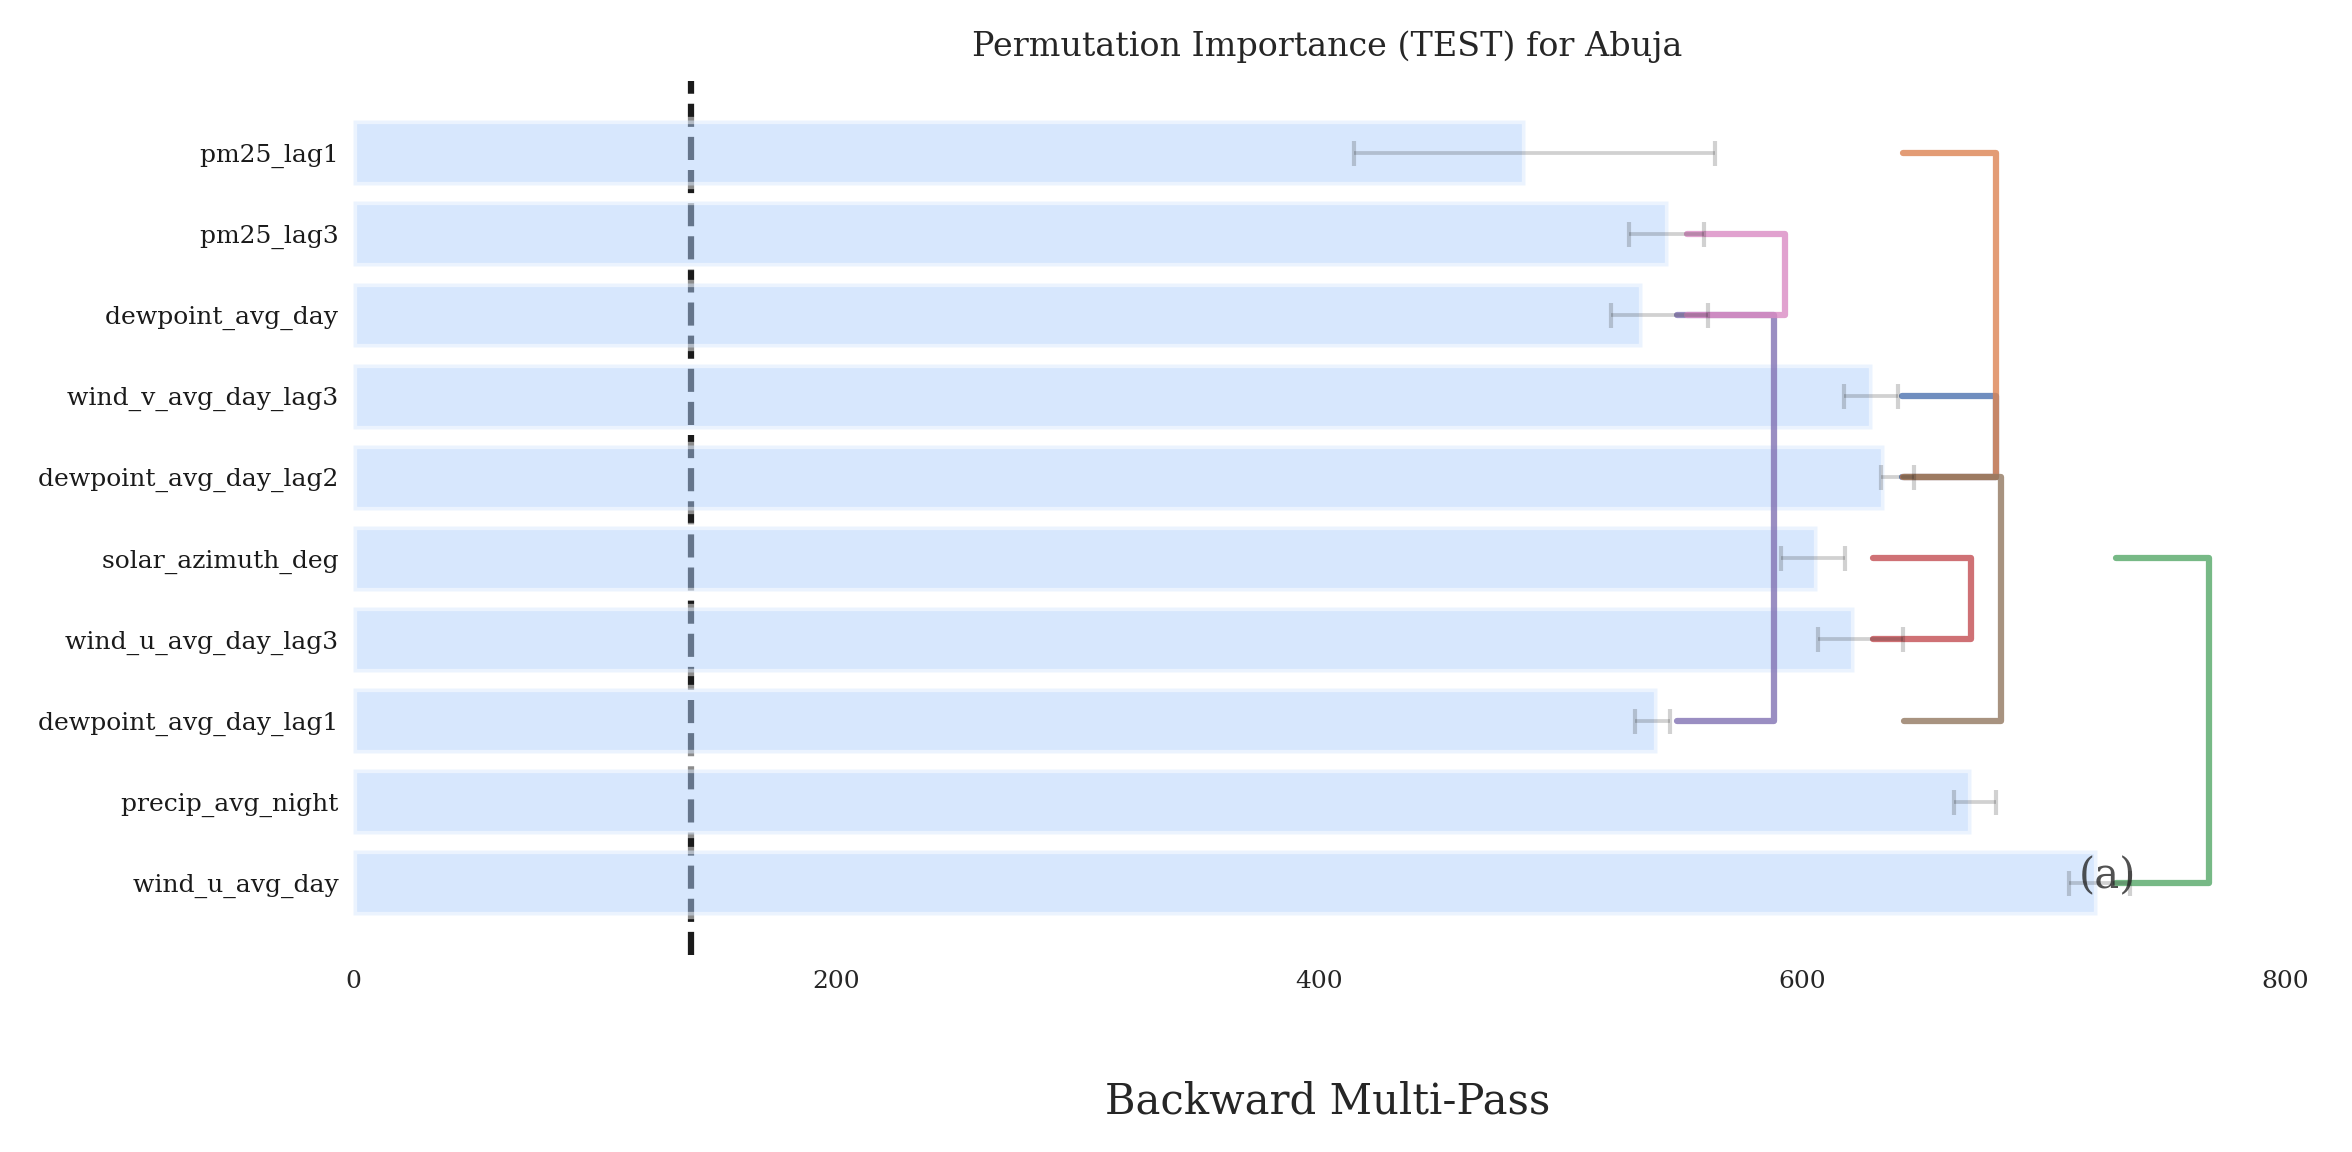

Running TEST permutation importance for Chennai...


Perm. Imp.: 100%|██████████| 10/10 [07:44<00:00, 46.41s/it]


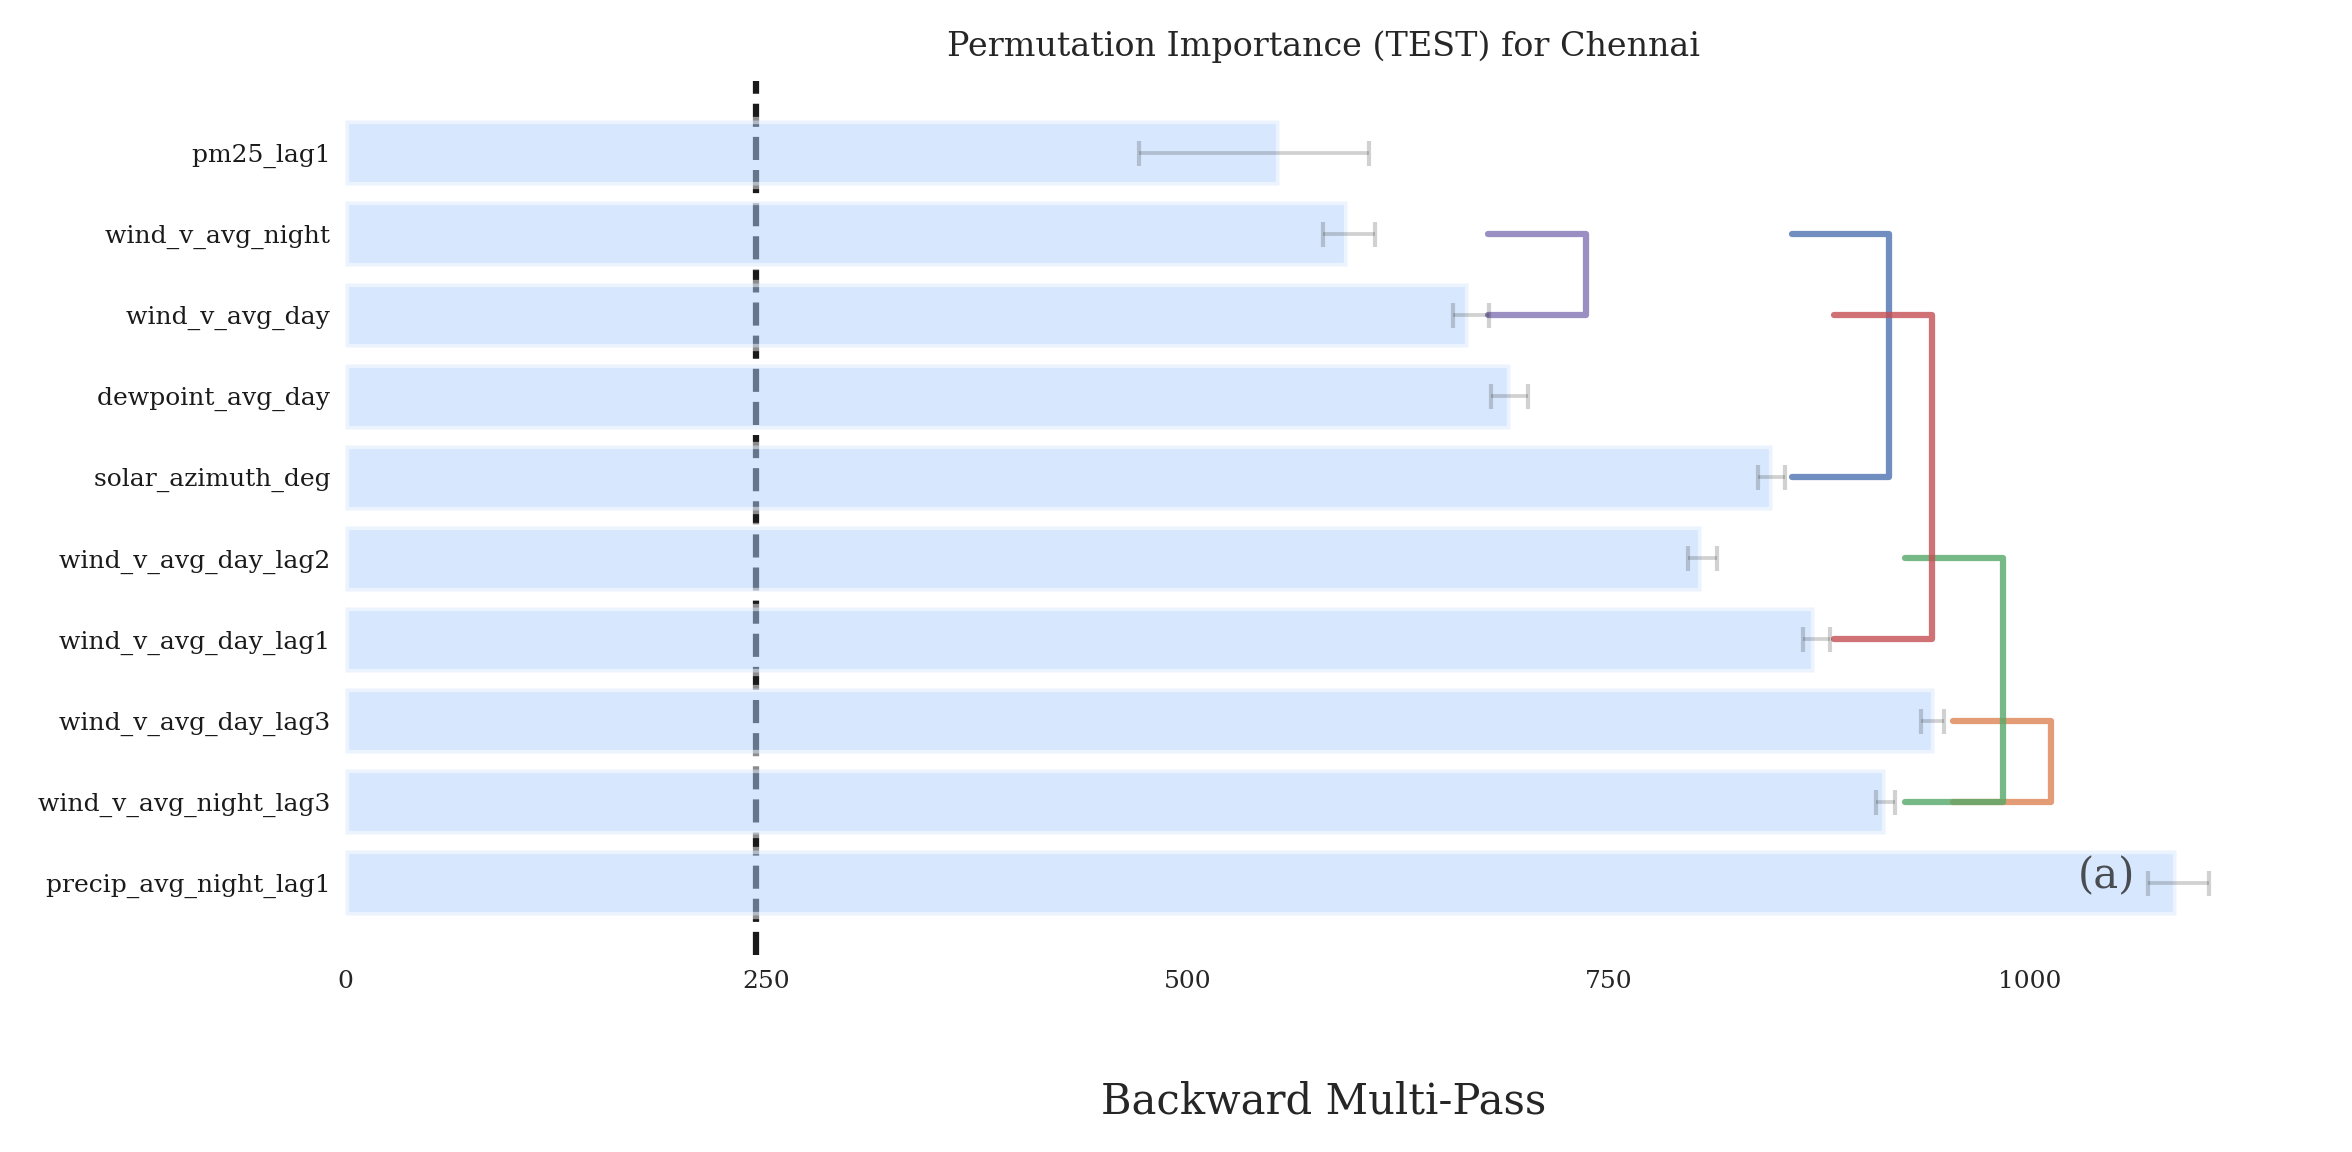

Running TEST permutation importance for New Delhi...


Perm. Imp.: 100%|██████████| 10/10 [07:43<00:00, 46.34s/it]


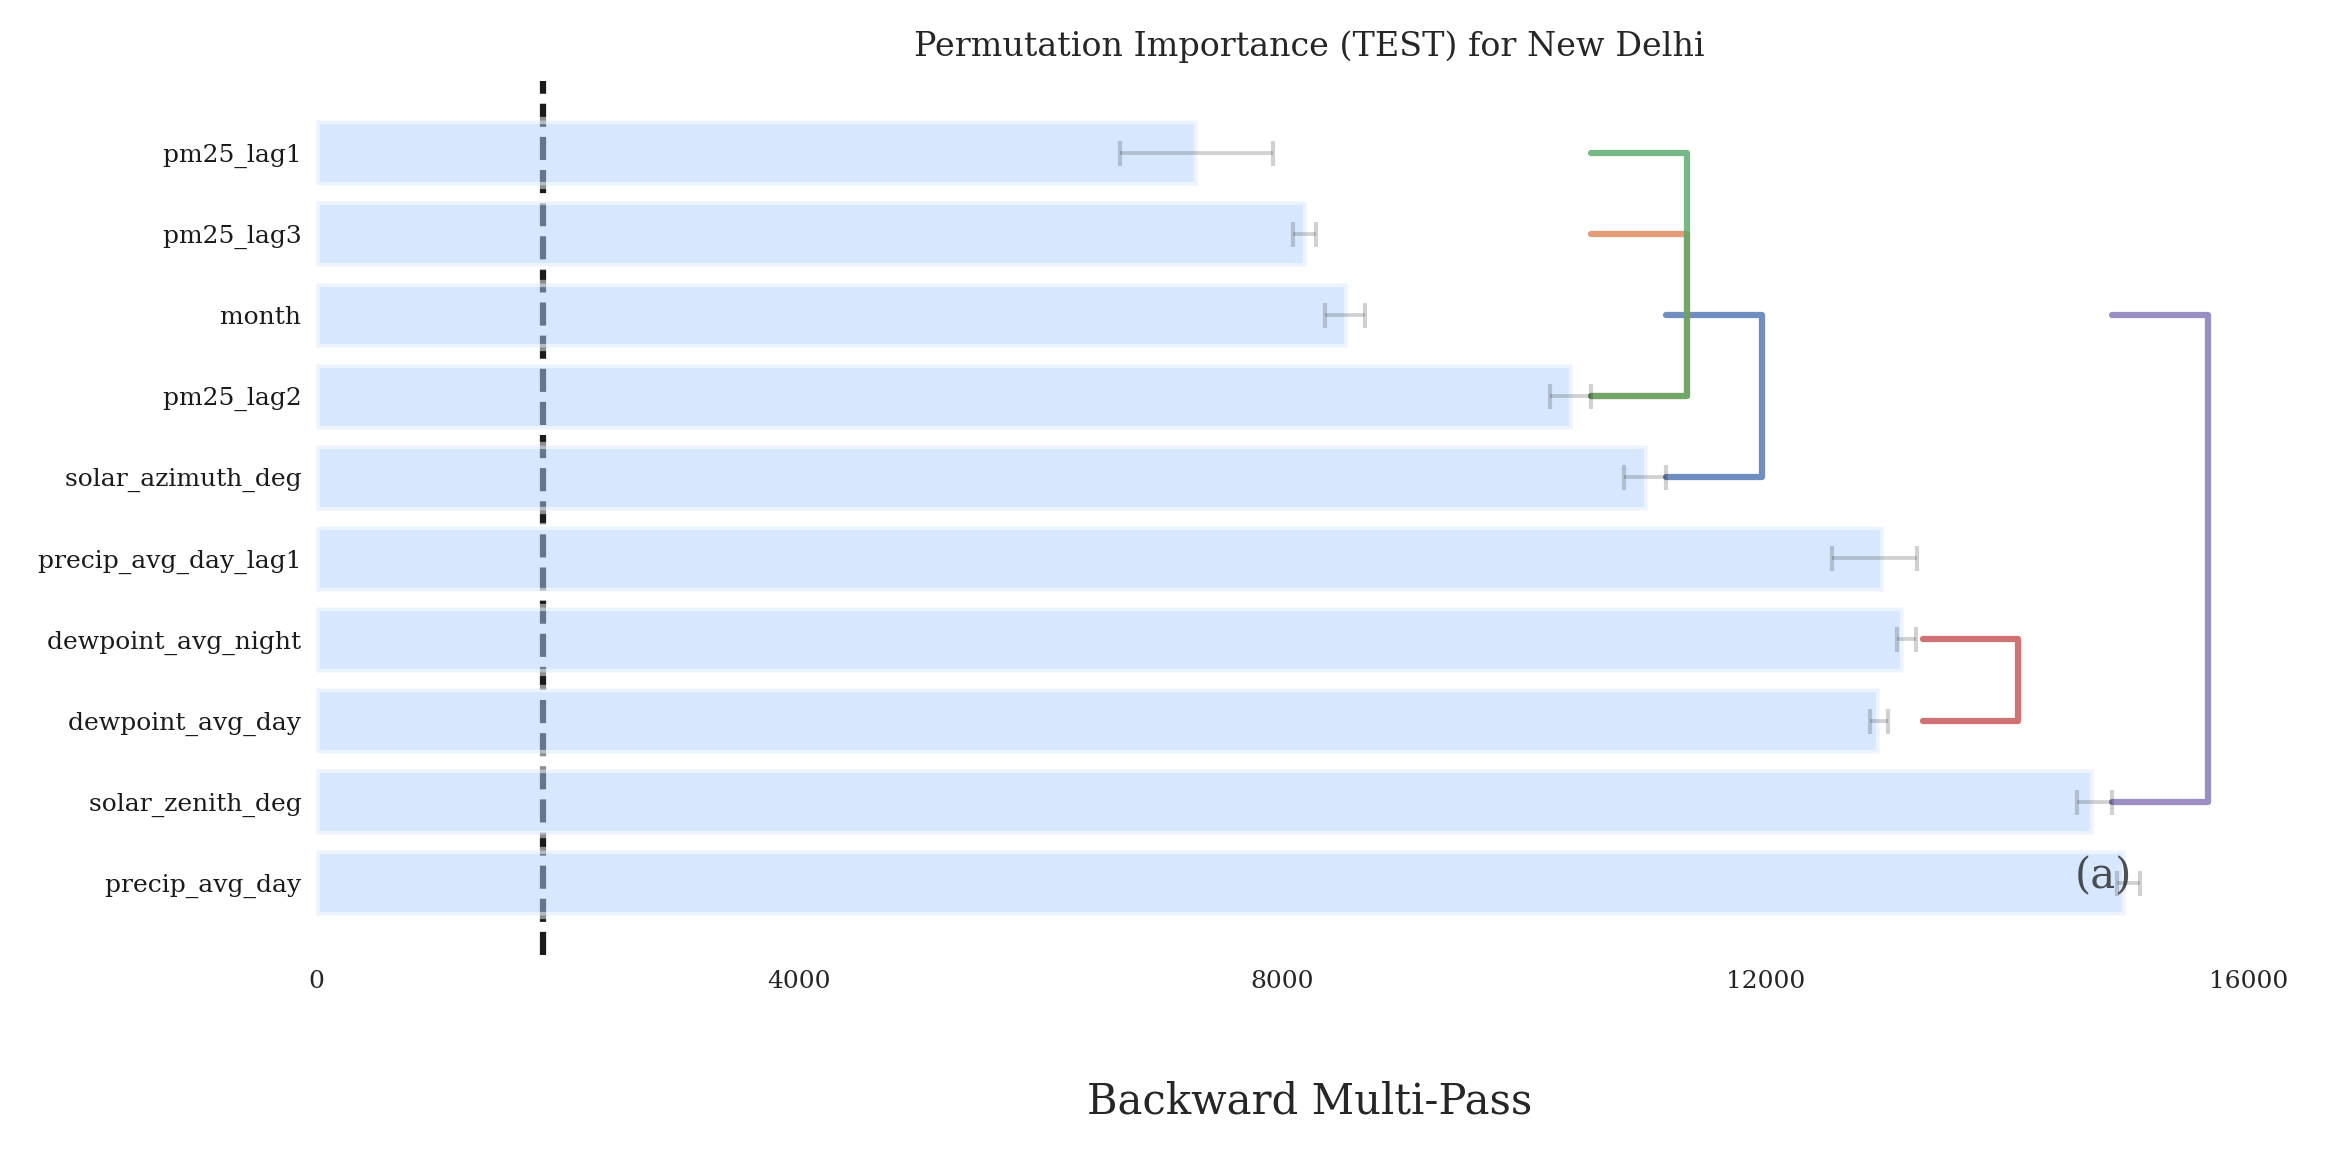

In [136]:
import os
# --- Build explainers on TEST data ---

test_explainers = {}
for city, cfg in city_configs.items():
    test_explainers[city] = skexplain.ExplainToolkit(
        estimators=[(f"{city}_model", final_models[city])],
        X=cfg["X_test"],
        y=cfg["y_test"]
    )

# --- Run backward multi-pass on TEST (use full test set -> subsample=None) ---
os.makedirs("Datasets/results_csv", exist_ok=True)

for city, explainer in test_explainers.items():
    print(f"Running TEST permutation importance for {city}...")

    test_results = explainer.permutation_importance(
        evaluation_fn='mse',
        n_vars=10,
        n_permute=30,
        direction='backward',
        n_jobs=8,
        random_seed=42,
        subsample=1.0,           # use all test rows for stability
        verbose=False
    )

    test_results.to_netcdf(f"Datasets/results_csv/{city}_perm_TEST.nc")

    # Plot (same styling as training)
    fig = explainer.plot_importance(
        data=test_results,
        panels=[('backward_multipass', f"{city}_model")],
        num_vars_to_plot=10,
        plot_correlated_features=True,
        rho_threshold=0.60,
        sort_vars=True,
        figsize=(8, 4)
    )
    plt.title(f"Permutation Importance (TEST) for {city}")
    plt.tight_layout()
    plt.show()


Local Explainability with SHAP

In [137]:
import shap
# Air quality analysis threshold based on WHO PM2.5 guidelines (µg/m³)
pm_threshold = 15.0  

def get_high_pollution_days(features, true_values, predictions, num_days=5):
    """
    Identify days with pollution levels above threshold.
    
    Args:
        features: DataFrame of input features (X_train)
        true_values: Array of actual PM2.5 measurements (y_train)
        predictions: Model's predicted PM2.5 values
        num_days: Number of highest pollution days to return
        
    Returns:
        Tuple of (high_pollution_features, high_pollution_actuals, high_pollution_predictions)
        or None if no days exceed threshold
    """
    is_high_pollution = predictions > pm_threshold
    if not is_high_pollution.any():
        return None, None, None
    
    # Get indices of top num_days with highest predictions
    top_indices = np.argsort(-predictions[is_high_pollution])[:num_days]
    
    return (
        features[is_high_pollution].iloc[top_indices],
        true_values[is_high_pollution].iloc[top_indices],
        predictions[is_high_pollution][top_indices]
    )

def analyze_city_pollution(city_name, pollution_model, training_features, true_pollution_values, num_cases=5):
    """
    Analyze and explain model predictions for highest pollution days in a city.
    
    Args:
        city_name: Name of city being analyzed
        pollution_model: Trained XGBoost model for the city
        training_features: X_train data
        true_pollution_values: y_train data
        num_cases: Number of high pollution cases to analyze
    """
    # Get model predictions for all training data
    predicted_pollution = pollution_model.predict(training_features)
    
    # Identify highest pollution days
    high_pollution_features, high_pollution_actuals, high_pollution_preds = get_high_pollution_days(
        training_features, true_pollution_values, predicted_pollution, num_cases
    )
    
    if high_pollution_features is None:
        print(f"{city_name}: No days exceed {pm_threshold} µg/m³ threshold")
        return

    # Initialize explainer for these specific high pollution days
    explainer = skexplain.ExplainToolkit(
        estimators=[(city_name, pollution_model)],
        X=high_pollution_features,  # Focus on high pollution cases
        y=high_pollution_actuals,
        feature_names=training_features.columns.tolist()
    )

    # Configure SHAP explainer with proper background distribution
    shap_config = {
        "masker": shap.maskers.Partition(
            training_features,  # Full training set for proper baseline
            max_samples=100,   # Balance between accuracy and speed
            clustering="correlation"  # Account for feature dependencies
        ),
        "algorithm": "auto"  # Automatically selects best method for XGBoost
    }

    # Compute SHAP values for our high pollution cases
    explanation_data = explainer.local_attributions(
        method=["shap"], 
        shap_kws=shap_config
    )
    
    # Prepare keys for accessing SHAP results
    shap_values_key = f"shap_values__{city_name}"
    baseline_key = f"shap_bias__{city_name}"

    # Generate explanation plots for each high pollution day
    for case_idx in range(len(high_pollution_features)):
        # Prepare data structure for plotting
        case_explanation = xr.Dataset(
            {
                shap_values_key: (["cases", "features"], [explanation_data[shap_values_key][case_idx].values]),
                baseline_key: (["cases"], [explanation_data[baseline_key][case_idx].item()]),
                "X": (["cases", "features"], [high_pollution_features.iloc[case_idx].values])
            },
            coords={
                "cases": [0],  # Single case per plot
                "features": training_features.columns.tolist()
            },
            attrs=explanation_data.attrs  # Maintain original metadata
        )

        # Create the explanation plot
        fig, _ = explainer.plot_contributions(
            contrib=case_explanation,
            estimator_names=city_name,
            features=training_features.columns.tolist(),
            show_baseline=True,  # Display expected model output
            figsize=(10, 6)      # Appropriate size for readability
        )
        
        # Add descriptive title with actual vs predicted values
        plt.suptitle(
            f"{city_name} | High Pollution Case #{case_idx+1}\n"
            f"Actual PM2.5: {high_pollution_actuals.iloc[case_idx]:.1f} µg/m³ | "
            f"Predicted: {high_pollution_preds[case_idx]:.1f} µg/m³",
            y=1.05, 
            fontsize=14
        )
        plt.tight_layout()
        plt.show()

def analyze_all_cities(city_models, city_training_data, num_cases=5):
    """
    Analyze high pollution days across all cities.
    
    Args:
        city_models: Dictionary of {city_name: trained_model}
        city_training_data: Dictionary of {city_name: {"X_train": ..., "y_train": ...}}
        num_cases: Number of high pollution cases to analyze per city
    """
    for city_name, model in city_models.items():
        analyze_city_pollution(
            city_name, 
            model, 
            city_training_data[city_name]["X_train"], 
            city_training_data[city_name]["y_train"], 
            num_cases
        )

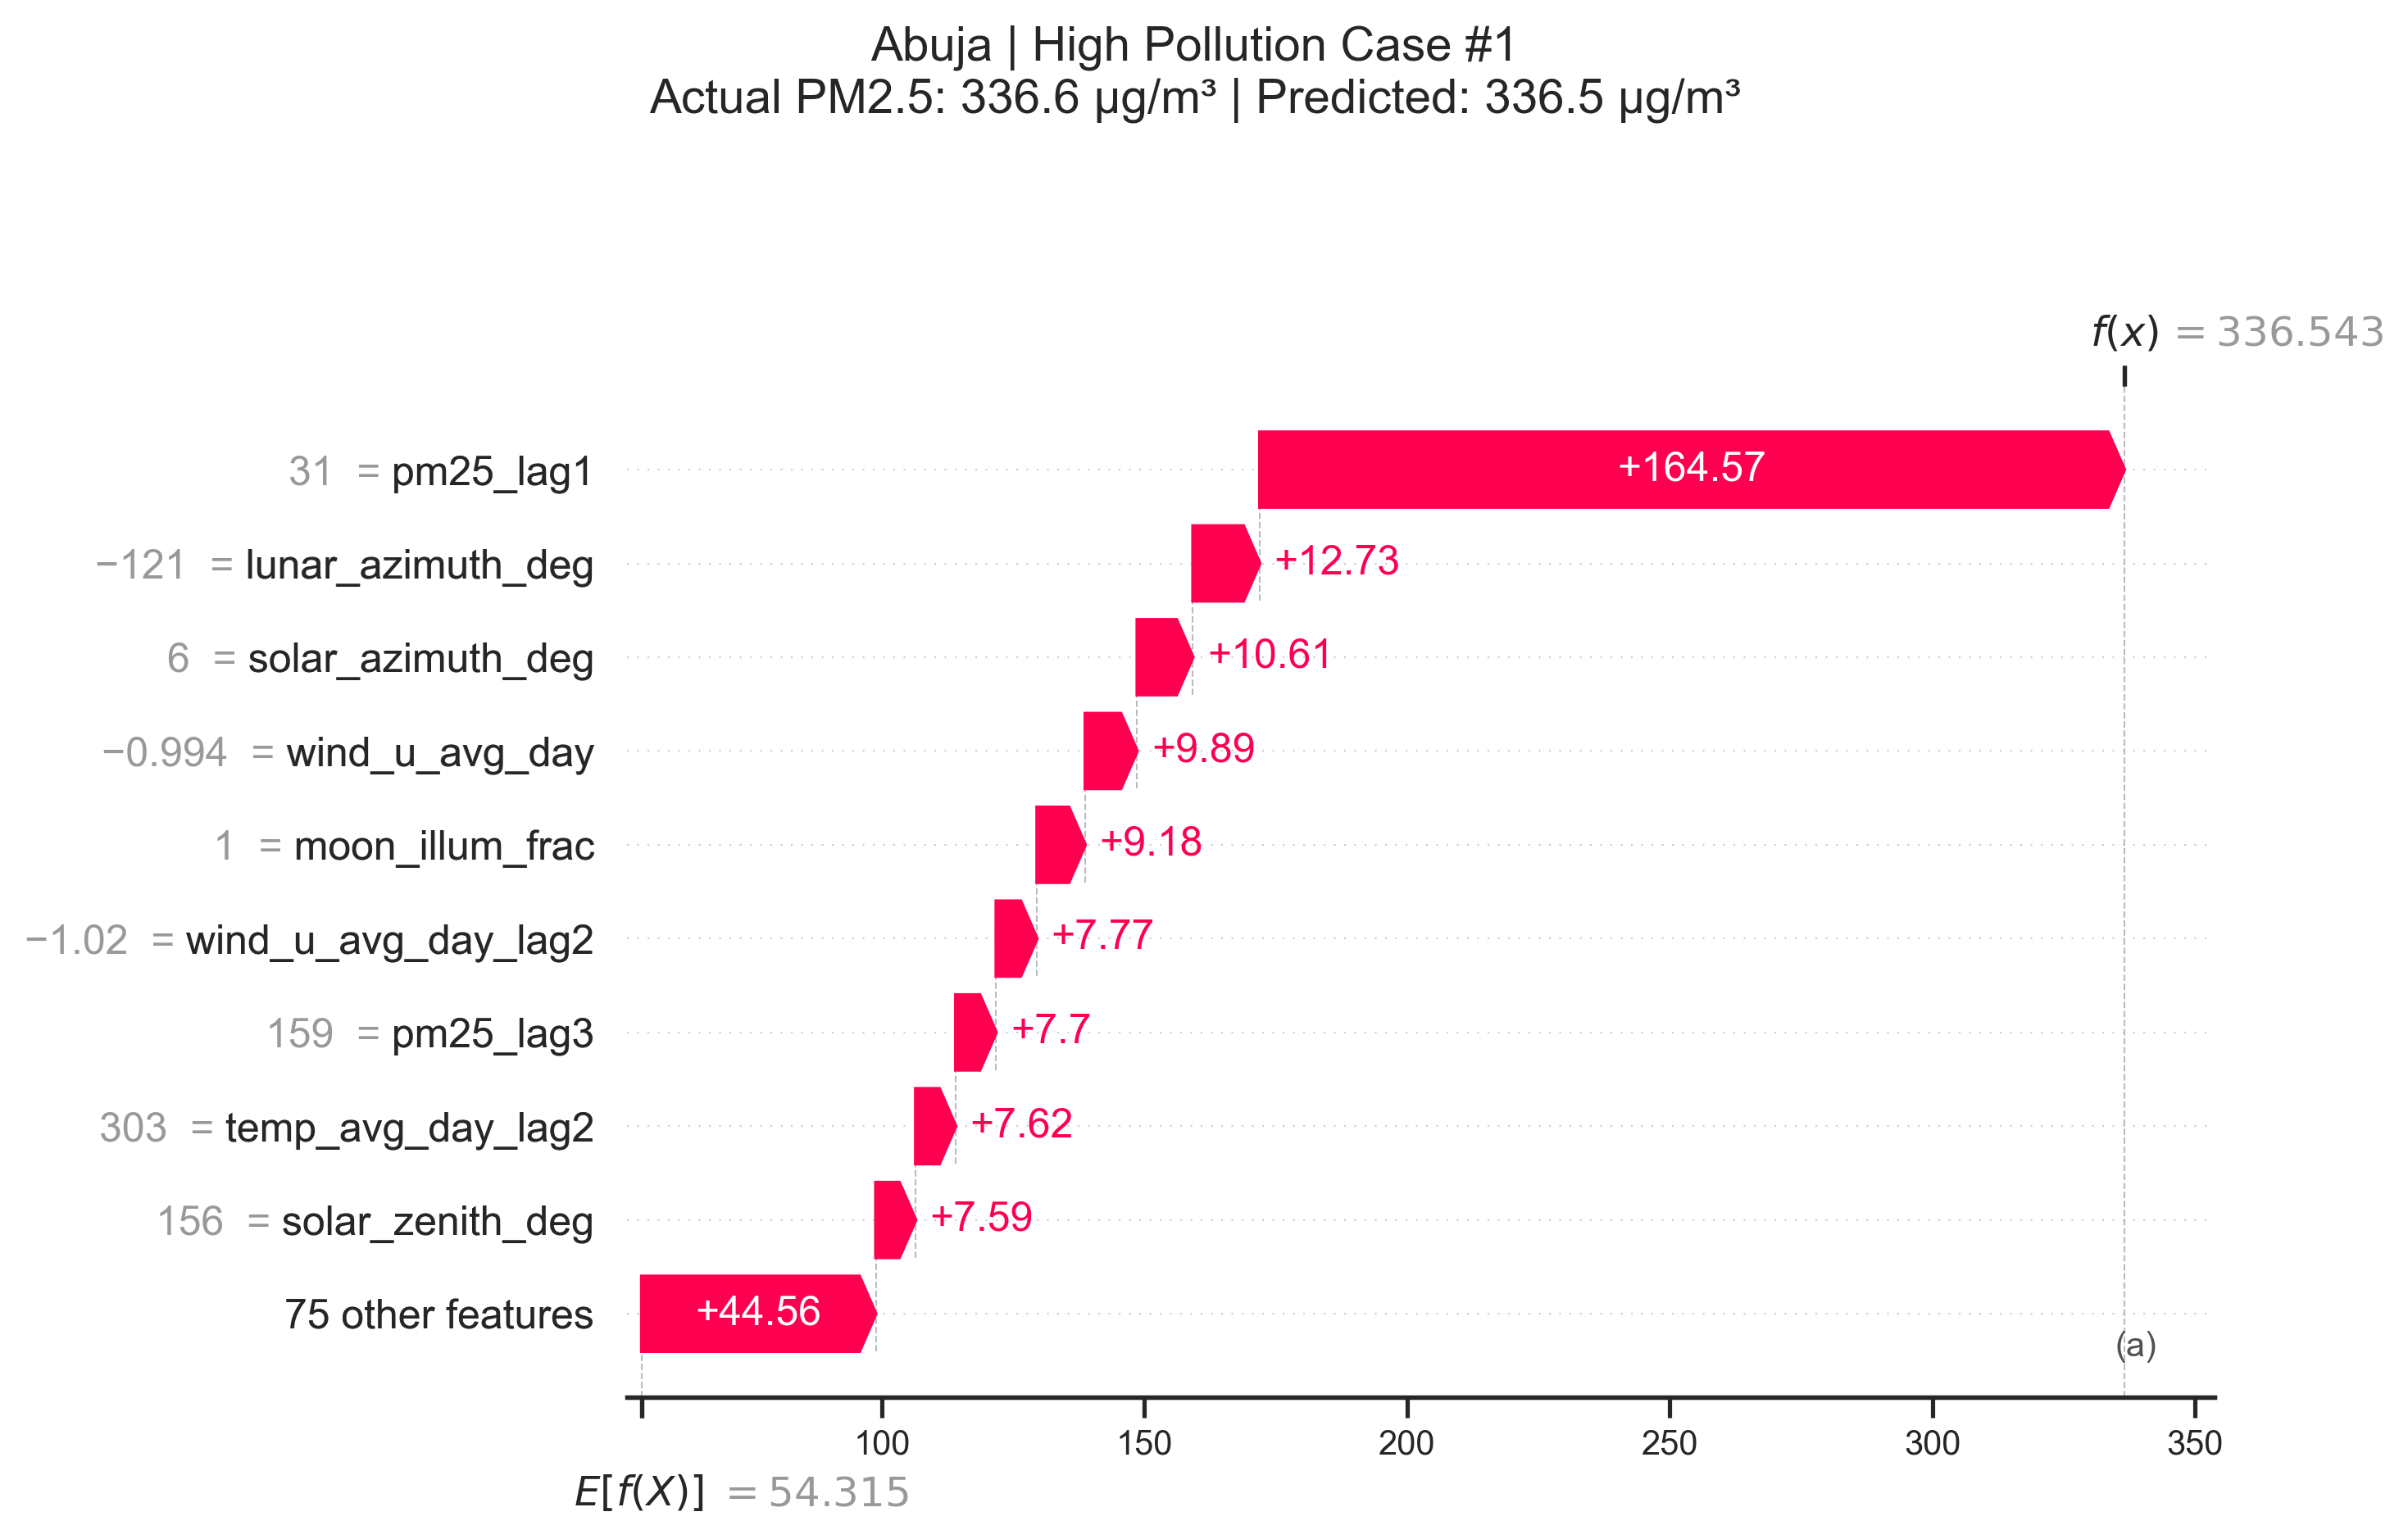

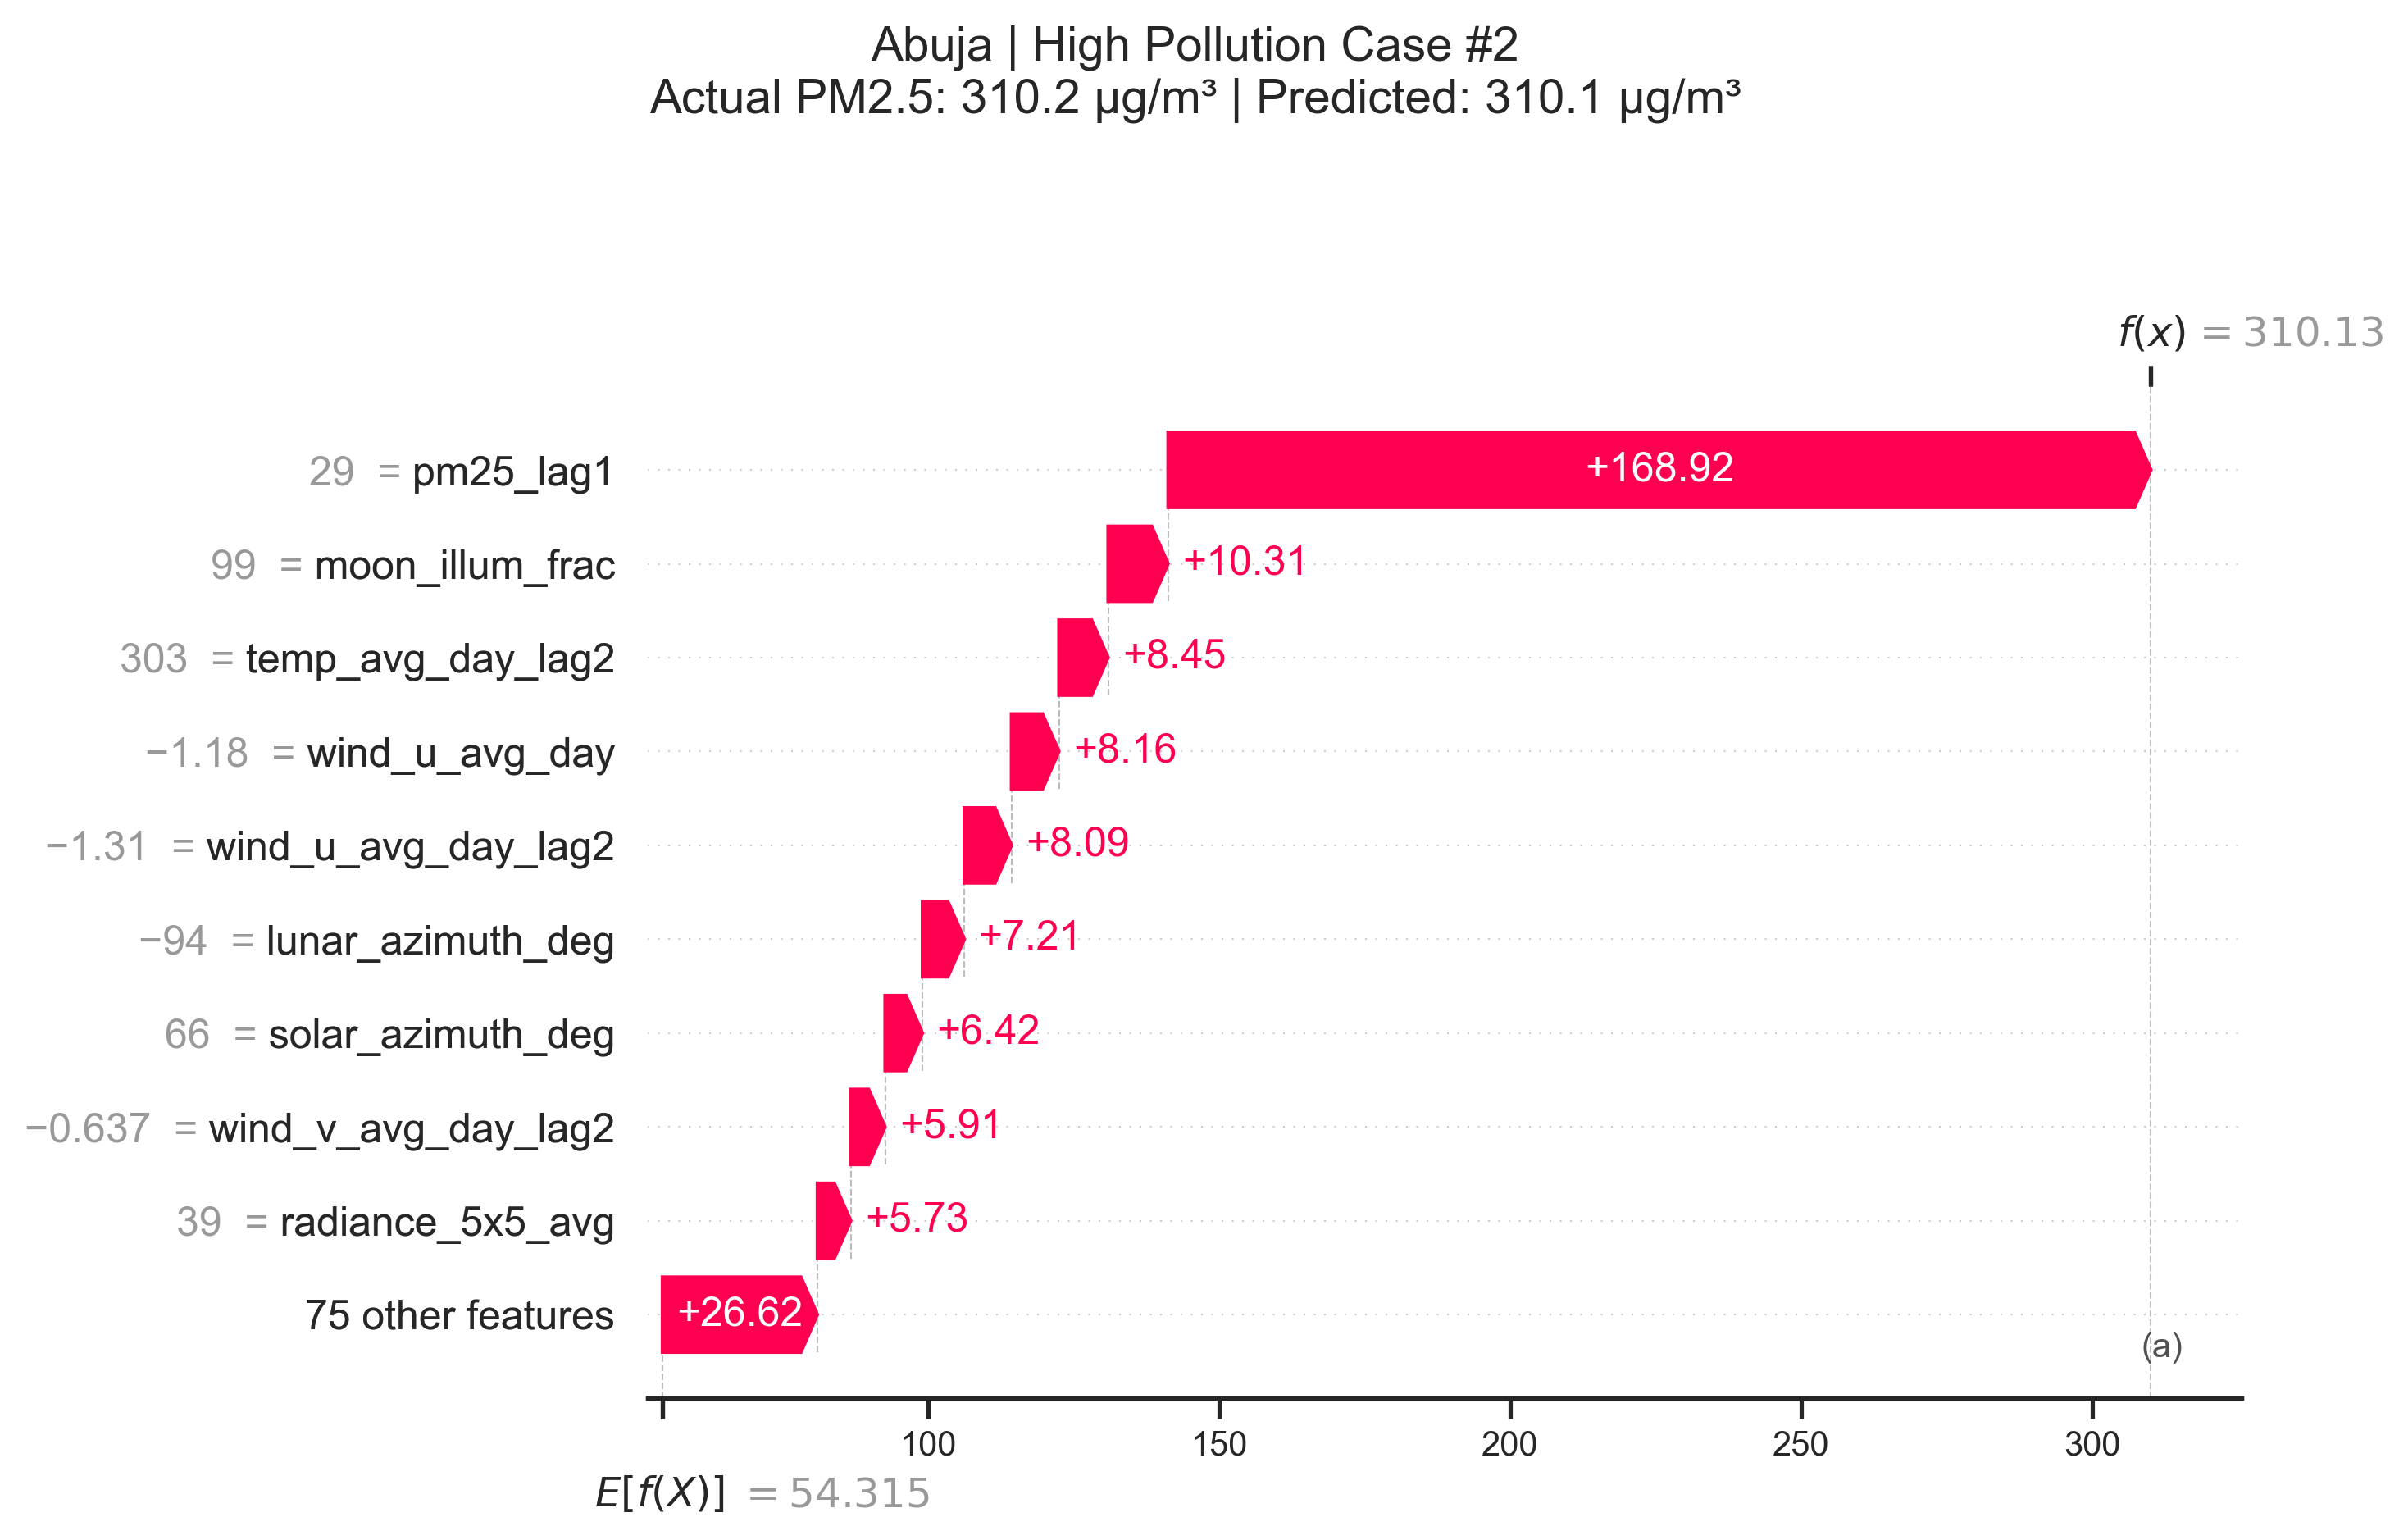

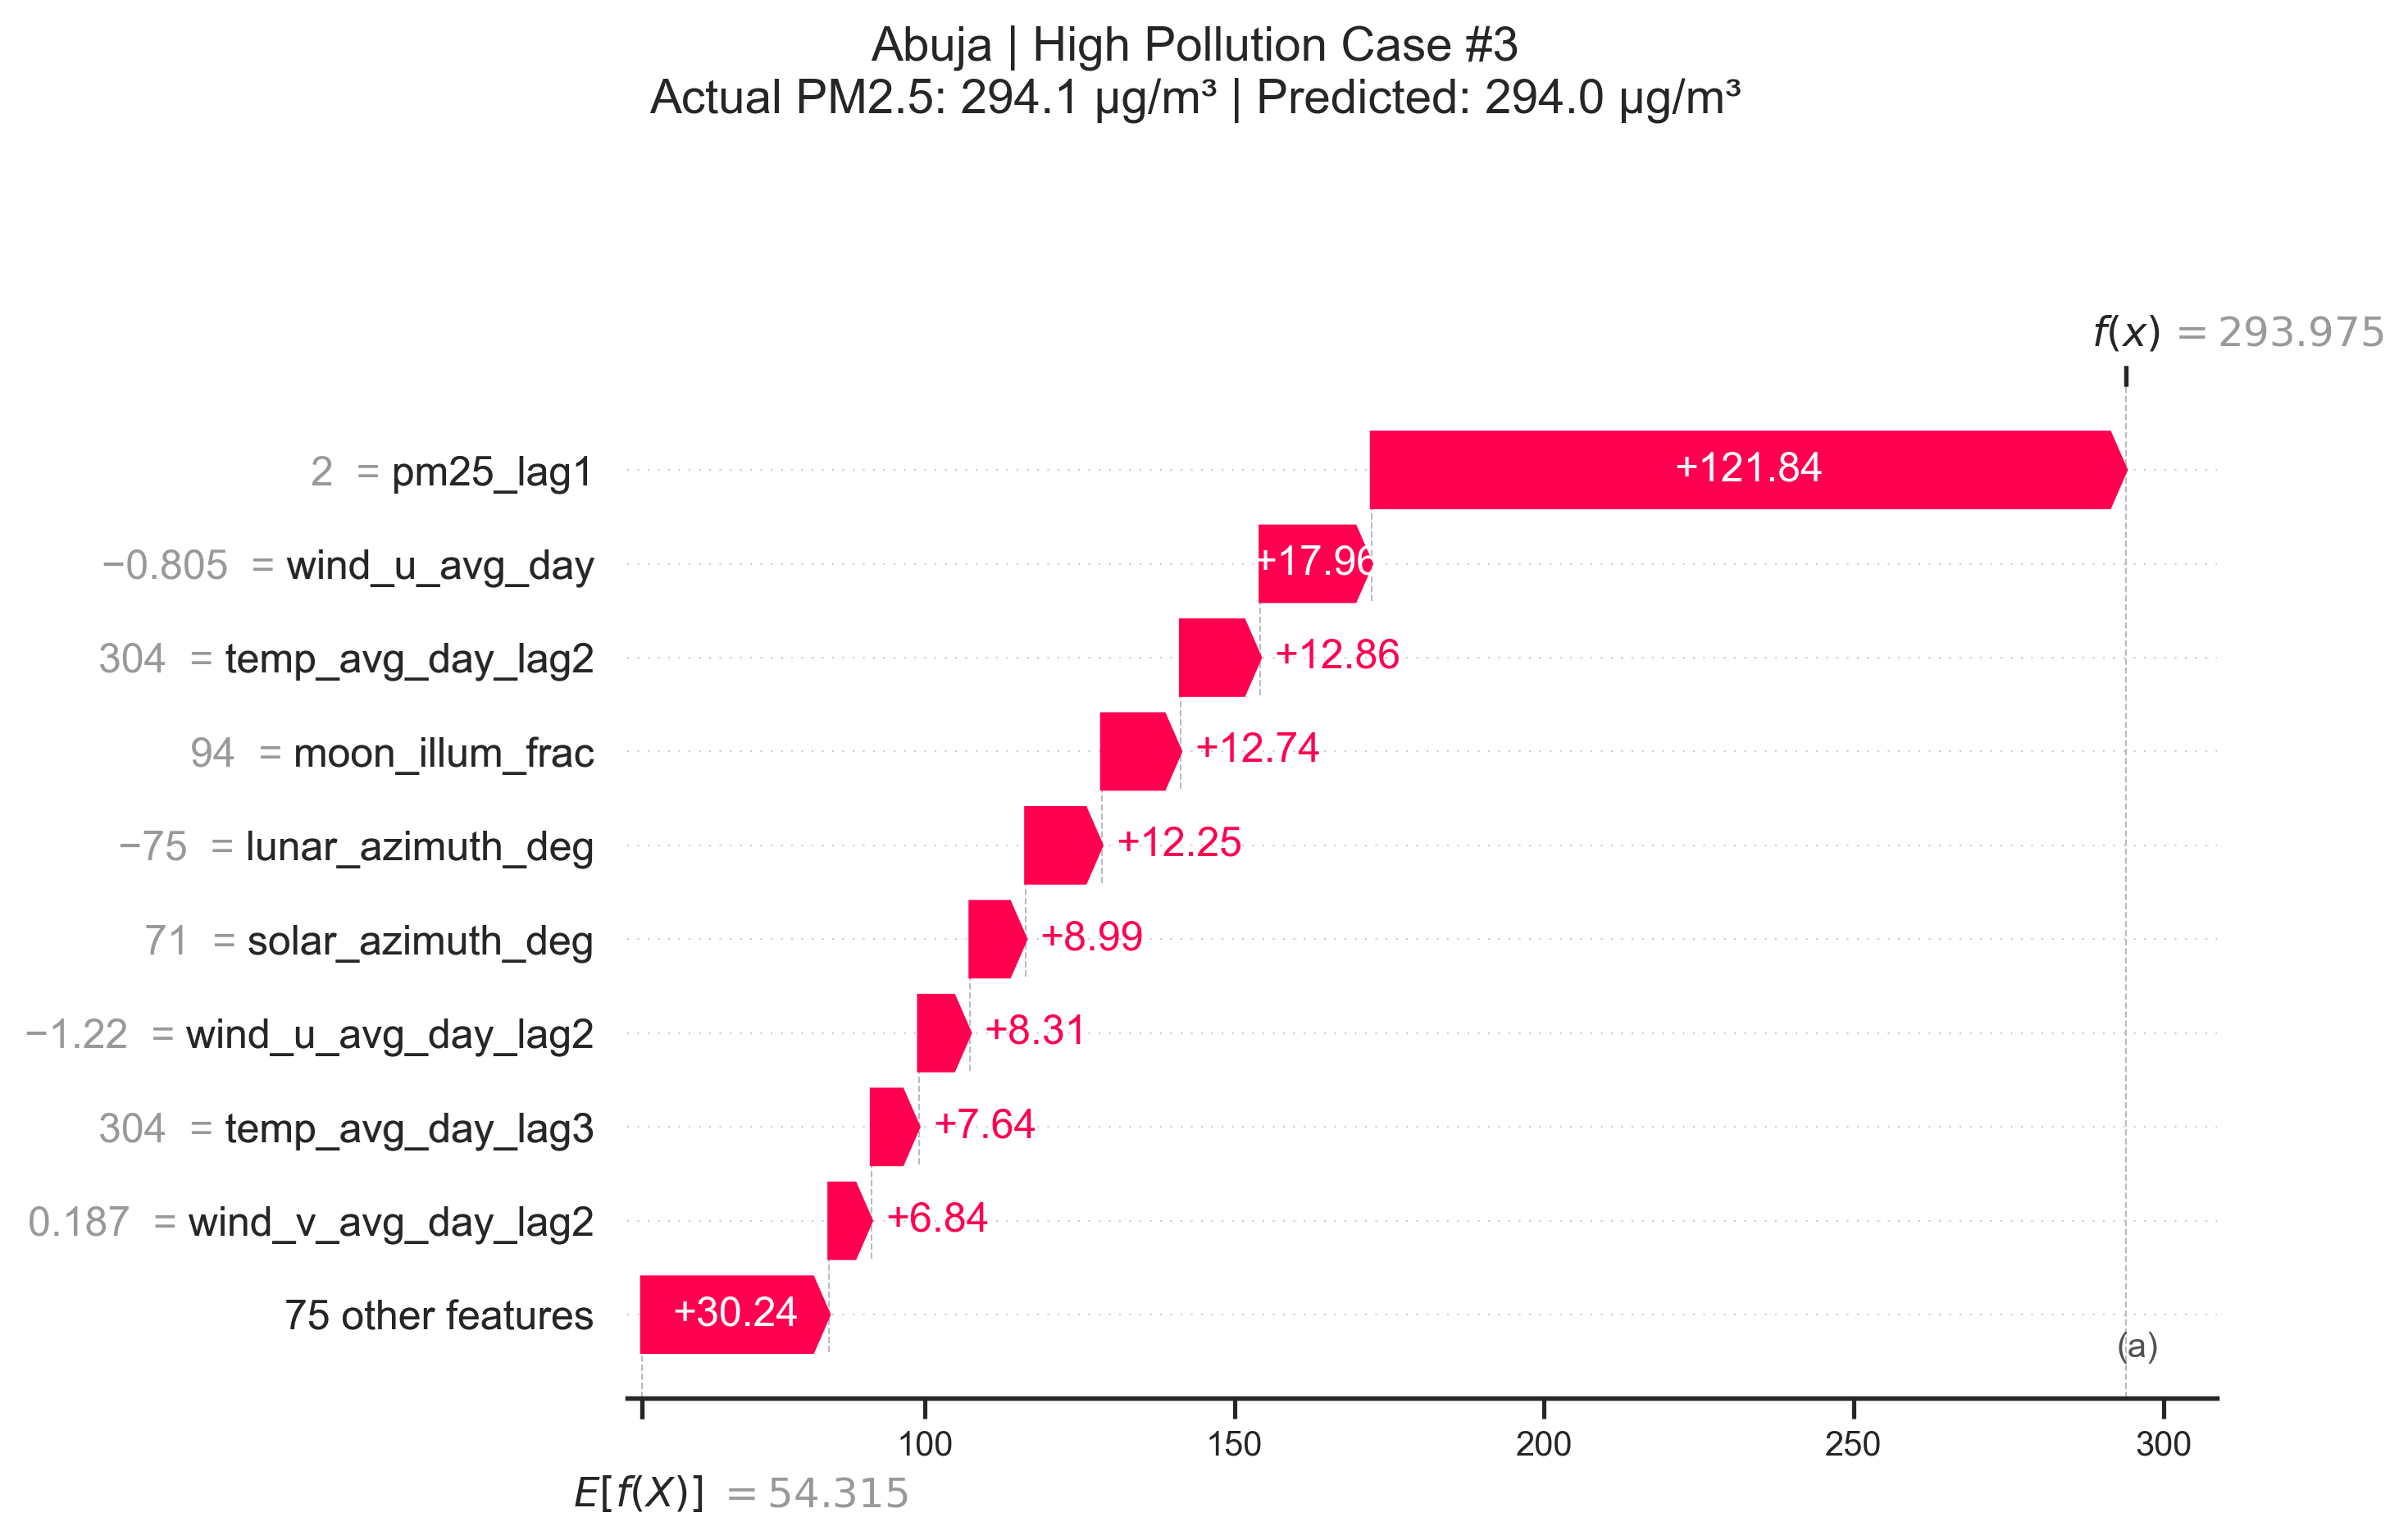

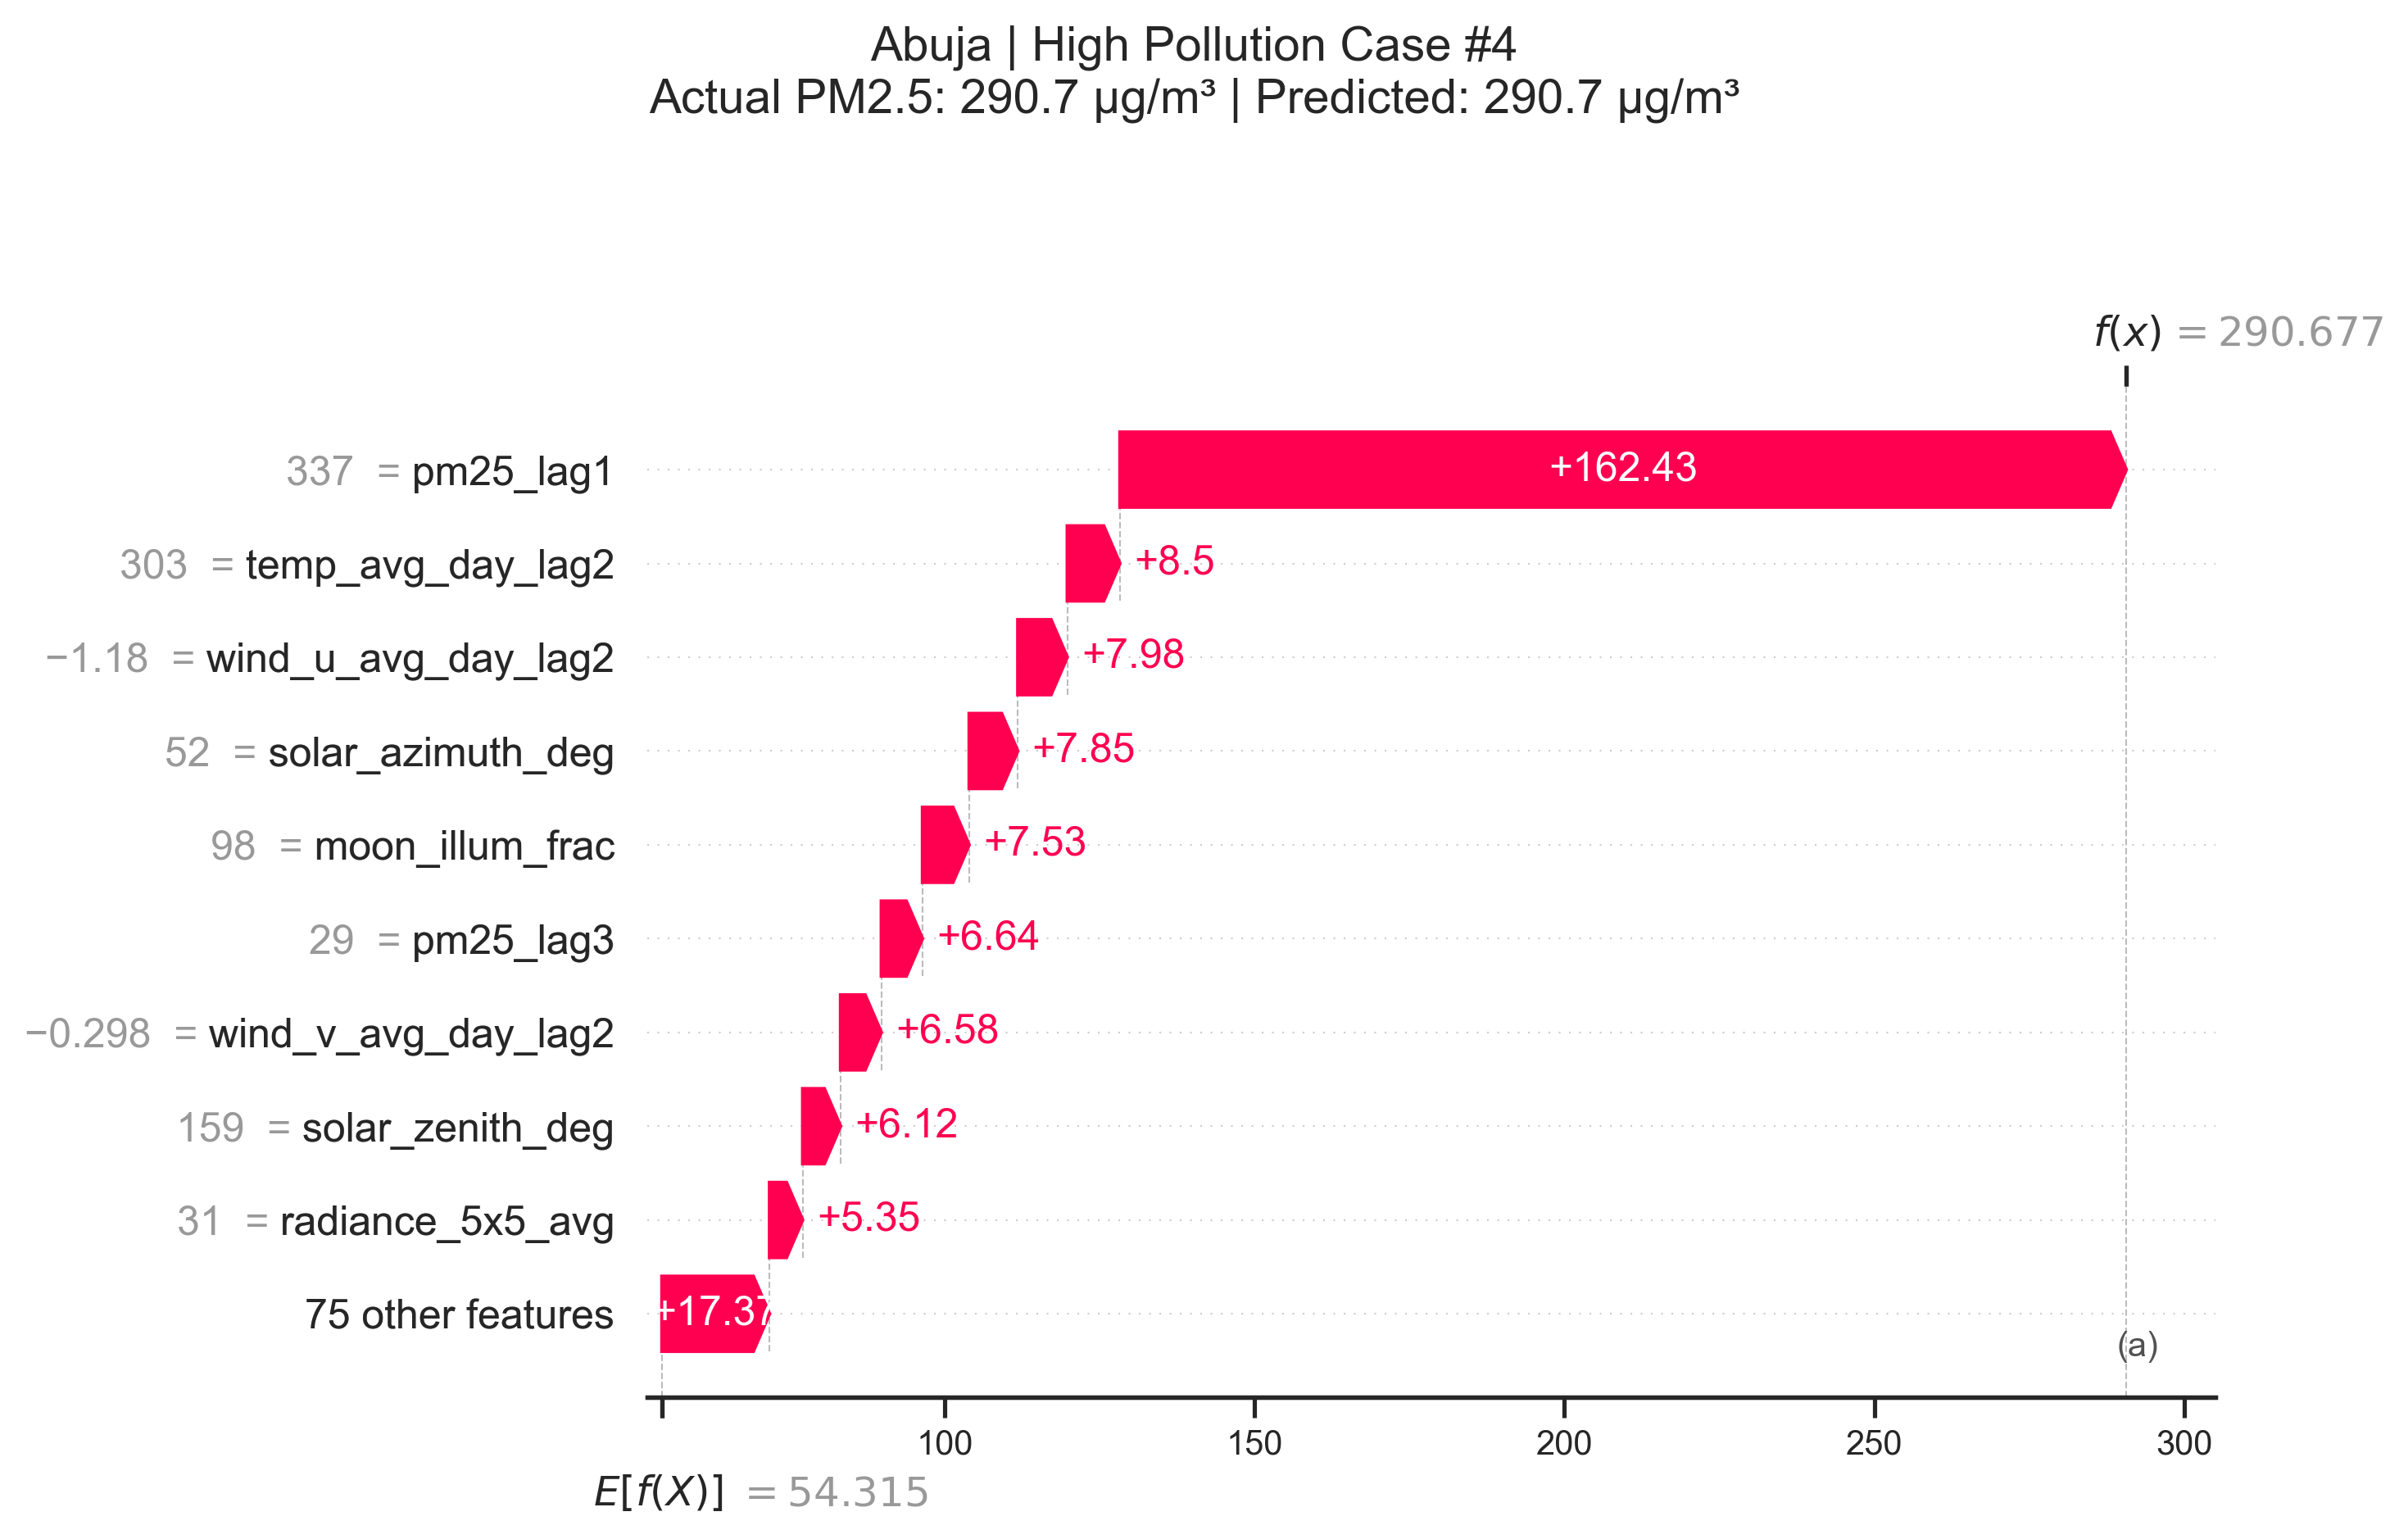

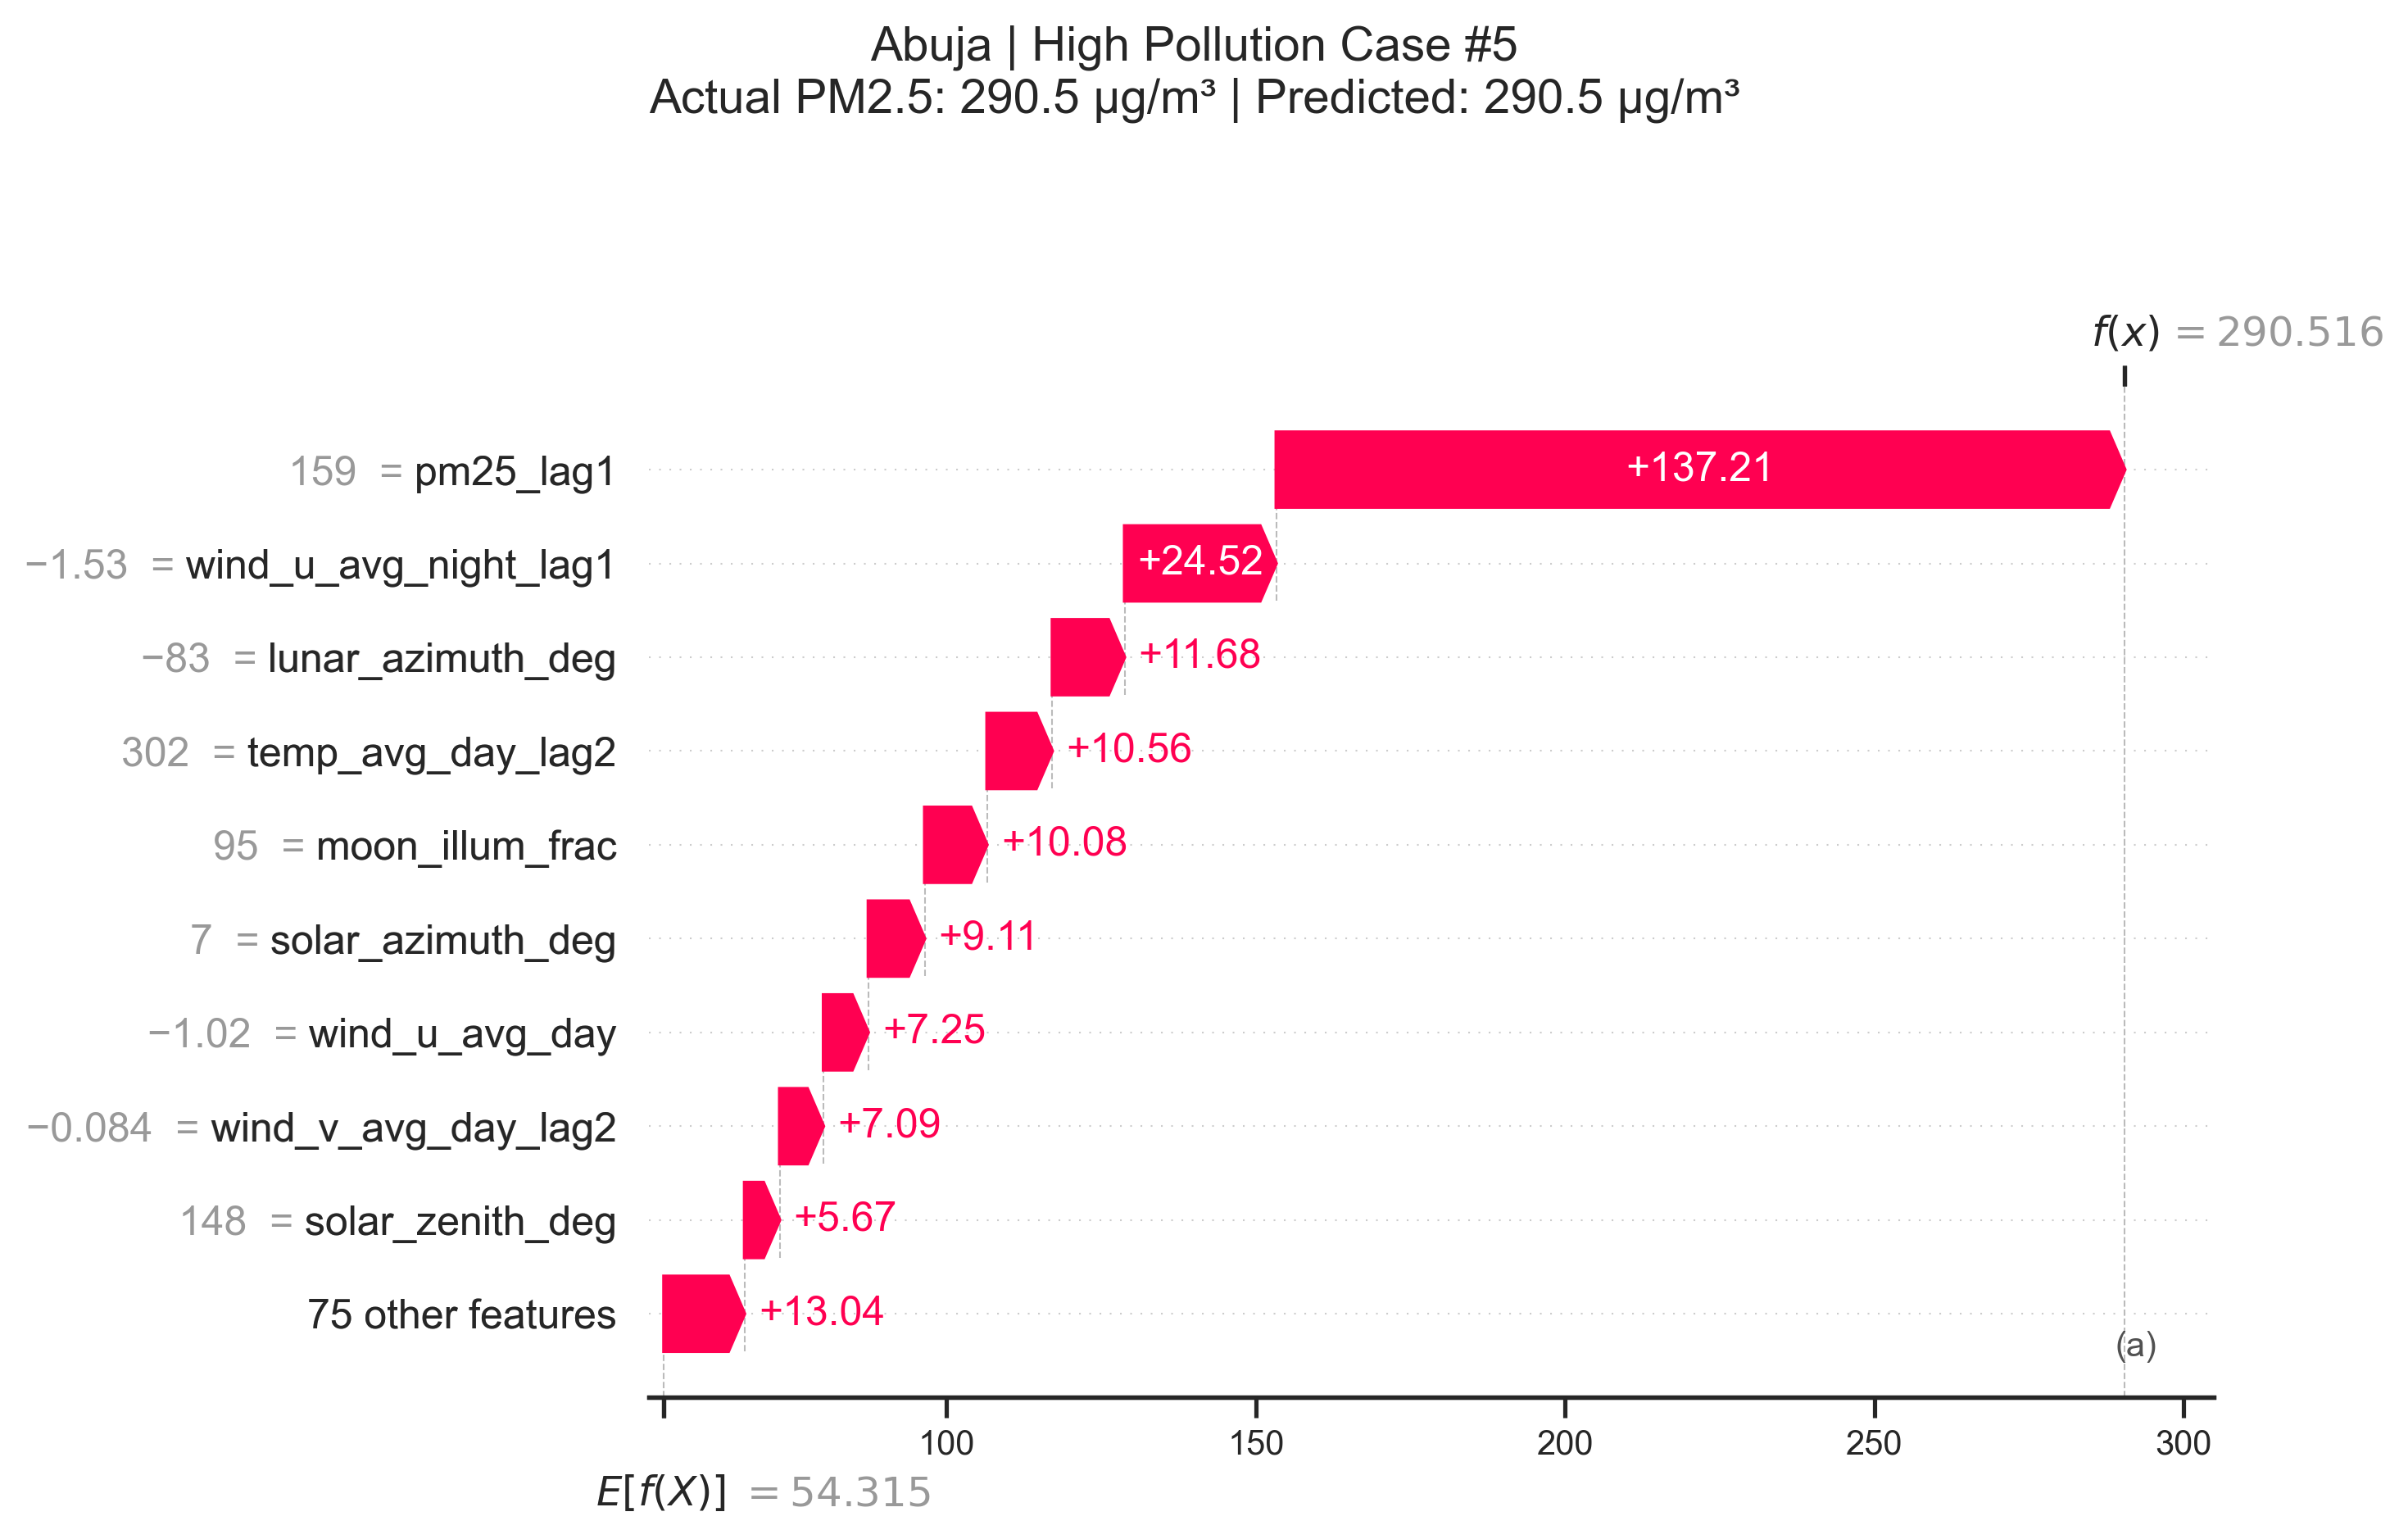

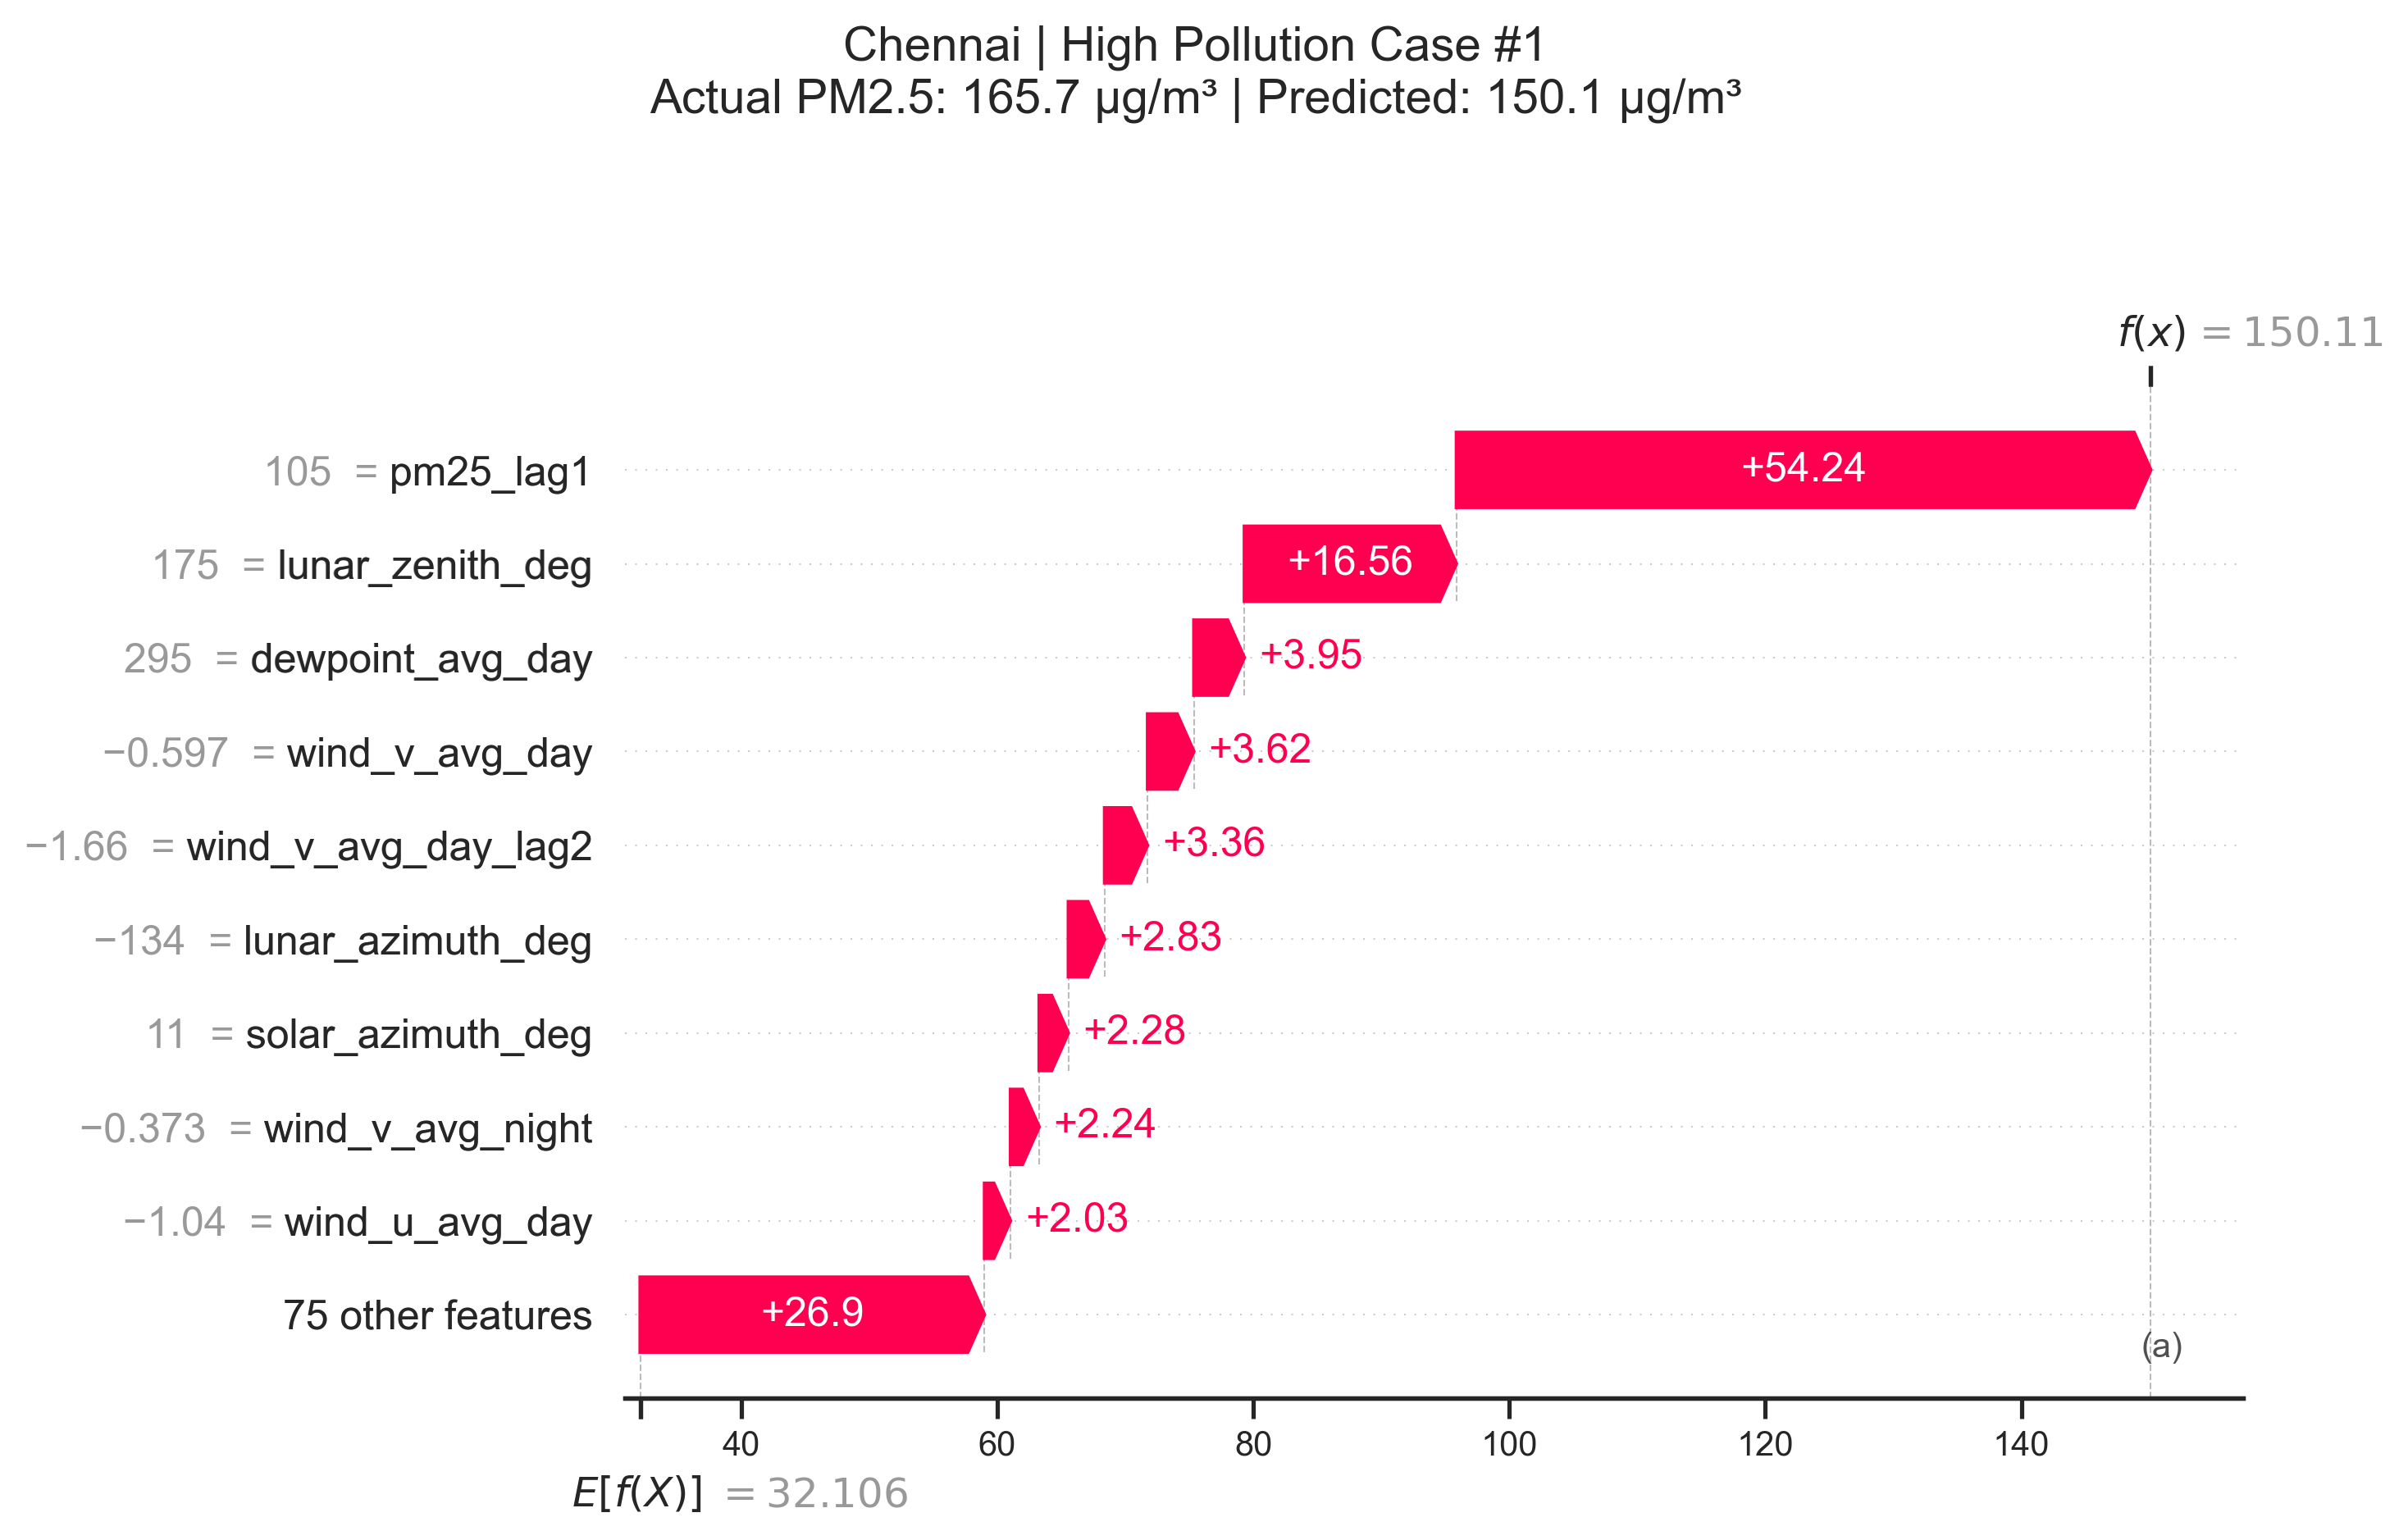

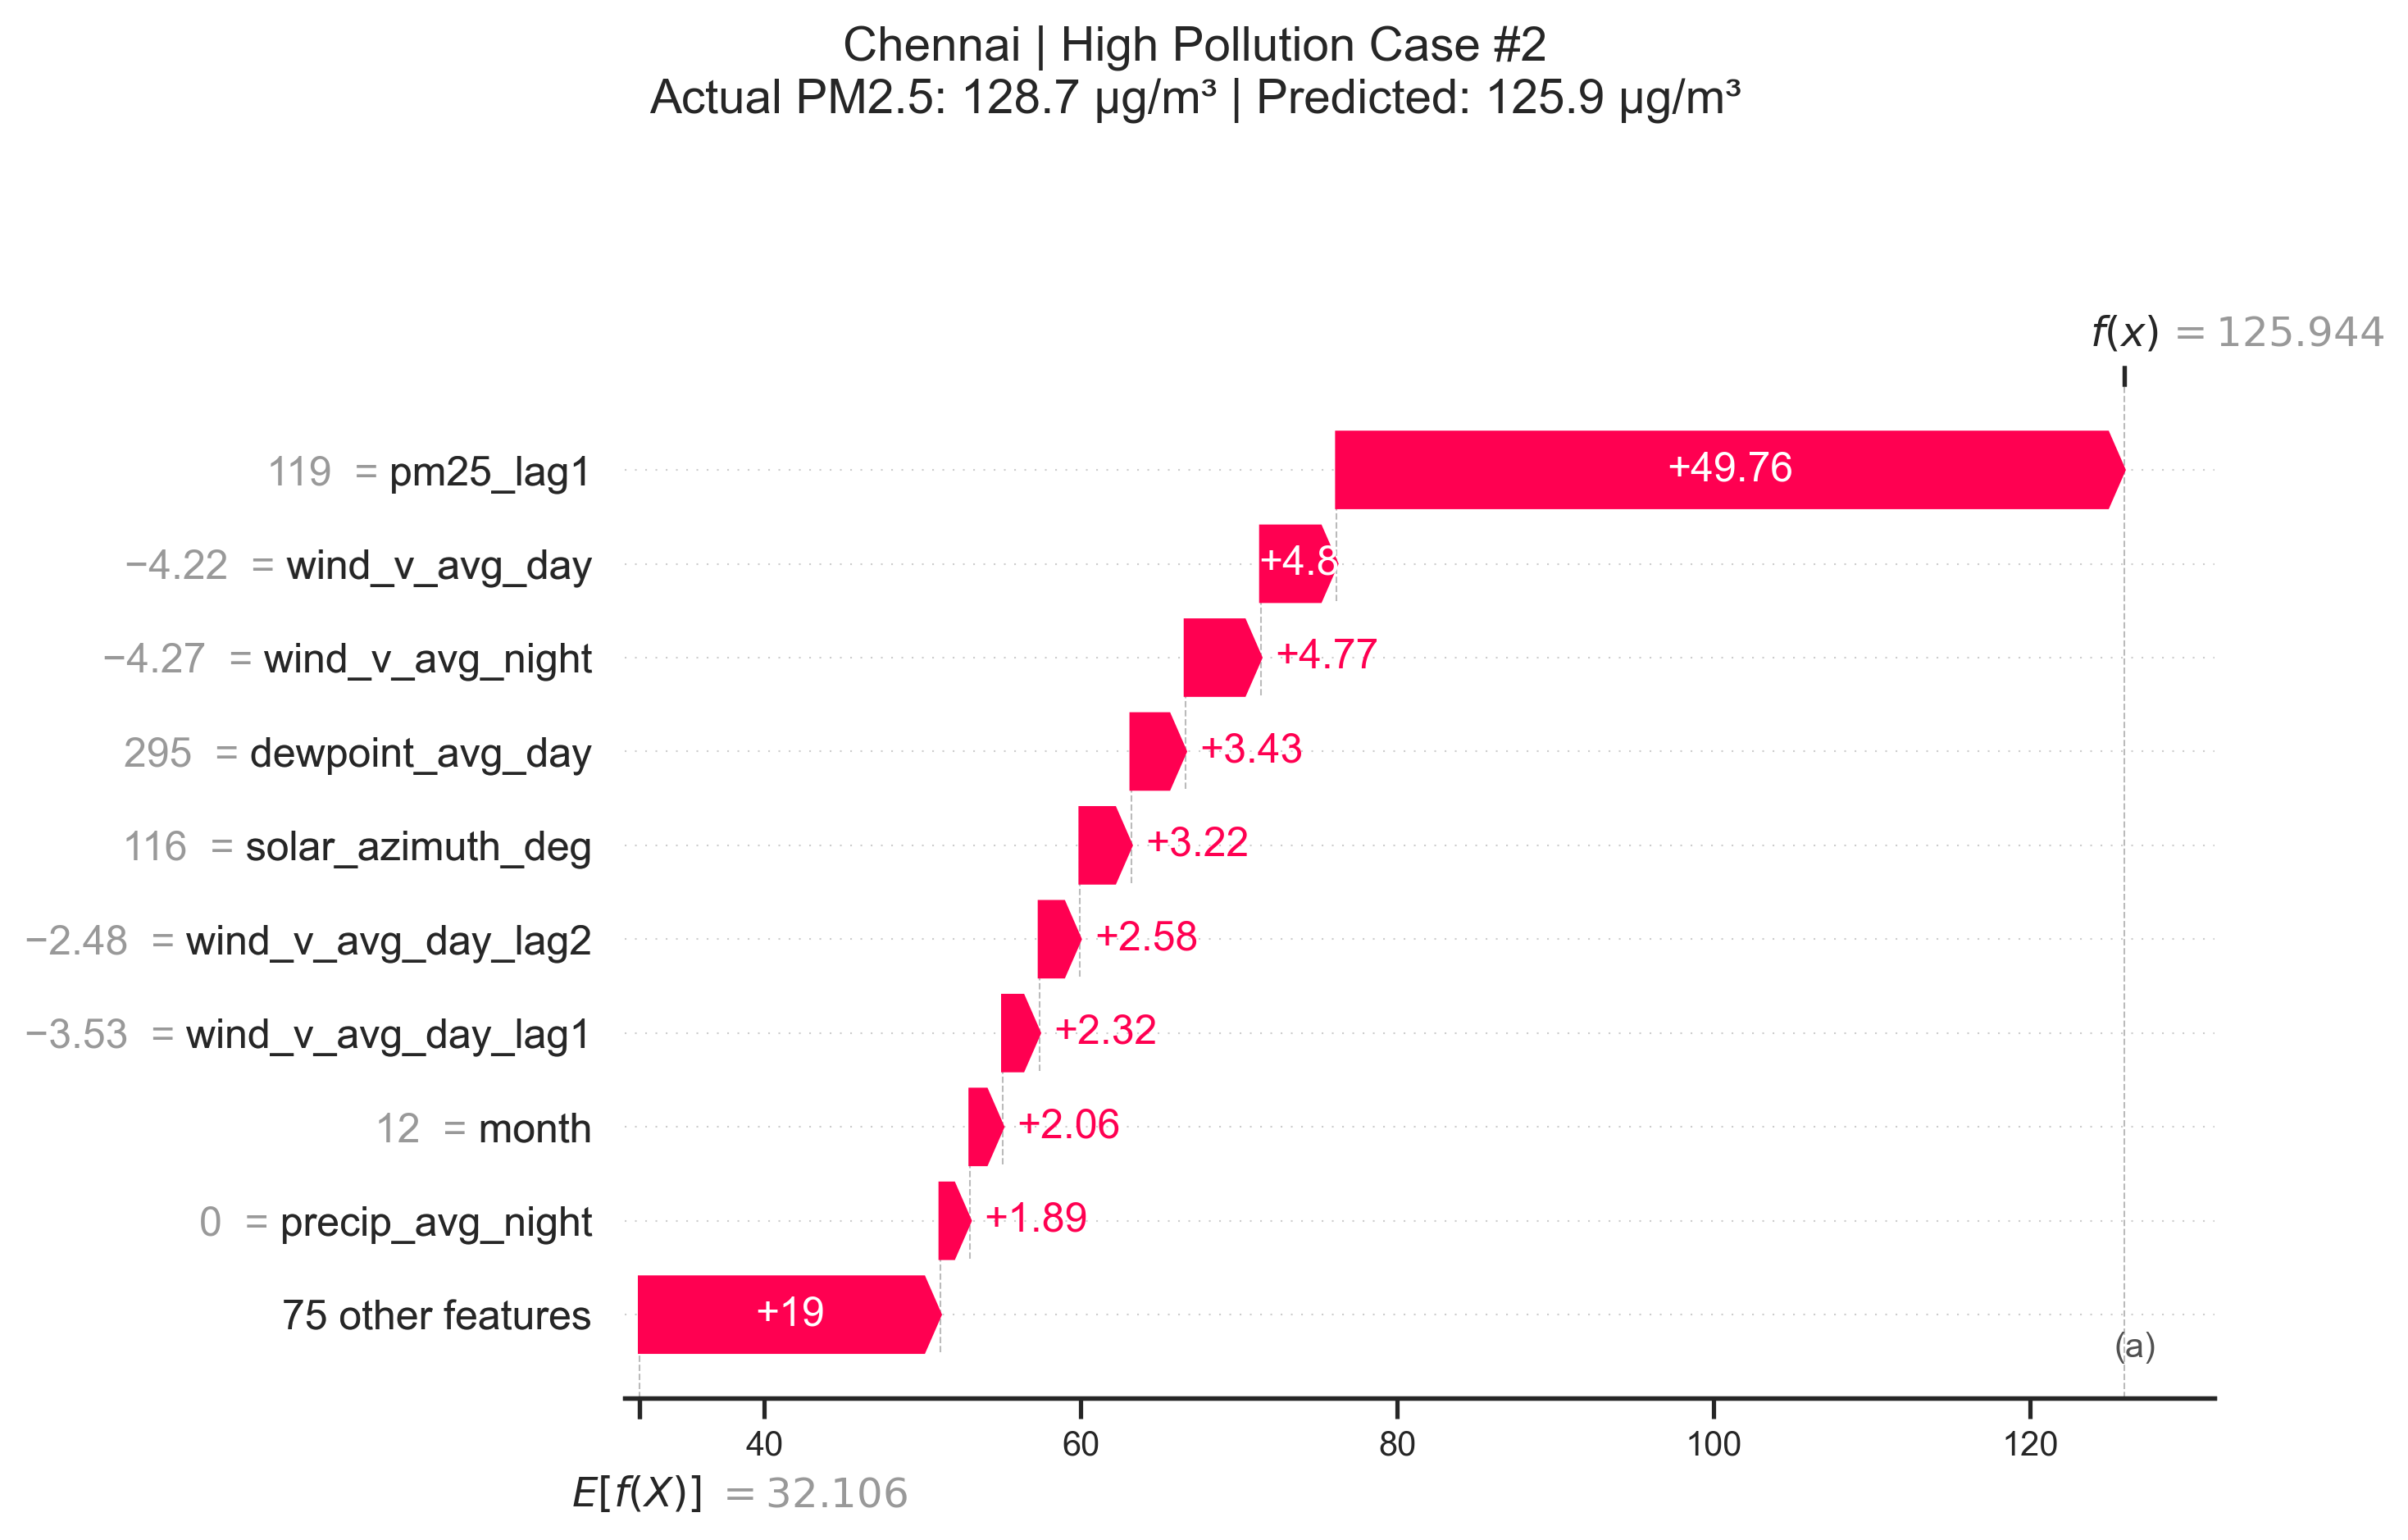

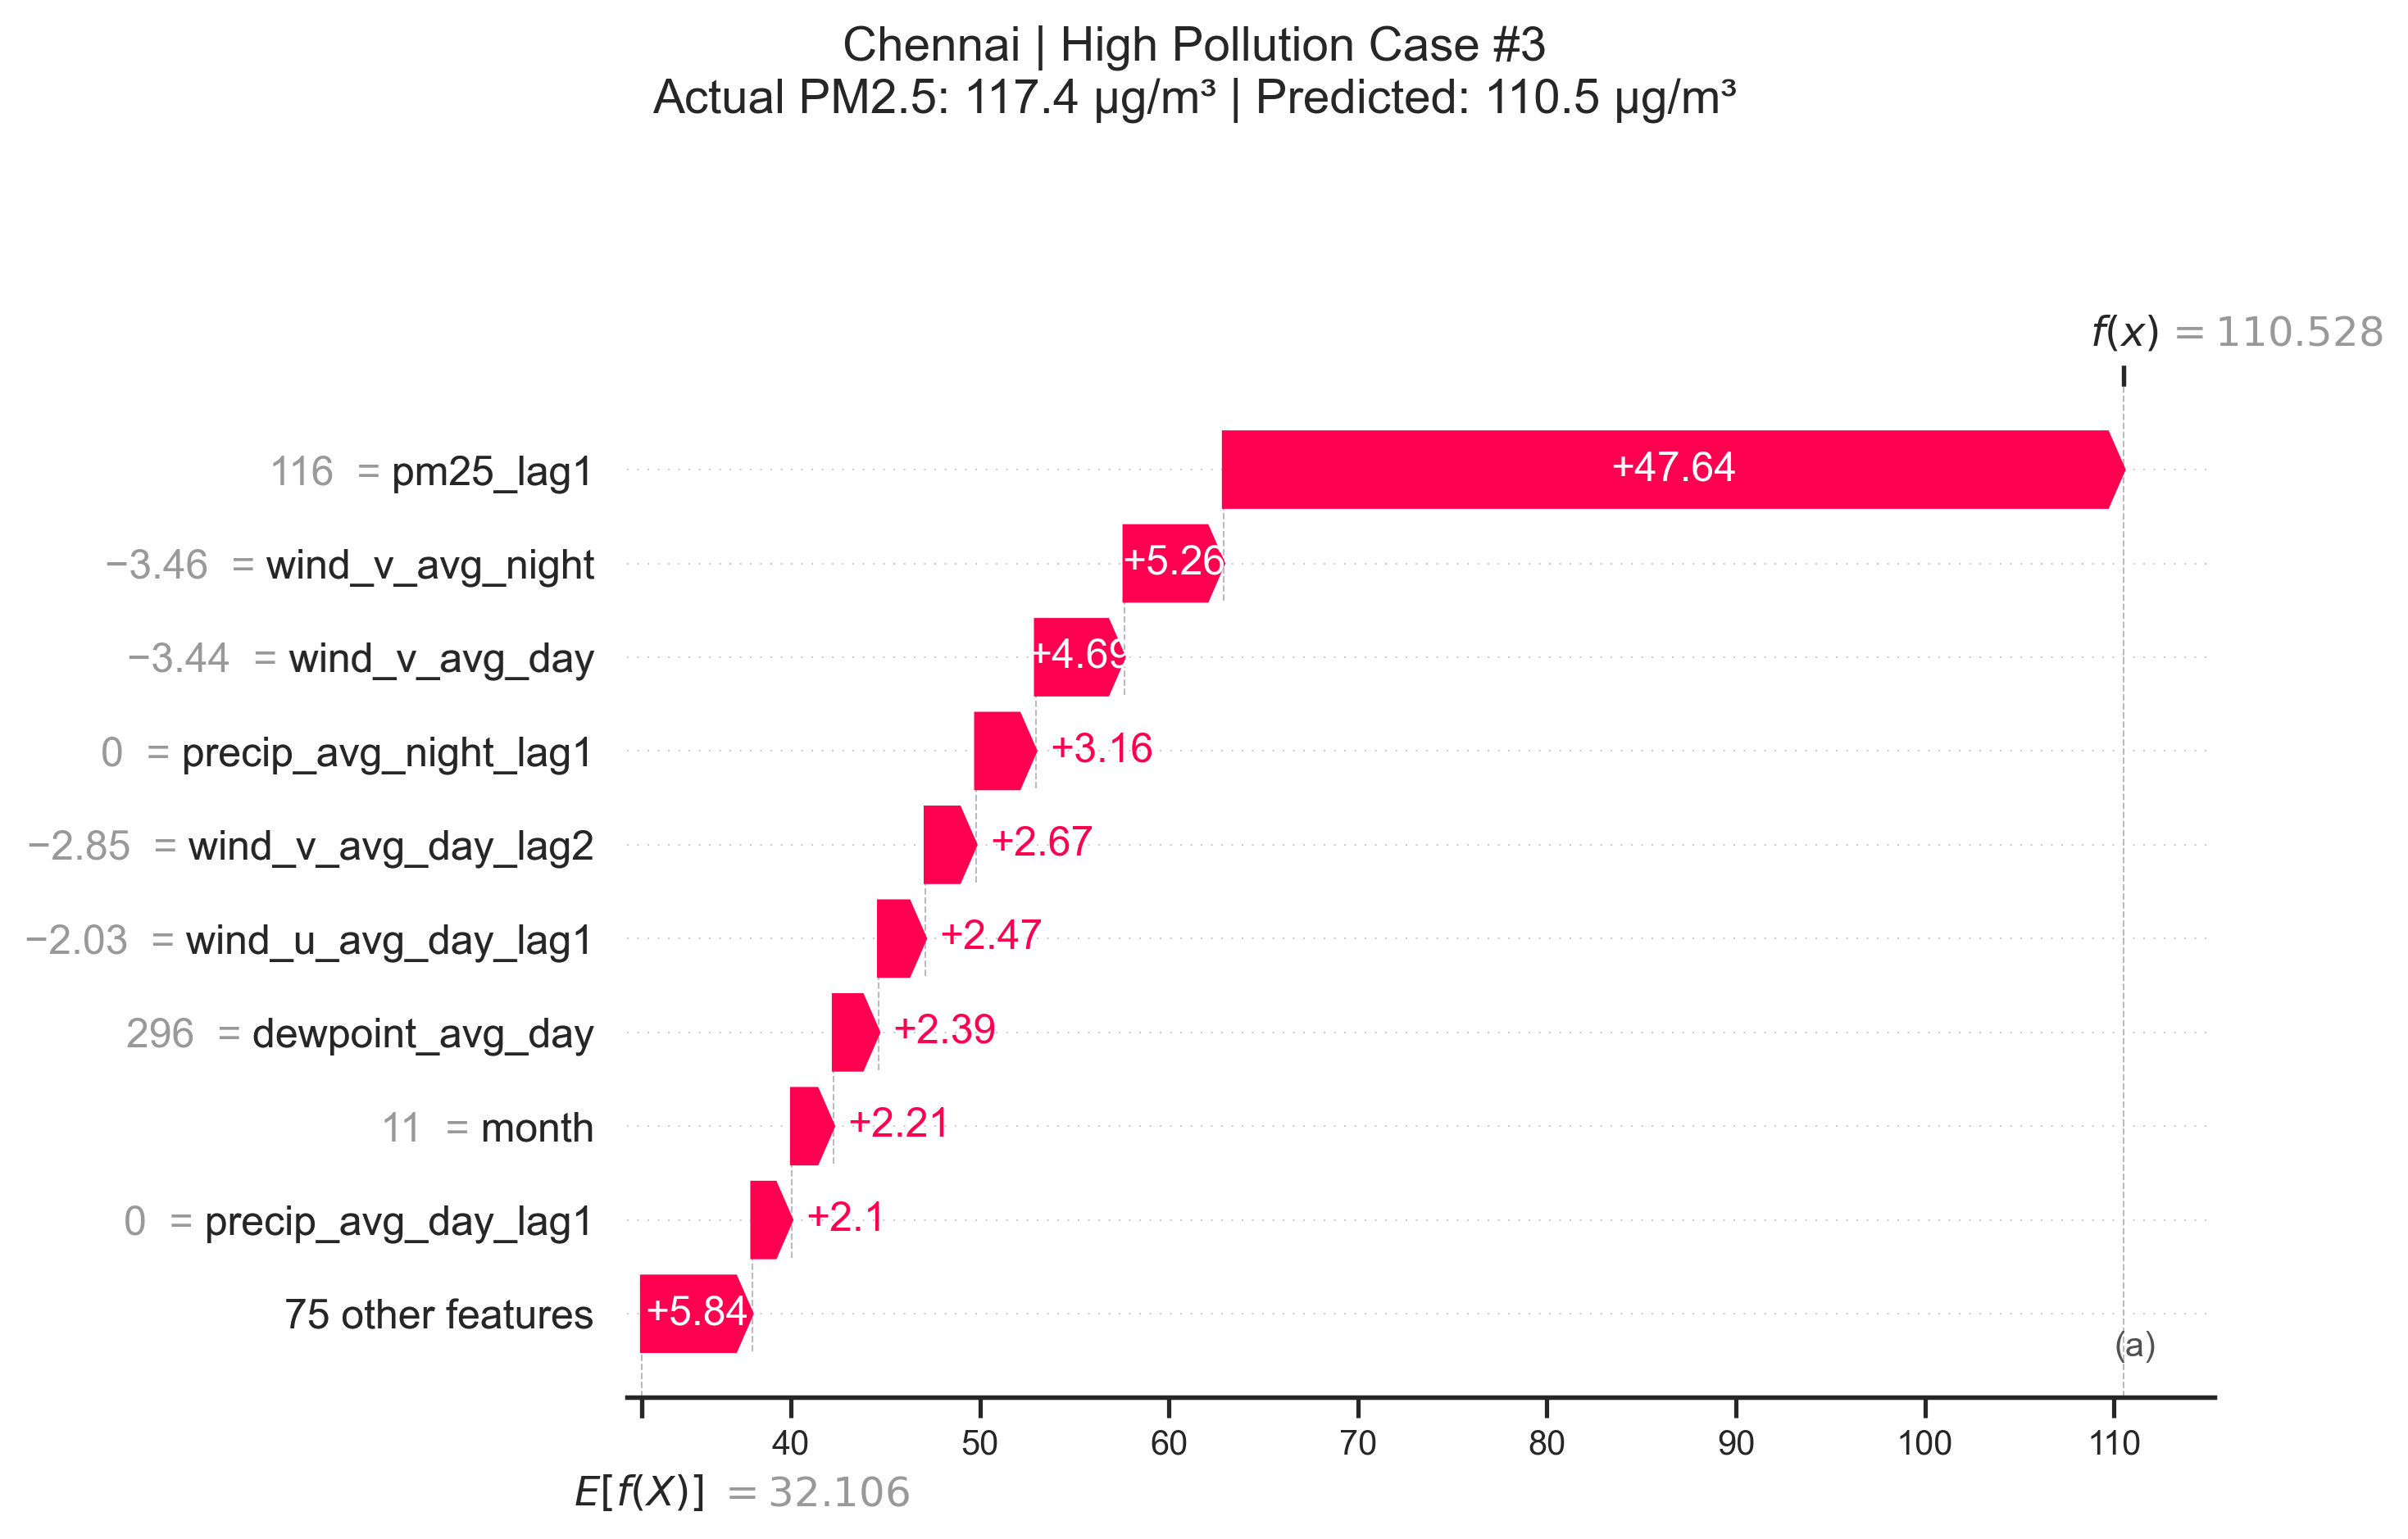

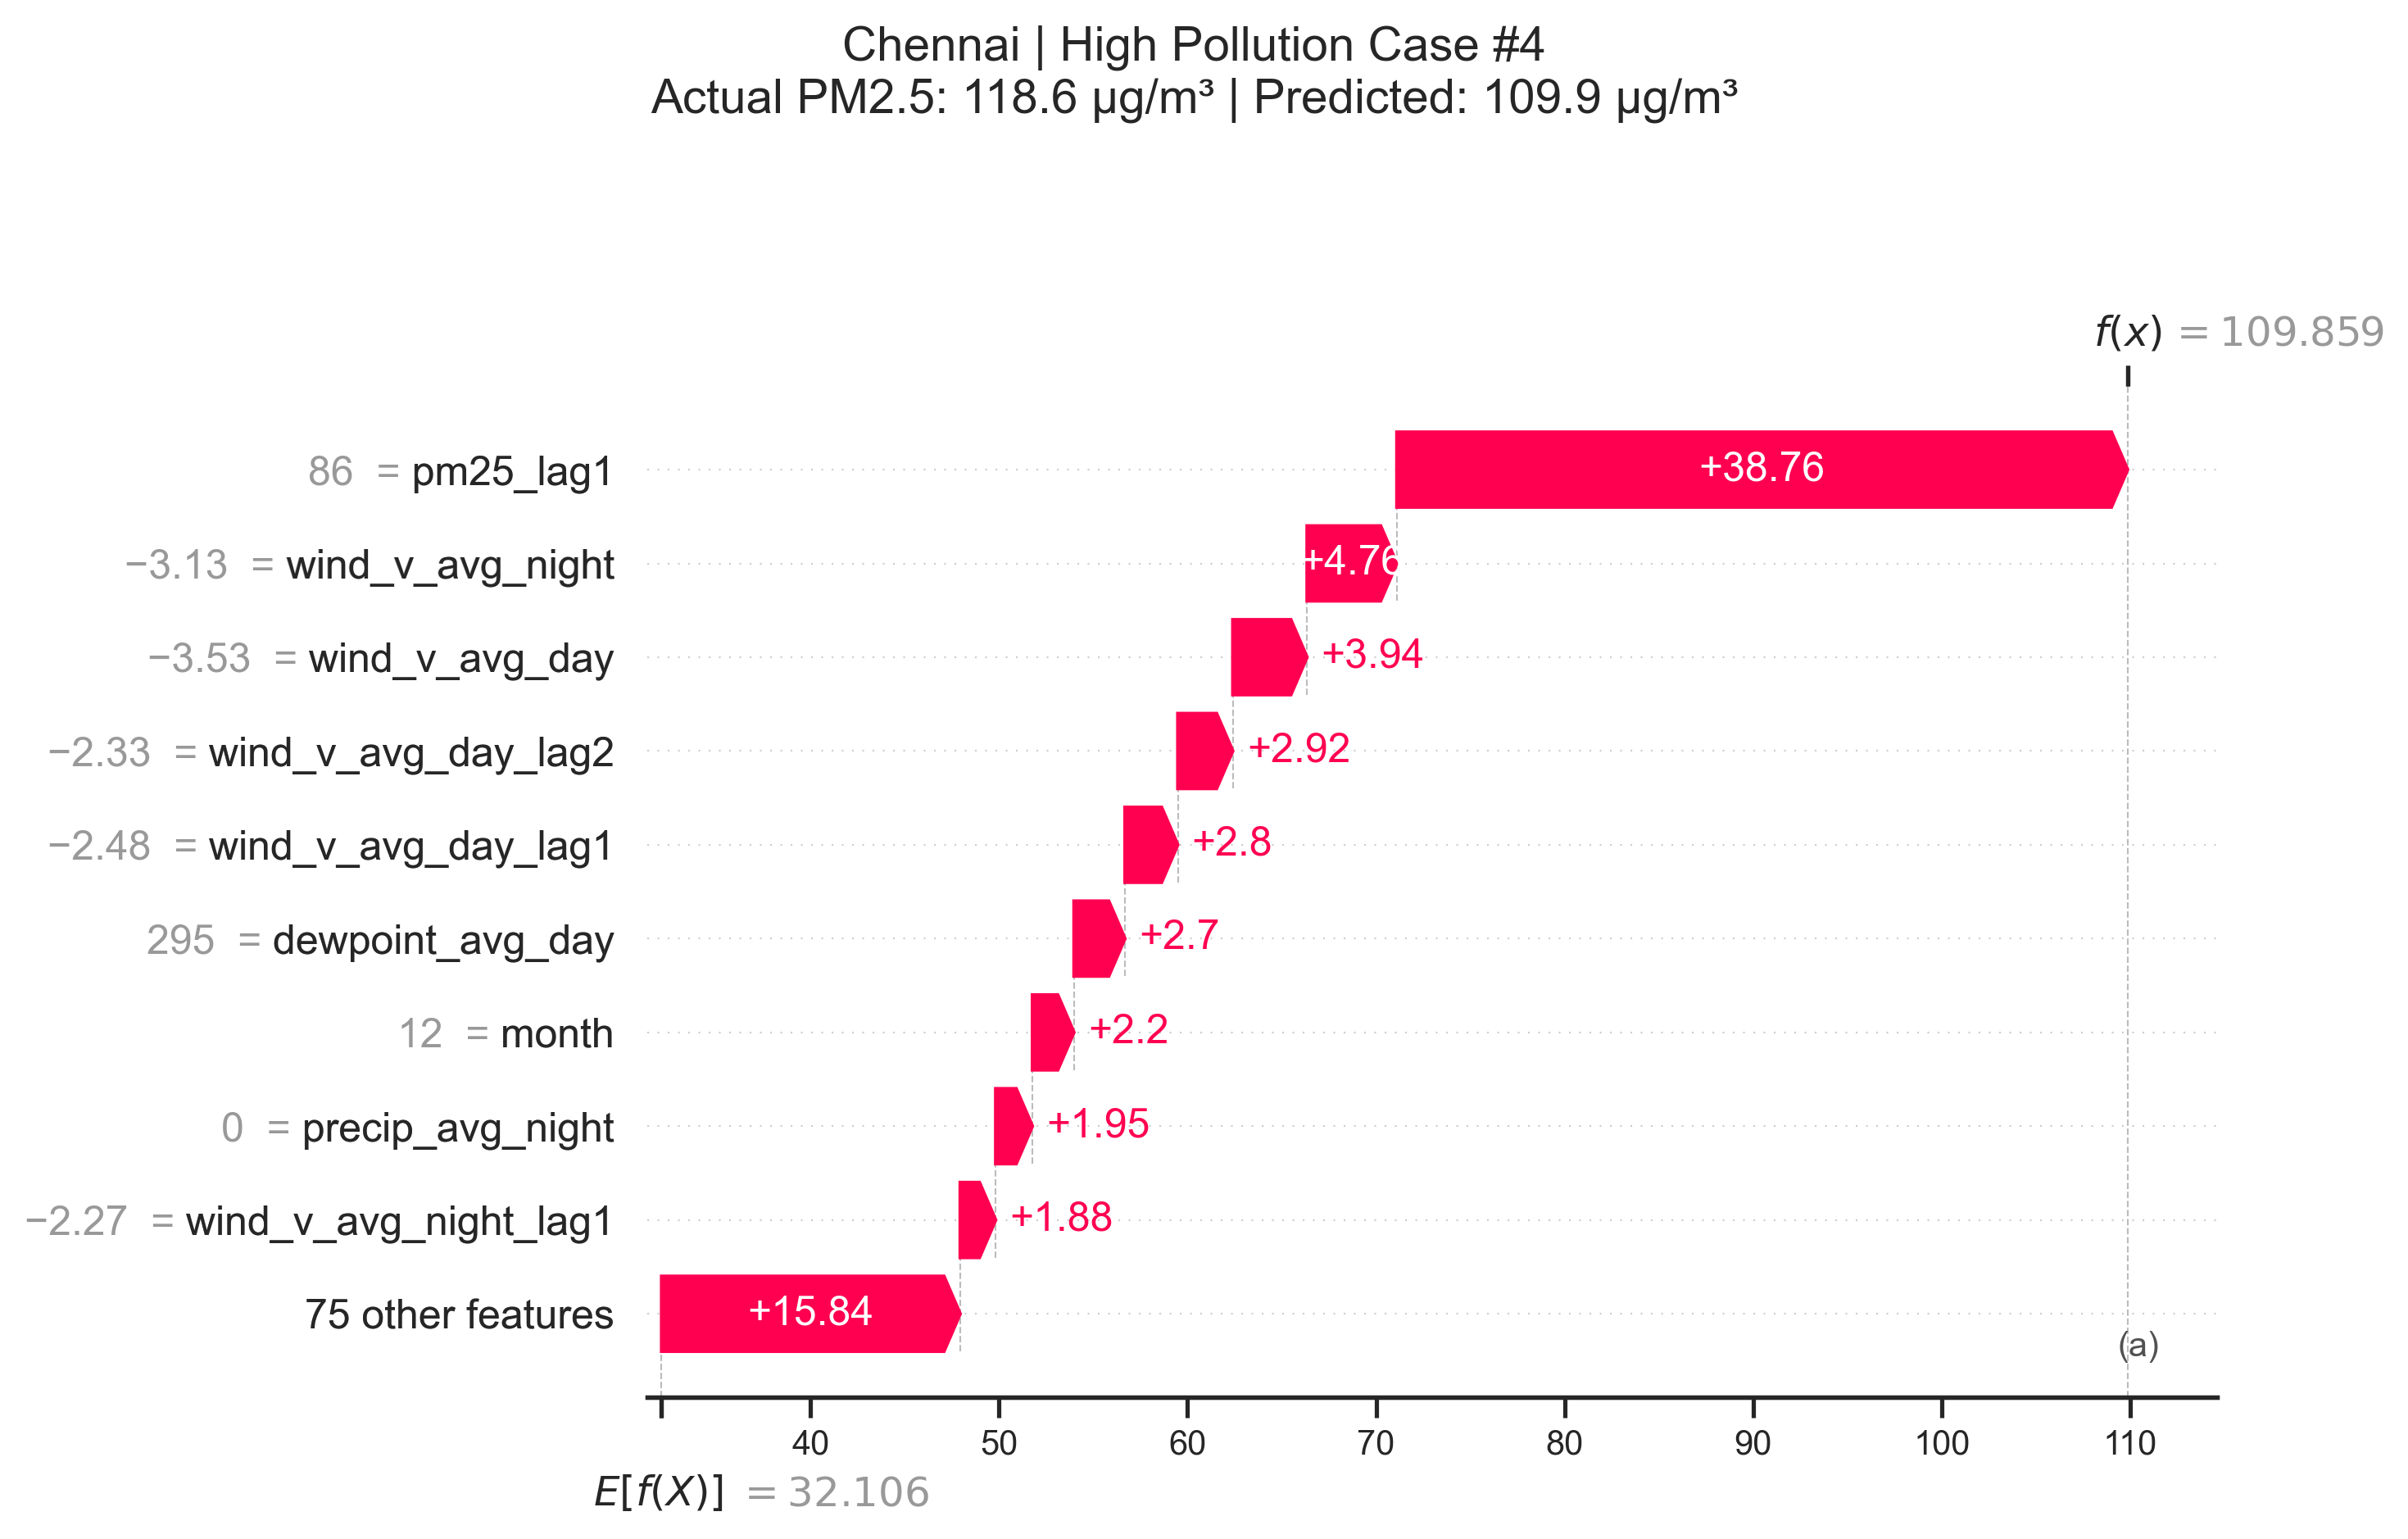

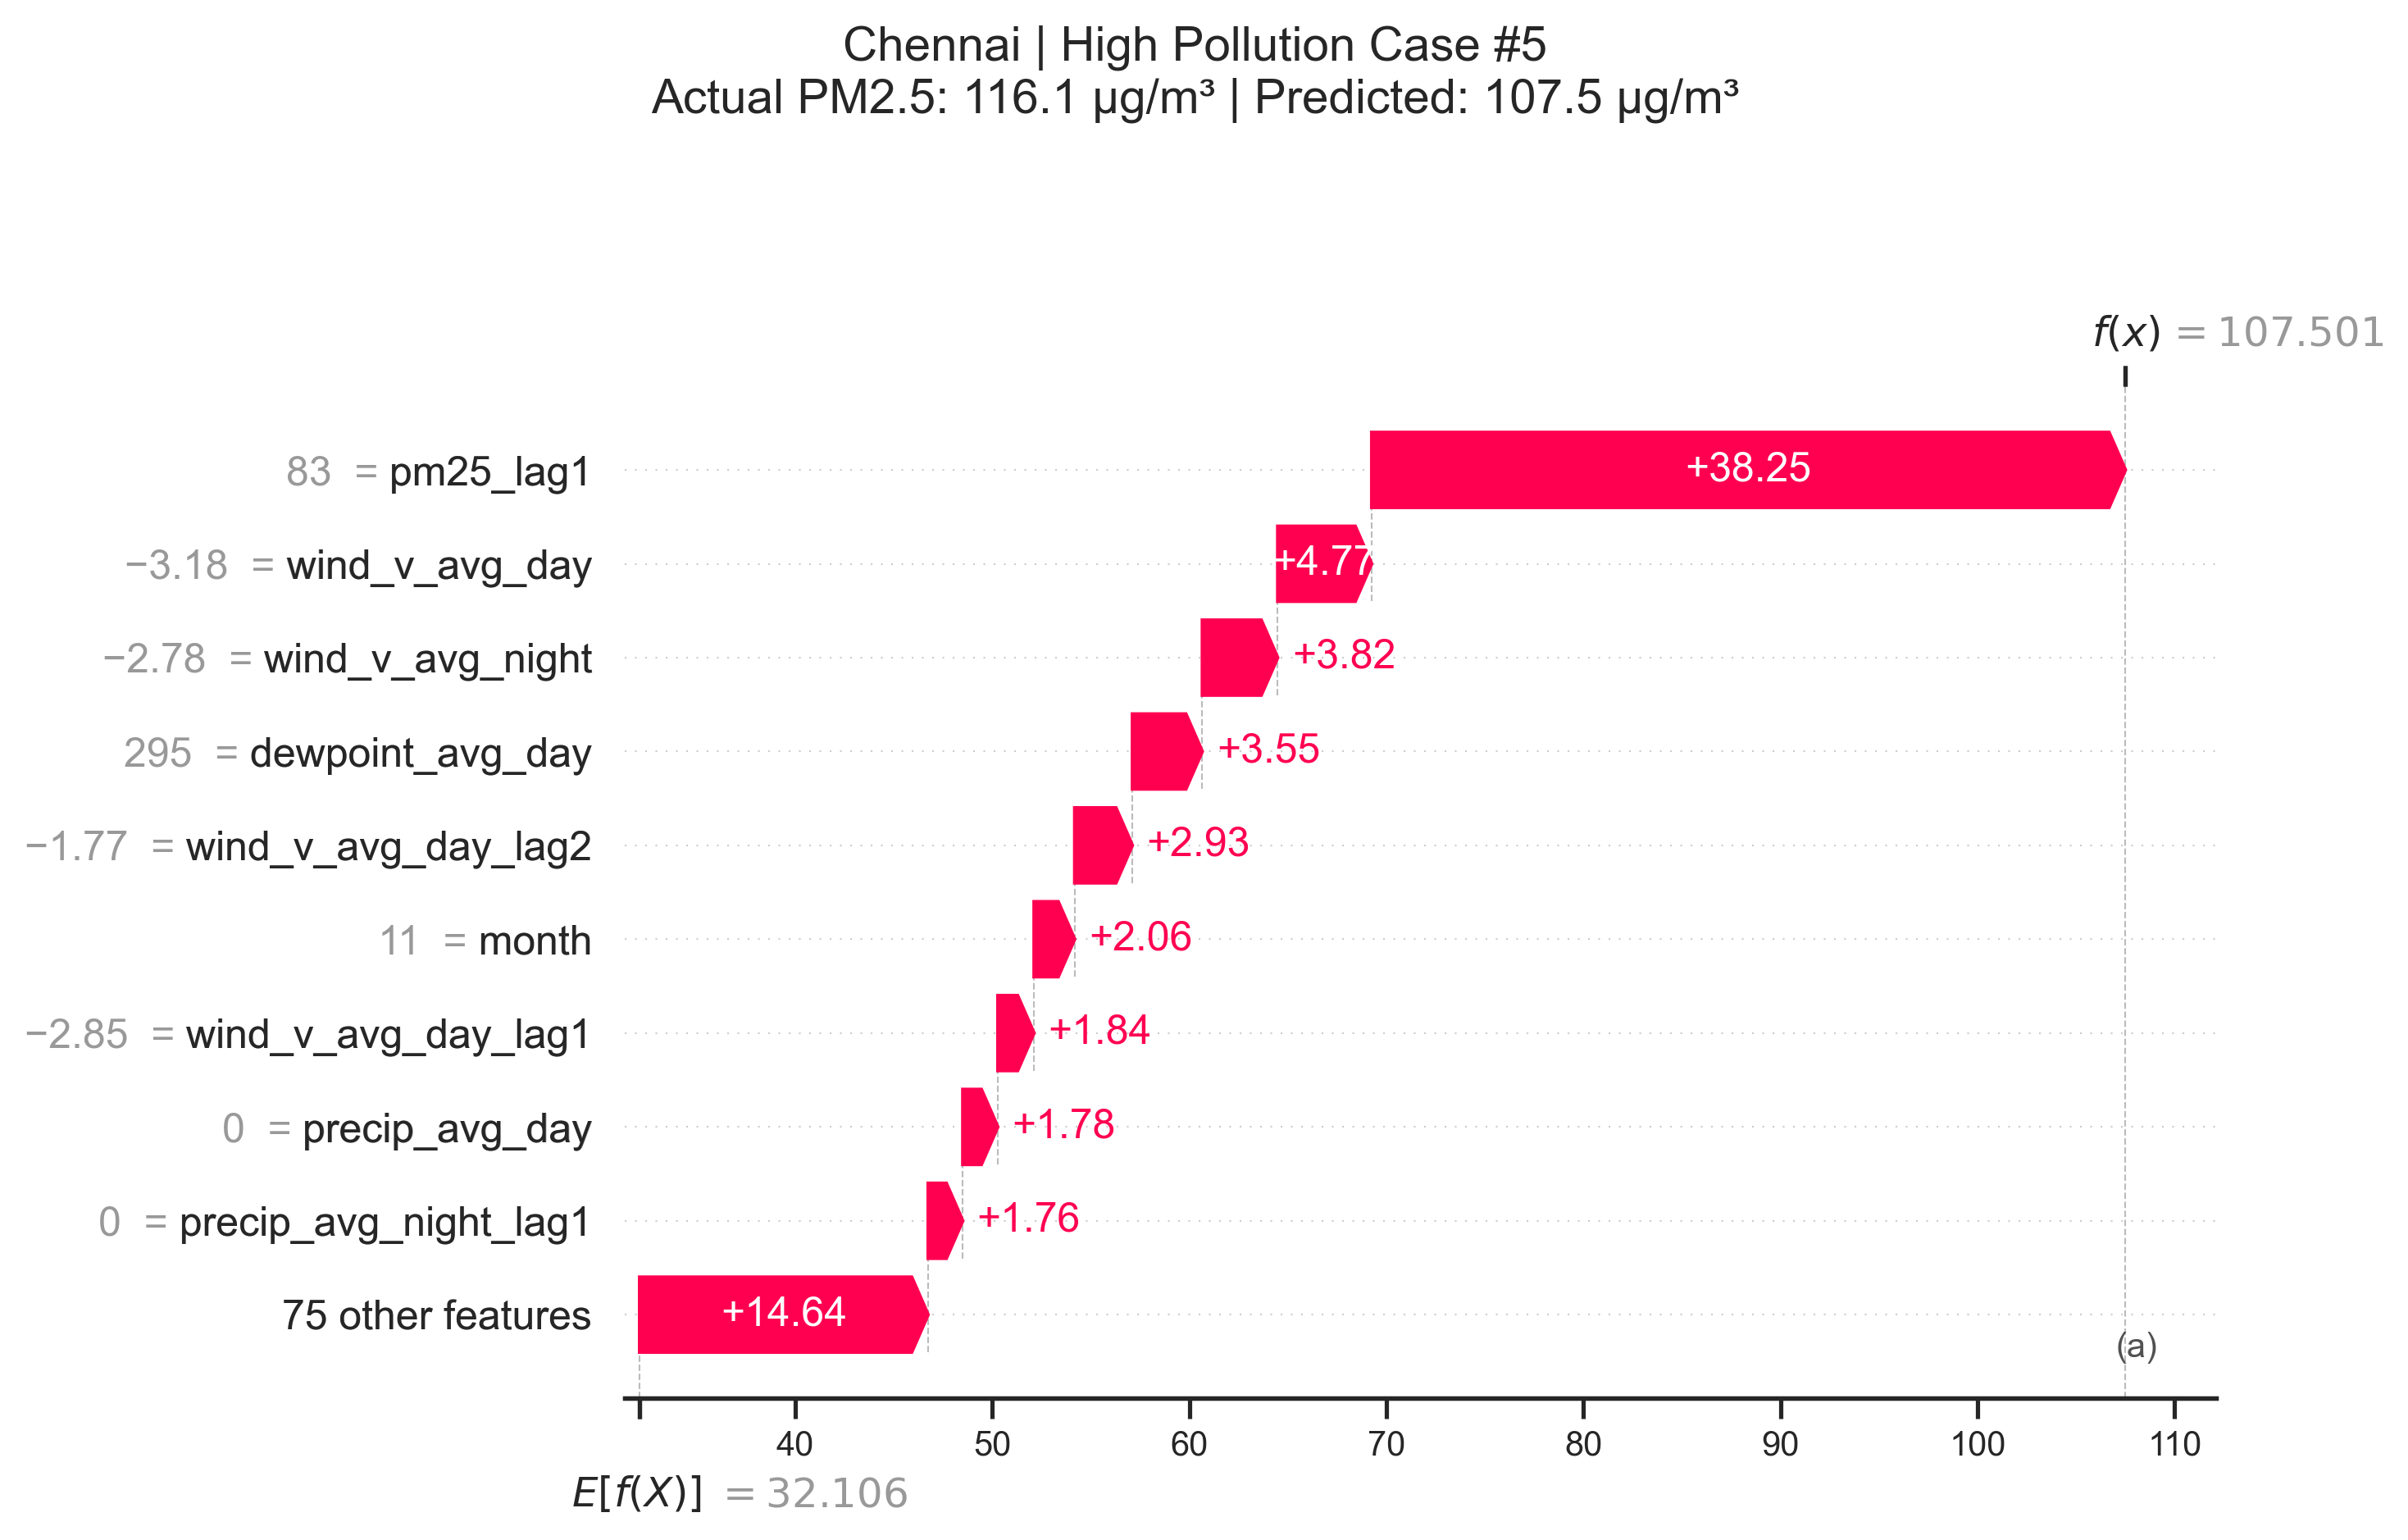

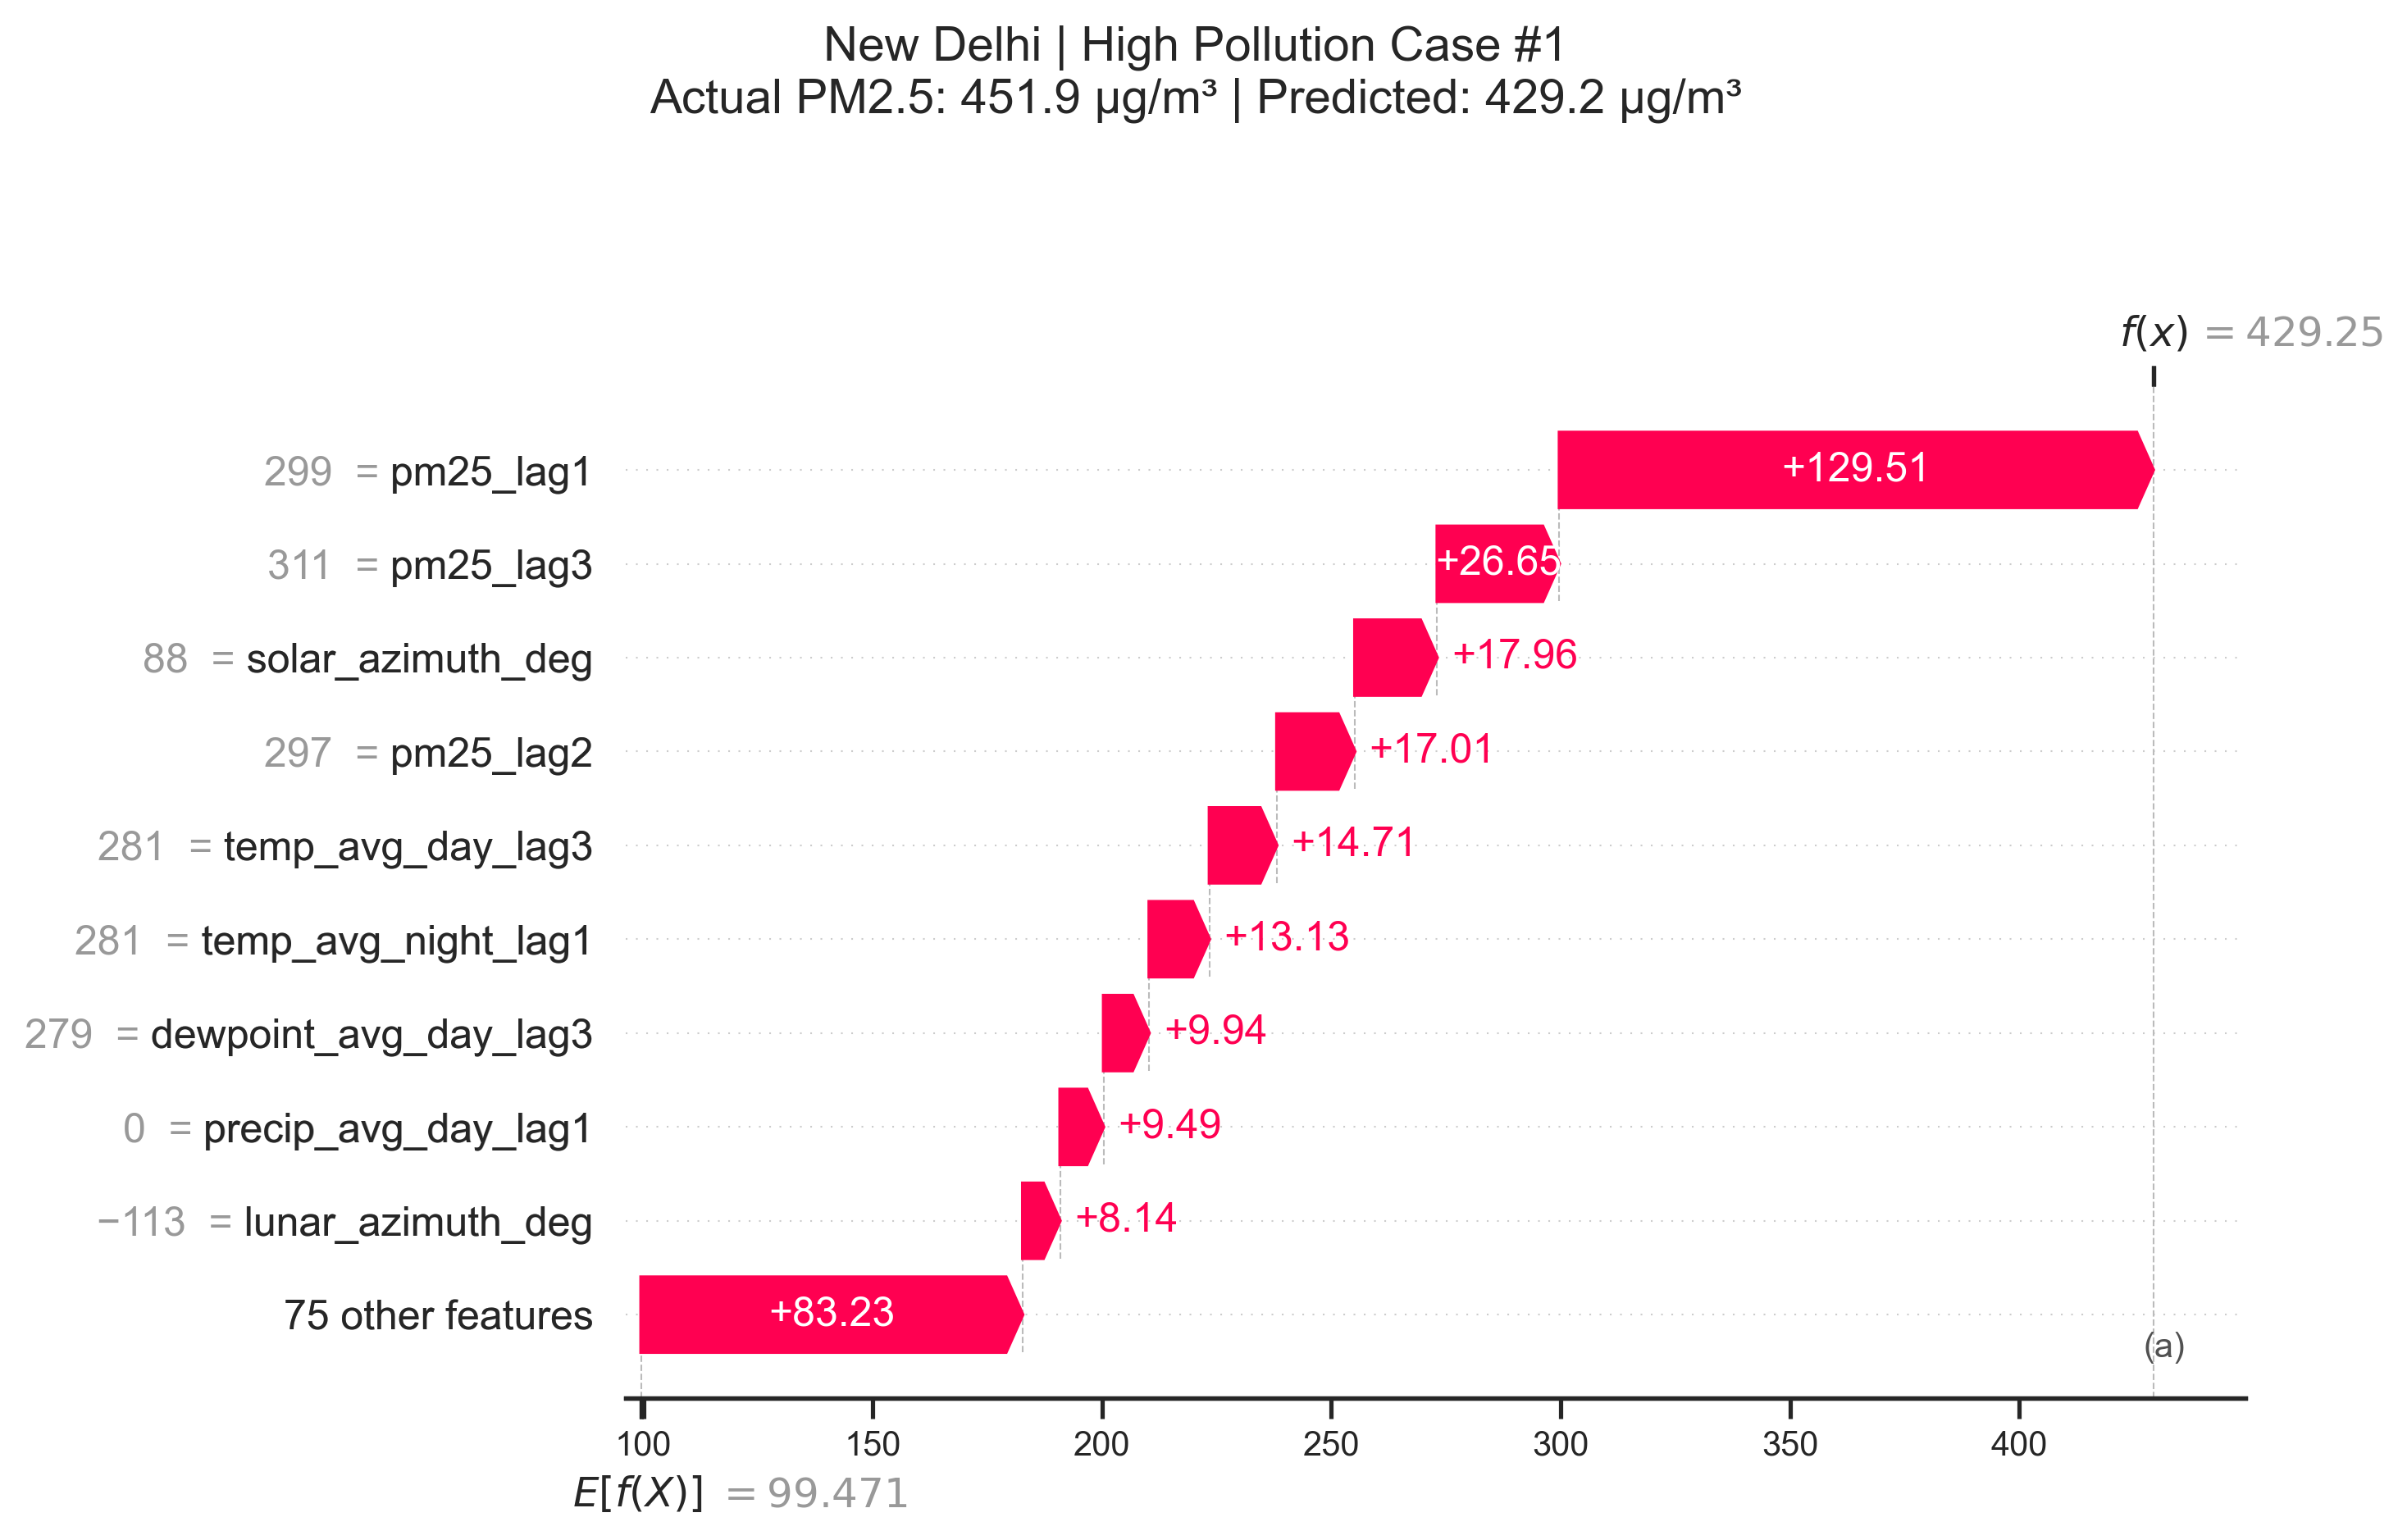

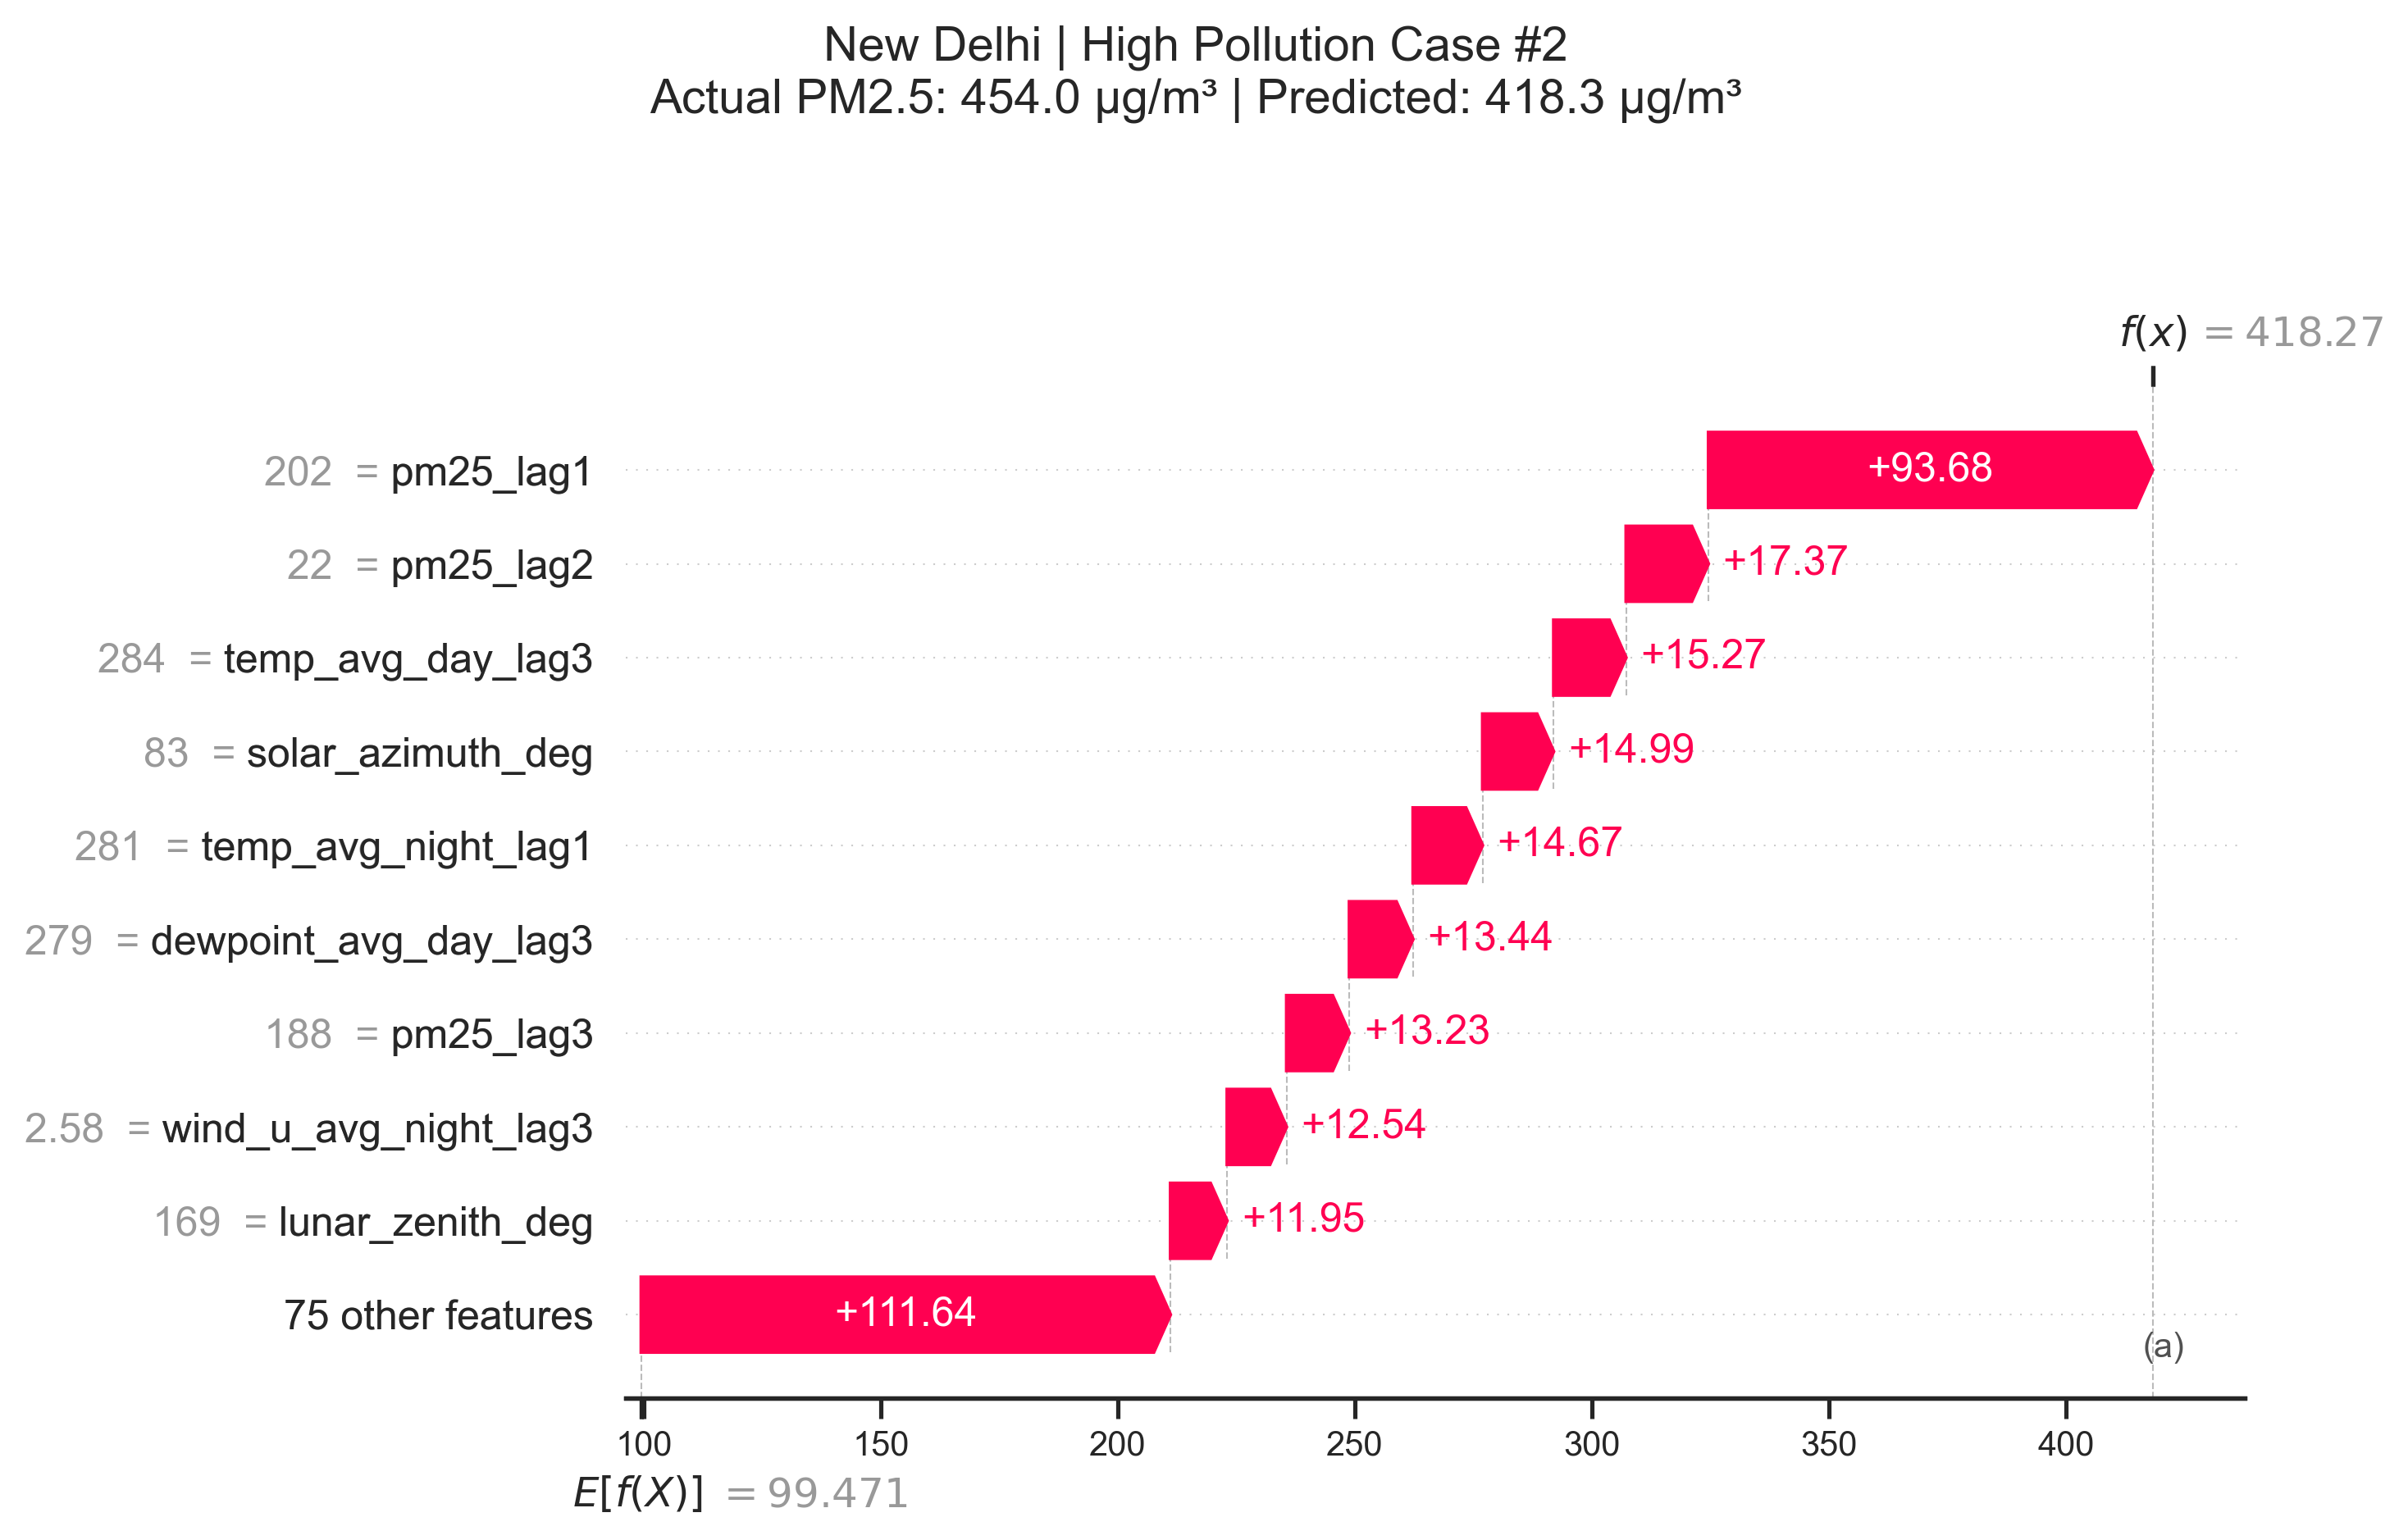

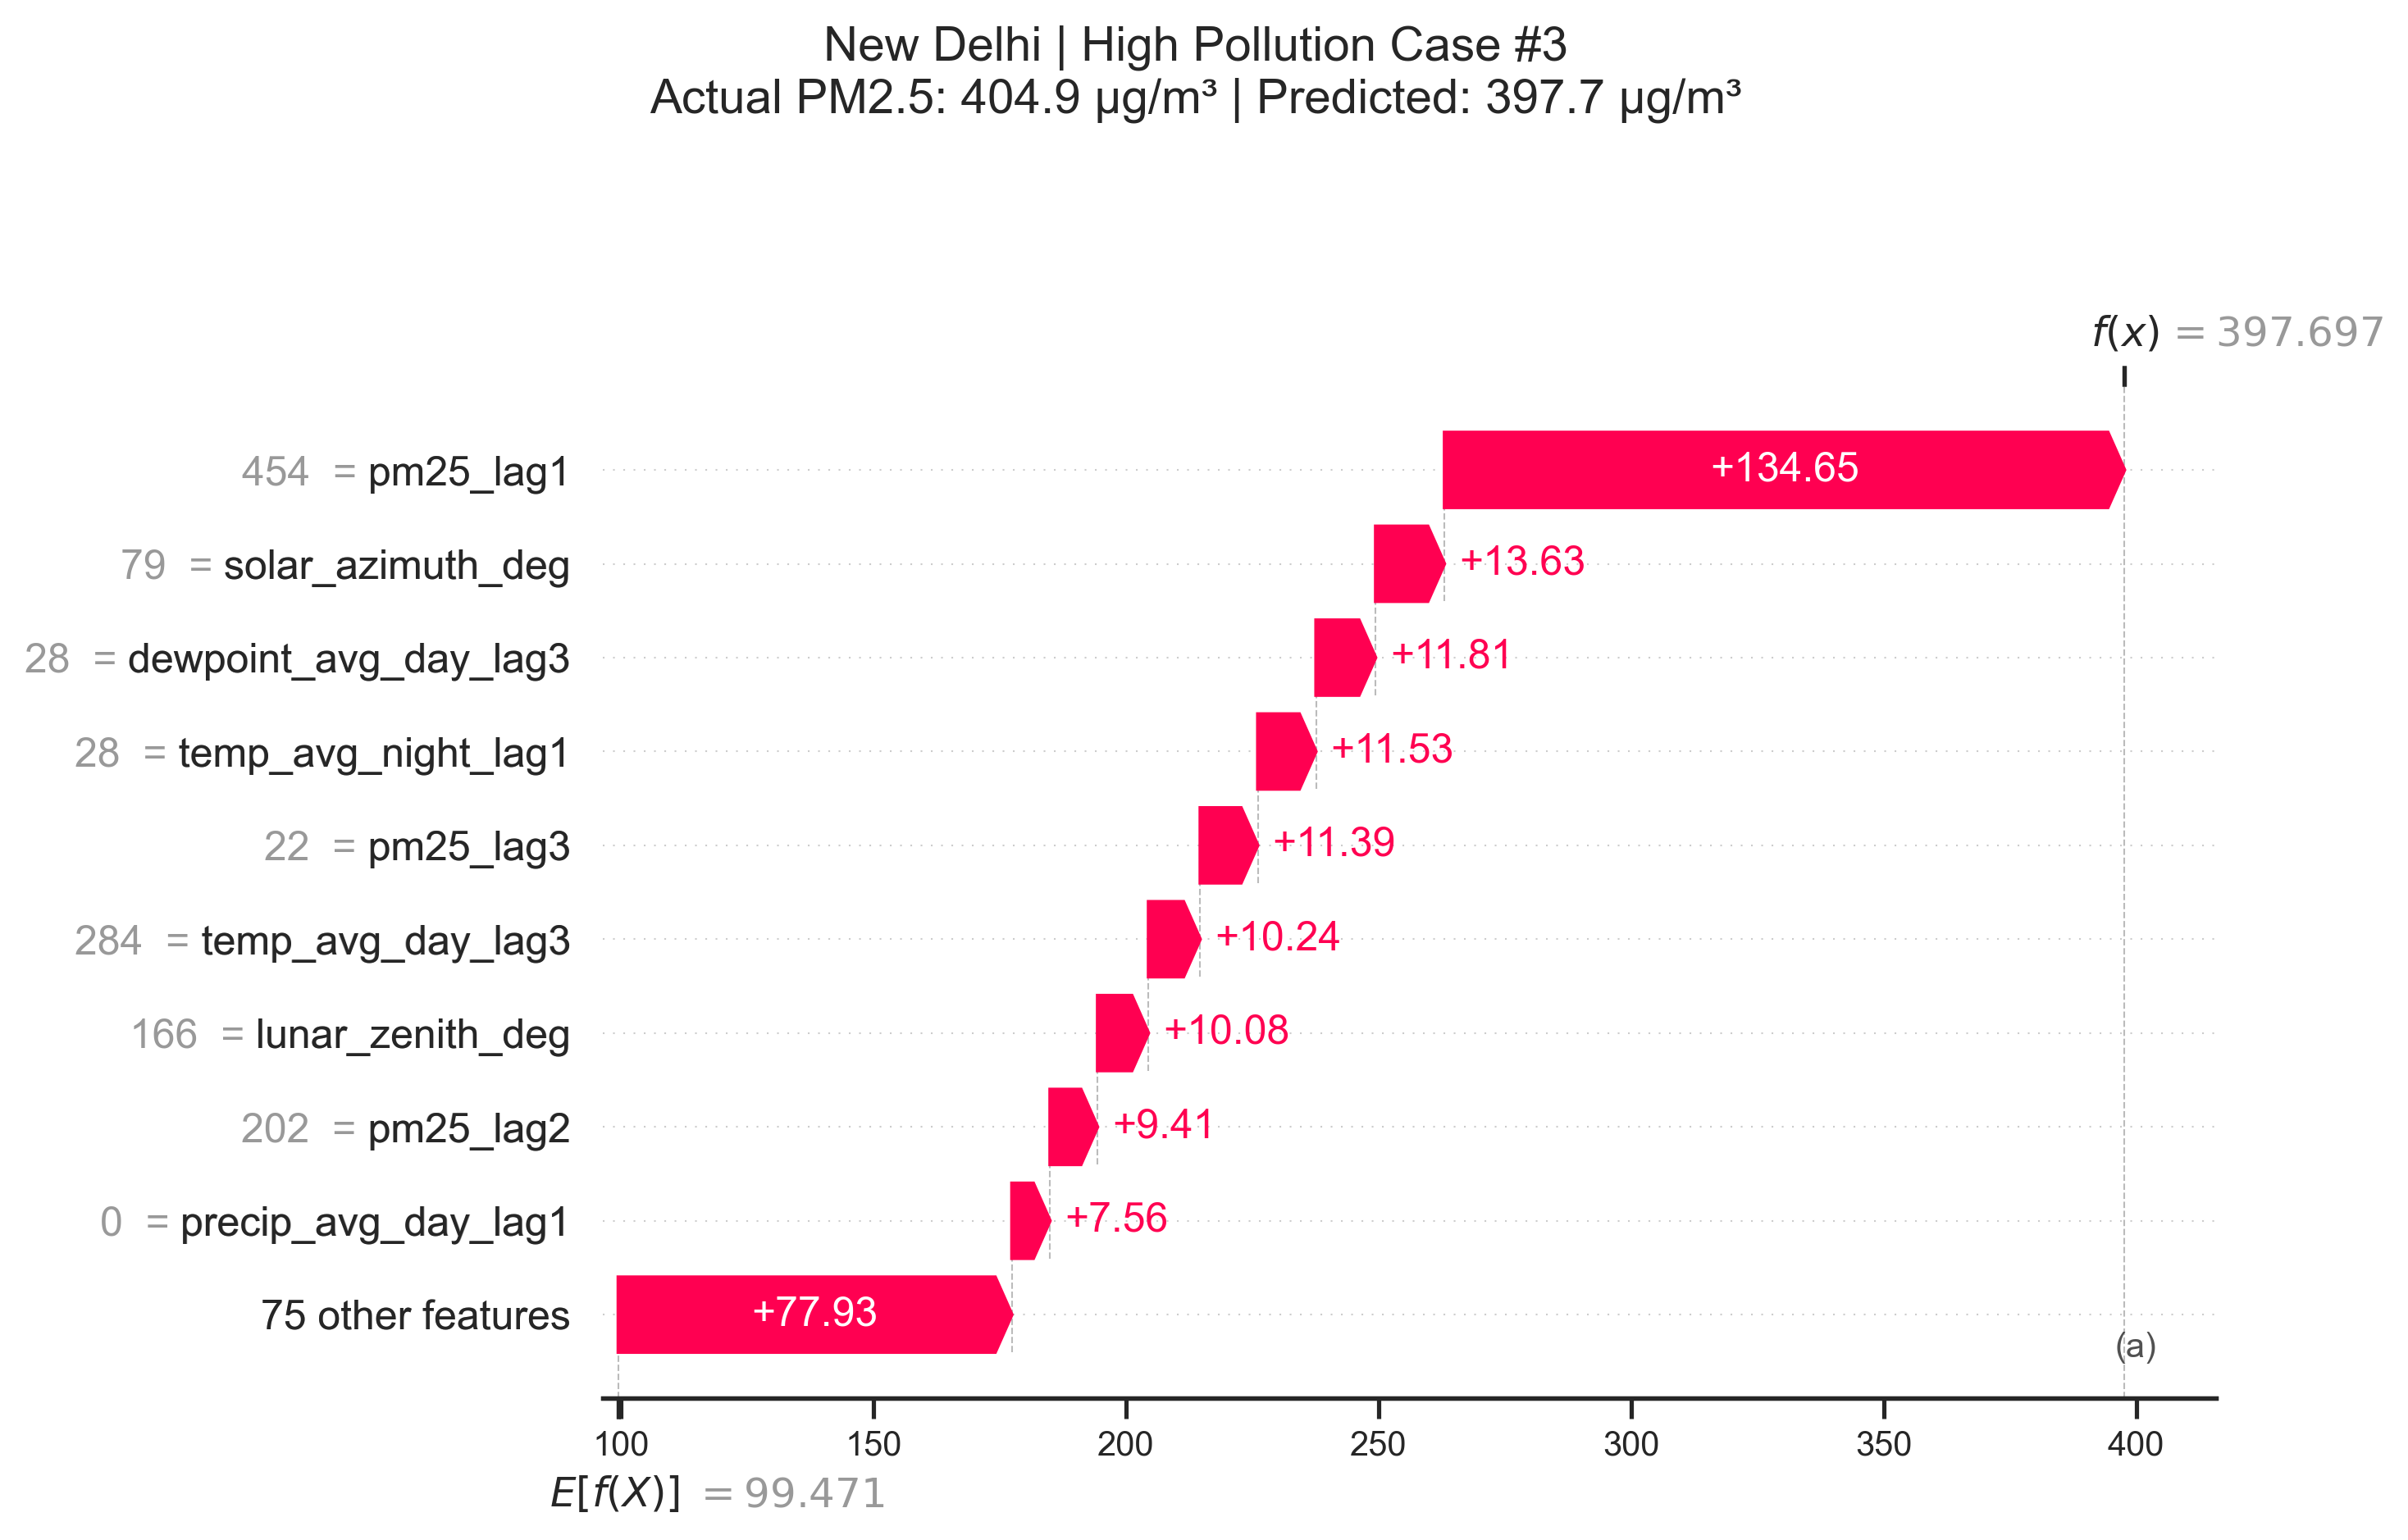

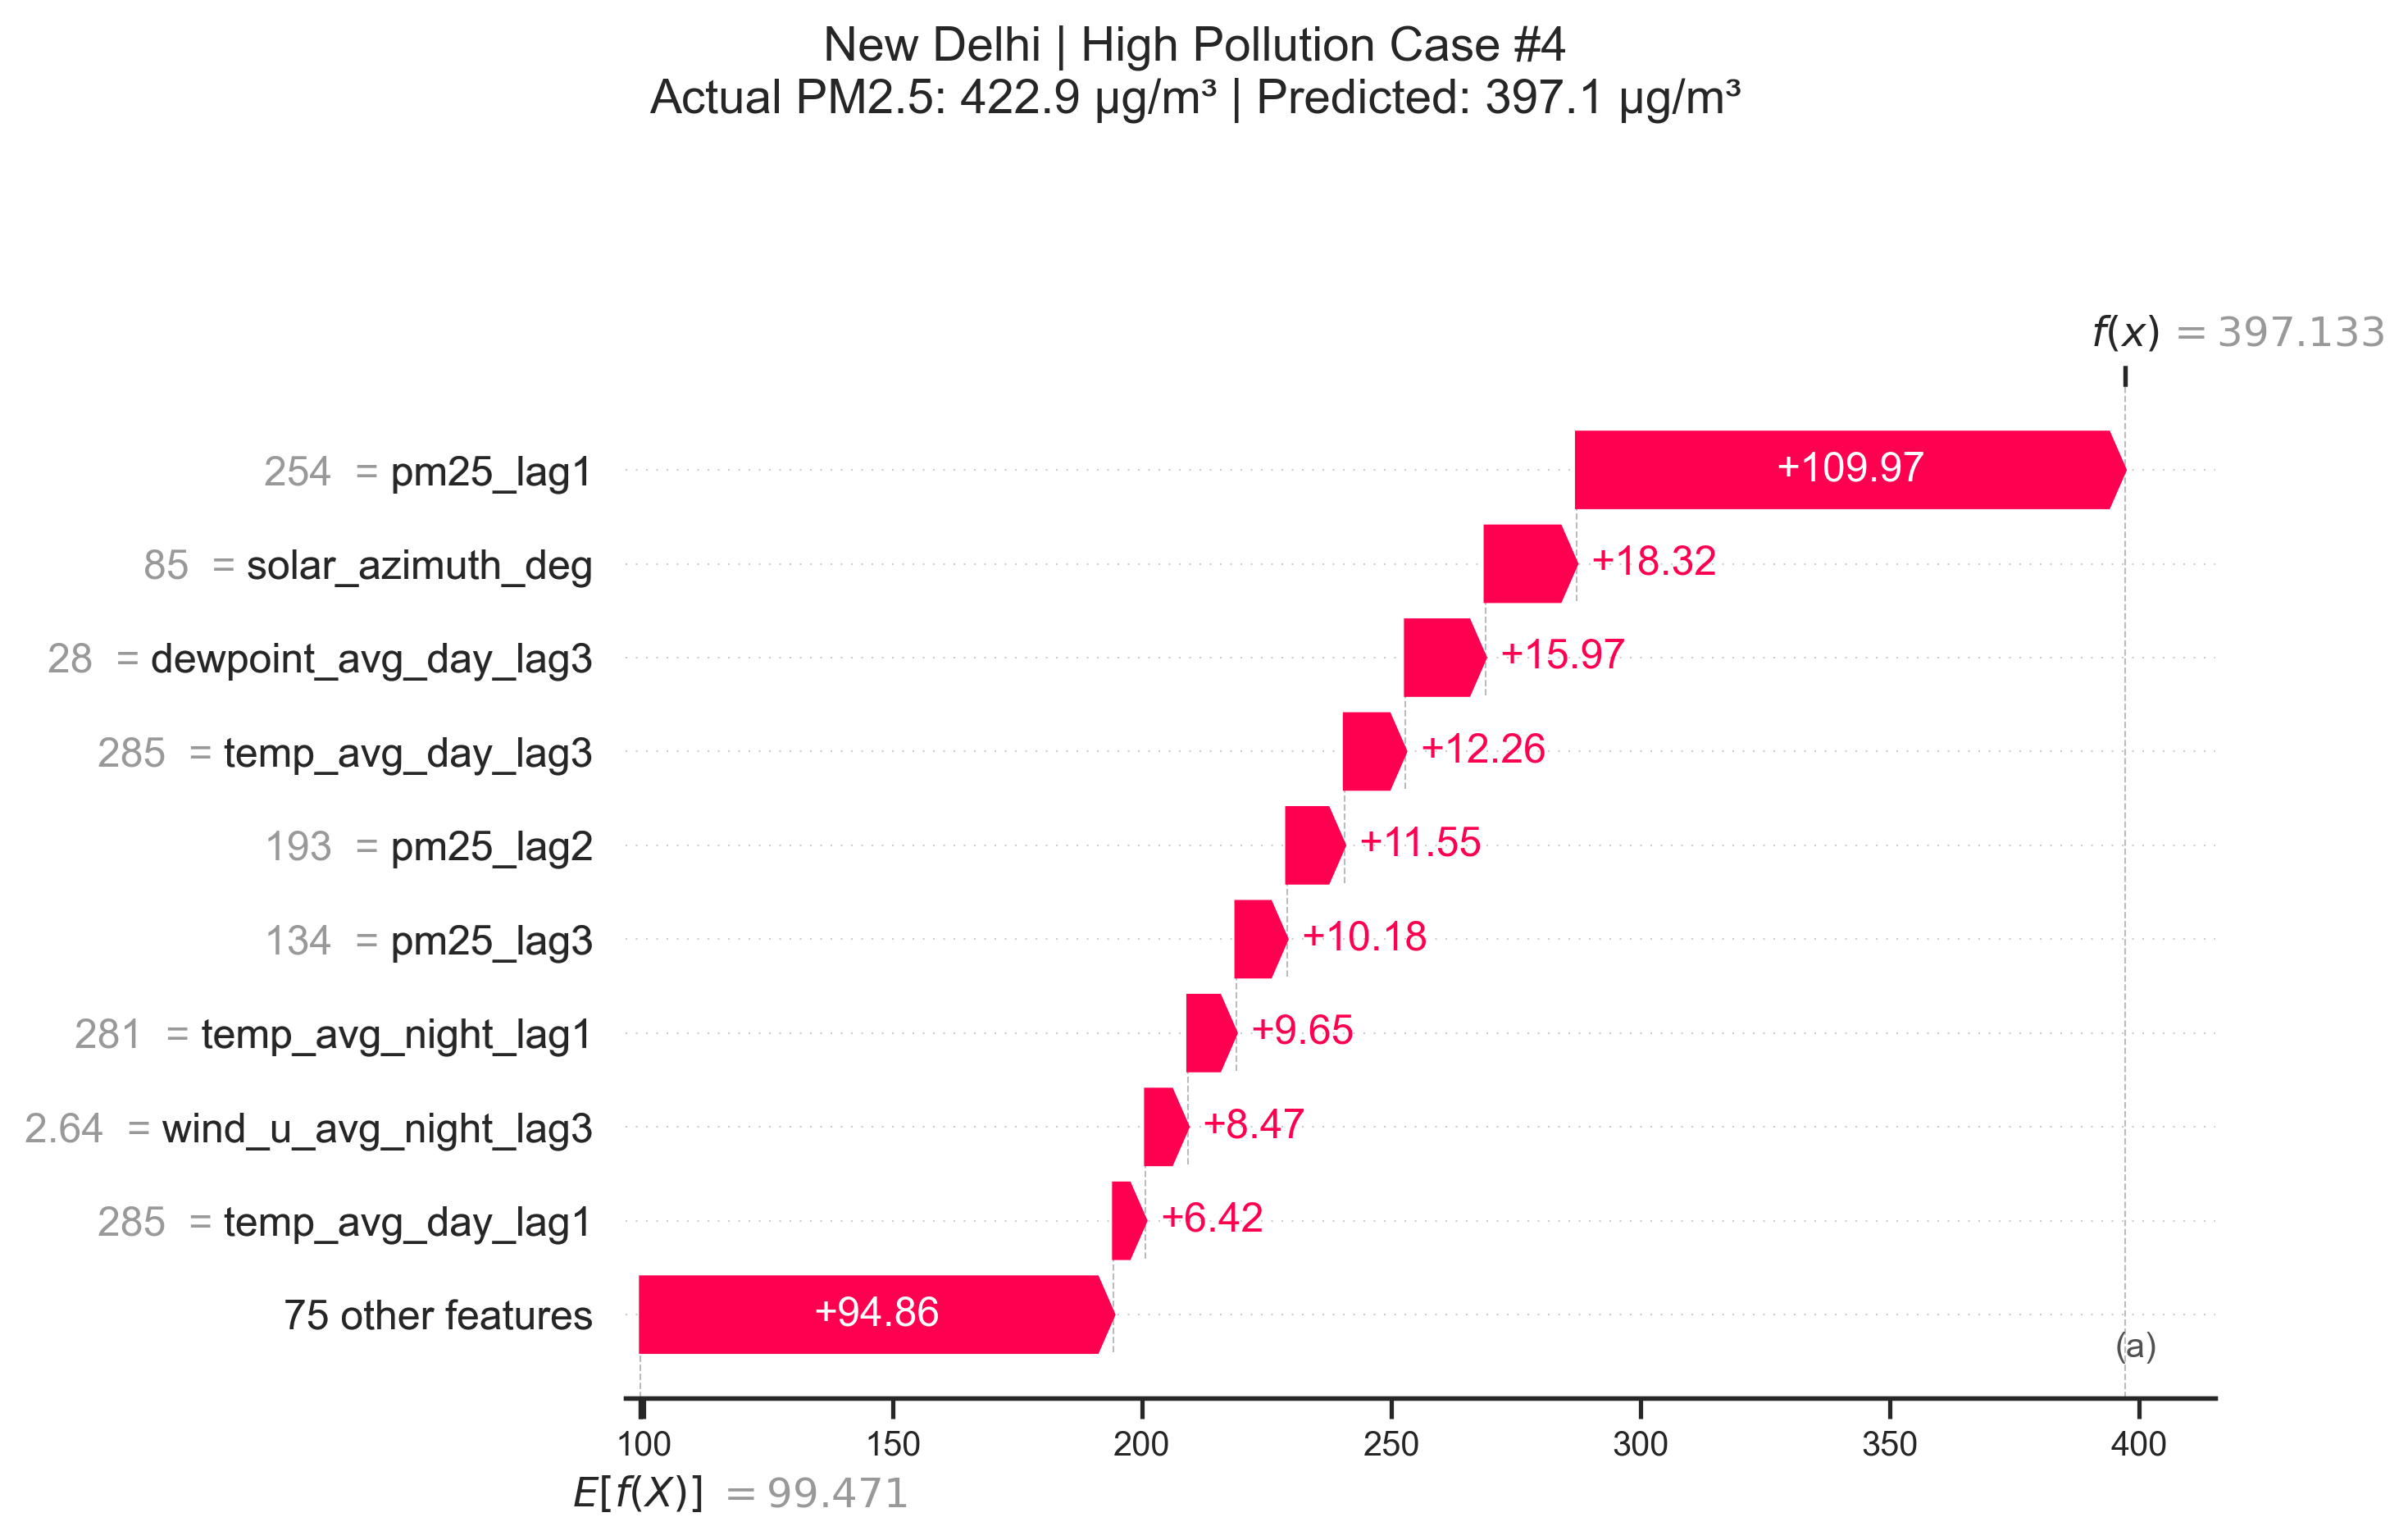

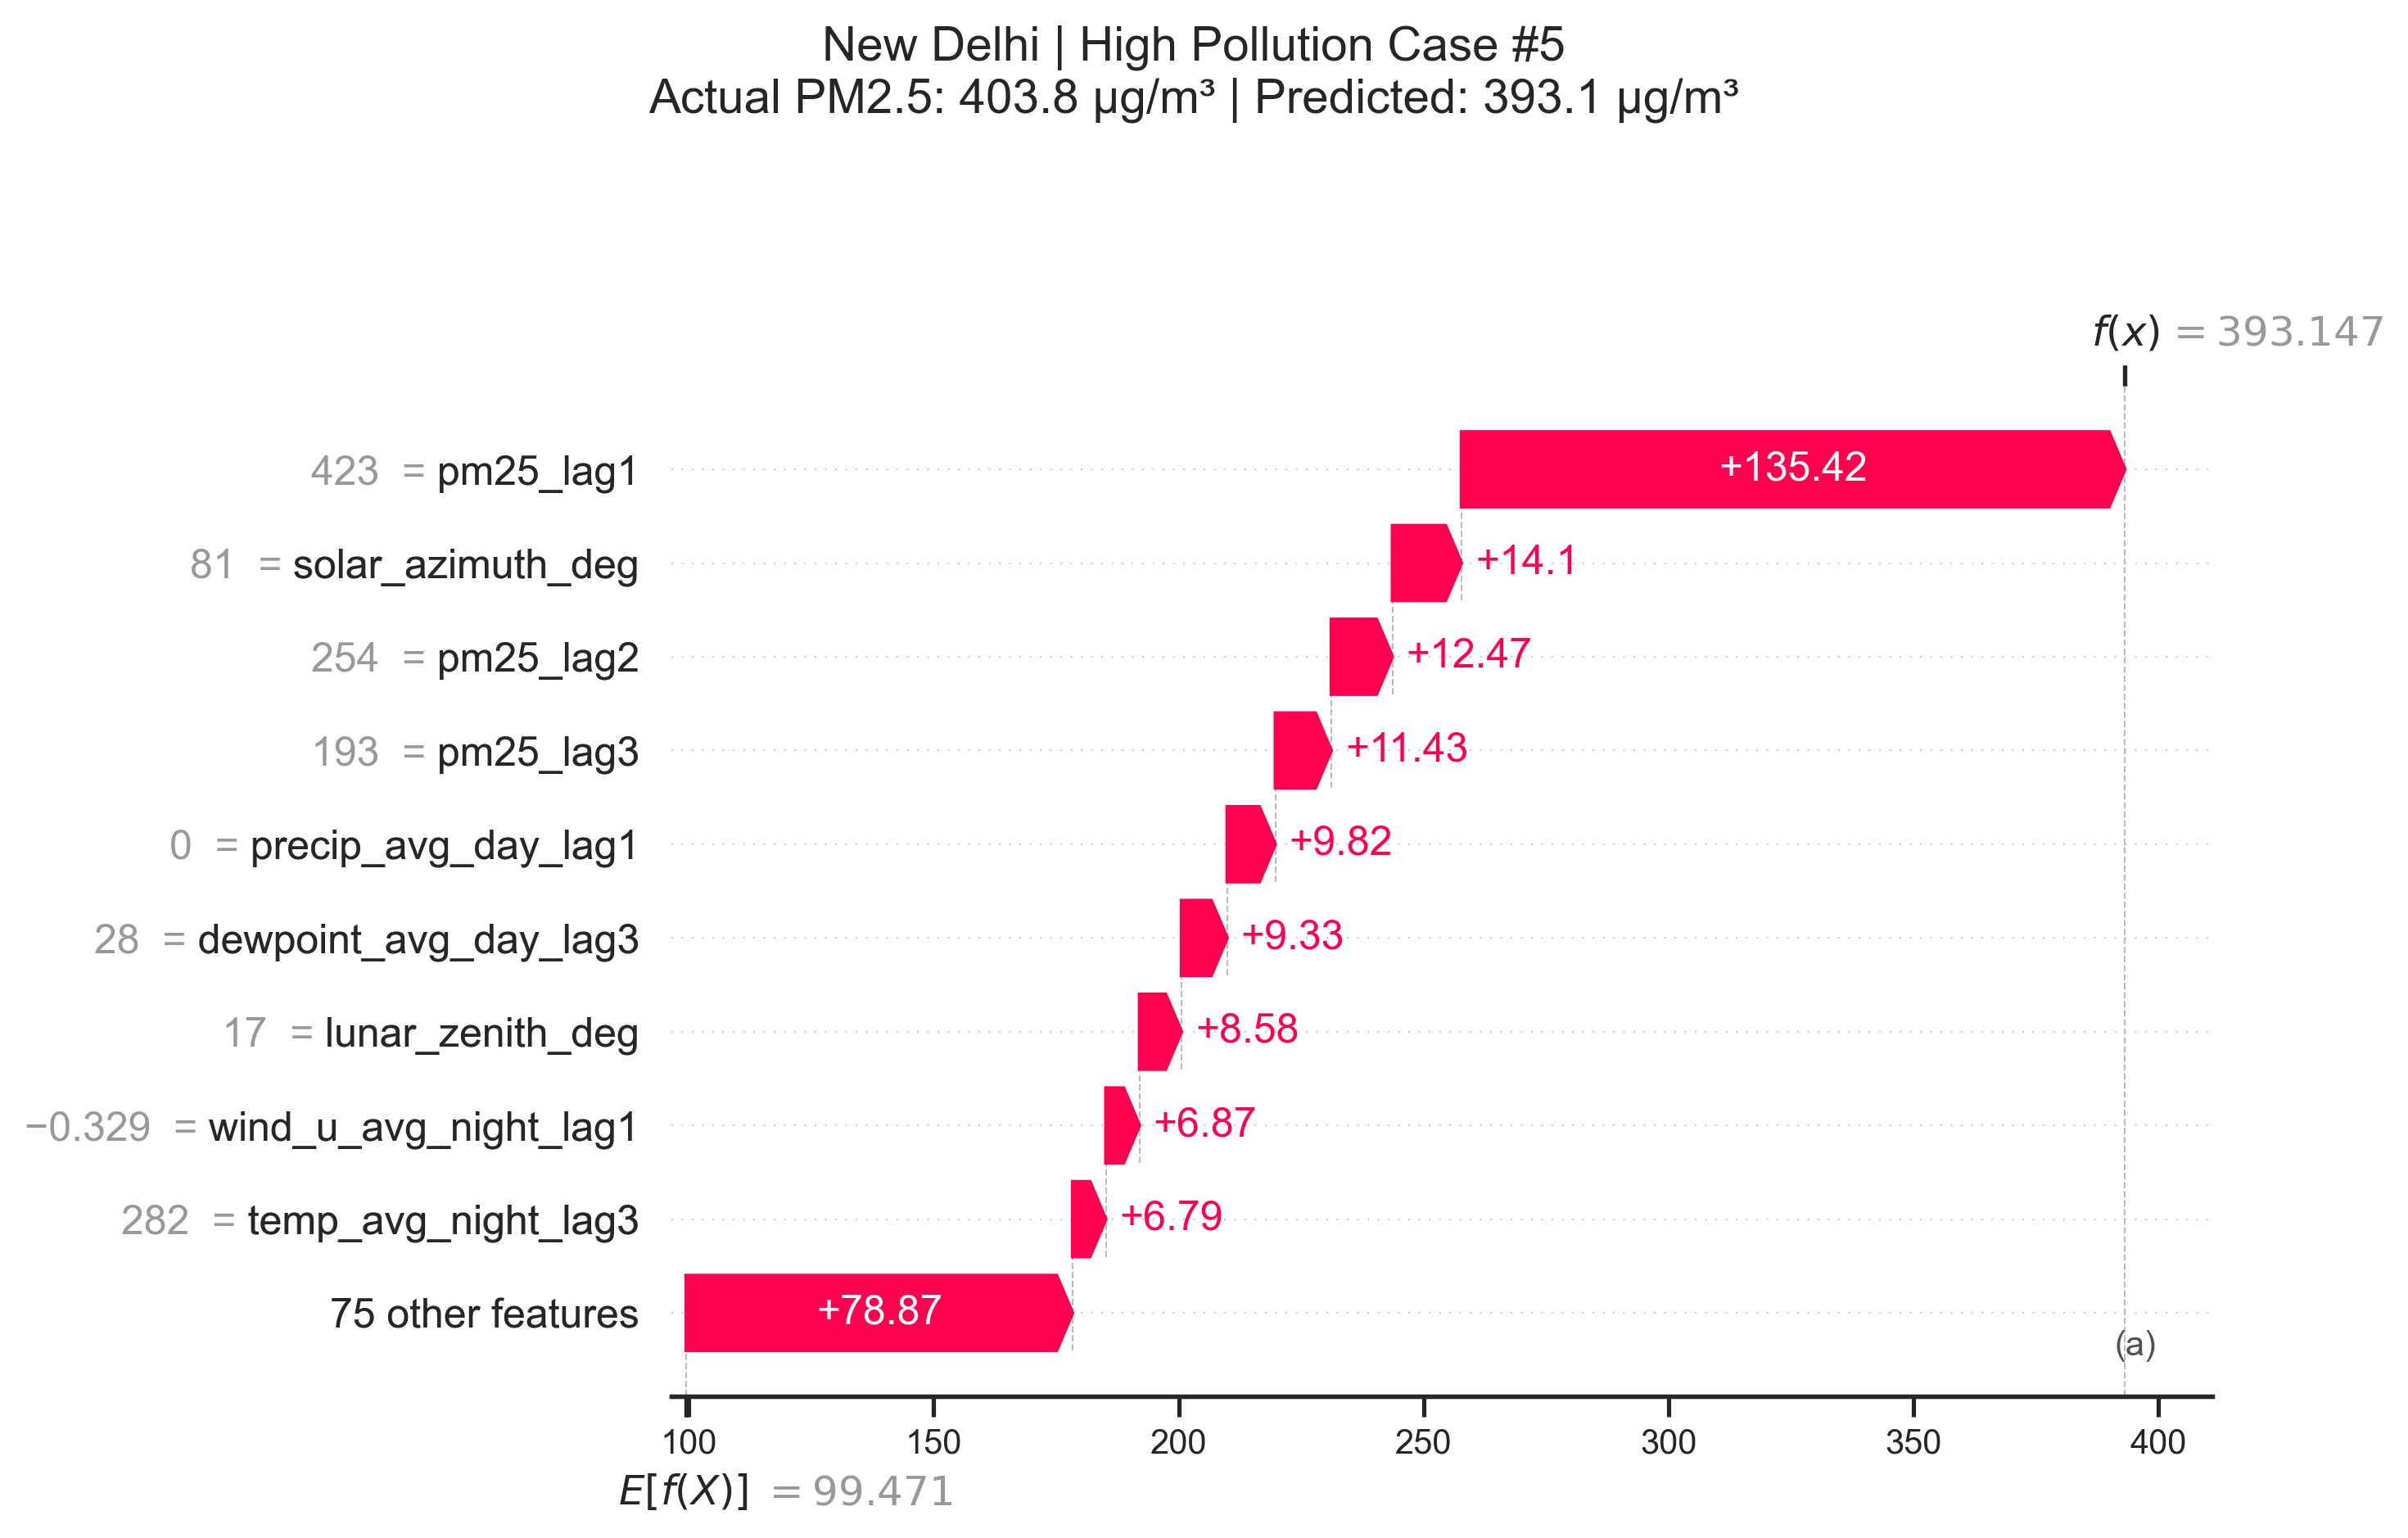

In [138]:
analyze_all_cities(
    city_models=final_models,
    city_training_data=city_data,
    num_cases=5
)

In [140]:
def get_predicted_zero_days(features, true_values, predictions, num_days=5):
    """
    Identify days when the model predicted zero PM2.5.

    Args:
        features: DataFrame of input features (X_train)
        true_values: Actual PM2.5 measurements (y_train)
        predictions: Model's predicted PM2.5 values
        num_days: Number of zero-predicted cases to analyze

    Returns:
        Tuple of (zero_features, zero_actuals, zero_predictions)
    """
    is_zero_predicted = predictions == 0
    if not is_zero_predicted.any():
        return None, None, None

    # Optionally sort by confidence — low predicted pollution
    selected_indices = np.where(is_zero_predicted)[0][:num_days]

    return (
        features.iloc[selected_indices],
        true_values.iloc[selected_indices],
        predictions[selected_indices]
    )


def analyze_zero_prediction_days(city_name, pollution_model, training_features, true_pollution_values, num_cases=5):
    """
    Analyze and explain model decisions for days when PM2.5 was predicted as zero.

    Args:
        city_name: City being analyzed
        pollution_model: Trained model for the city
        training_features: X_train
        true_pollution_values: y_train
        num_cases: How many zero-prediction cases to explain
    """
    predicted_pollution = pollution_model.predict(training_features)

    zero_features, zero_actuals, zero_preds = get_predicted_zero_days(
        training_features, true_pollution_values, predicted_pollution, num_cases
    )

    if zero_features is None:
        print(f"{city_name}: No days with predicted PM2.5 = 0")
        return

    # Initialize SHAP explainer
    explainer = skexplain.ExplainToolkit(
        estimators=[(city_name, pollution_model)],
        X=zero_features,
        y=zero_actuals,
        feature_names=training_features.columns.tolist()
    )

    shap_config = {
        "masker": shap.maskers.Partition(
            training_features,
            max_samples=100,
            clustering="correlation"
        ),
        "algorithm": "auto"
    }

    explanation_data = explainer.local_attributions(
        method=["shap"],
        shap_kws=shap_config
    )

    shap_values_key = f"shap_values__{city_name}"
    baseline_key = f"shap_bias__{city_name}"

    for case_idx in range(len(zero_features)):
        case_explanation = xr.Dataset(
            {
                shap_values_key: (["cases", "features"], [explanation_data[shap_values_key][case_idx].values]),
                baseline_key: (["cases"], [explanation_data[baseline_key][case_idx].item()]),
                "X": (["cases", "features"], [zero_features.iloc[case_idx].values])
            },
            coords={
                "cases": [0],
                "features": training_features.columns.tolist()
            },
            attrs=explanation_data.attrs
        )

        fig, _ = explainer.plot_contributions(
            contrib=case_explanation,
            estimator_names=city_name,
            features=training_features.columns.tolist(),
            show_baseline=True,
            figsize=(10, 6)
        )

        plt.suptitle(
            f"{city_name} | Zero Pollution Case #{case_idx+1}\n"
            f"Actual PM2.5: {zero_actuals.iloc[case_idx]:.1f} µg/m³ | "
            f"Predicted: 0.0 µg/m³",
            y=1.05,
            fontsize=14
        )
        plt.tight_layout()
        plt.show()


def analyze_all_zero_prediction_days(city_models, city_training_data, num_cases=5):
    """
    Run zero-prediction analysis for all cities.

    Args:
        city_models: {city_name: model}
        city_training_data: {city_name: {"X_train": ..., "y_train": ...}}
        num_cases: Number of zero-prediction days per city
    """
    for city_name, model in city_models.items():
        analyze_zero_prediction_days(
            city_name,
            model,
            city_training_data[city_name]["X_train"],
            city_training_data[city_name]["y_train"],
            num_cases
        )


analyze_all_zero_prediction_days(final_models, city_data, num_cases=5)

Abuja: No days with predicted PM2.5 = 0
Chennai: No days with predicted PM2.5 = 0
New Delhi: No days with predicted PM2.5 = 0


Abuja: Found 2 actual zero PM2.5 days.


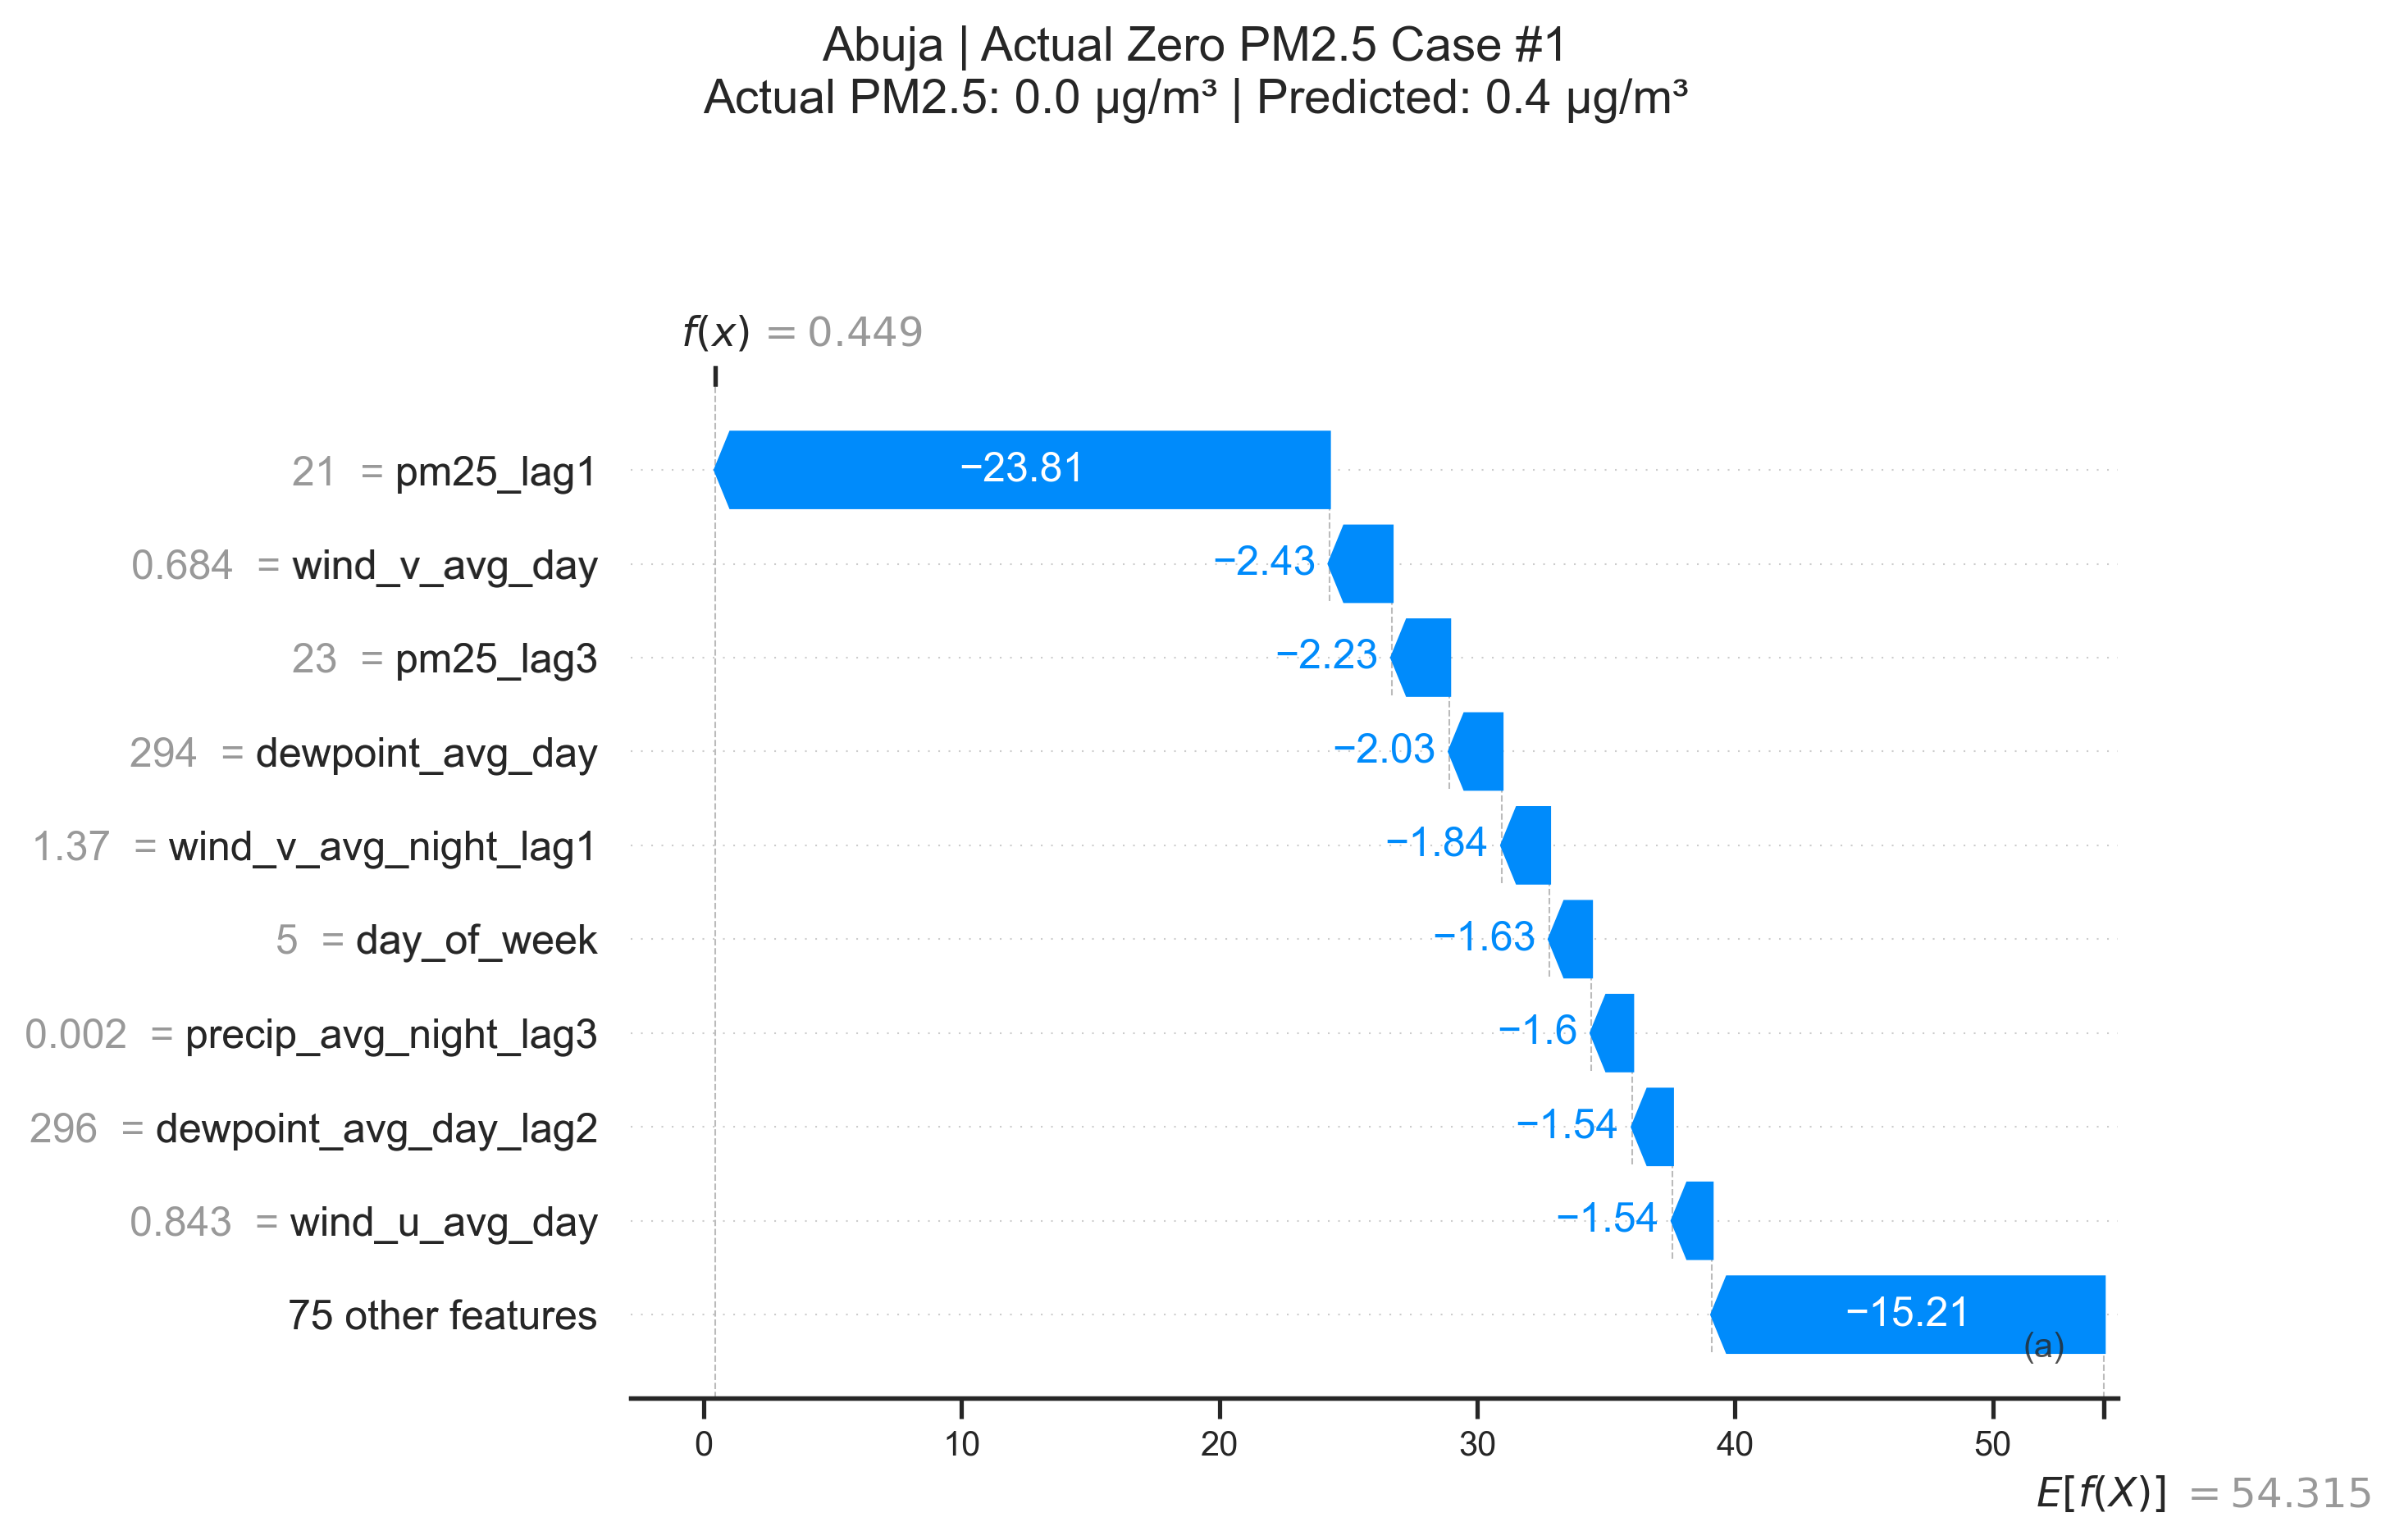

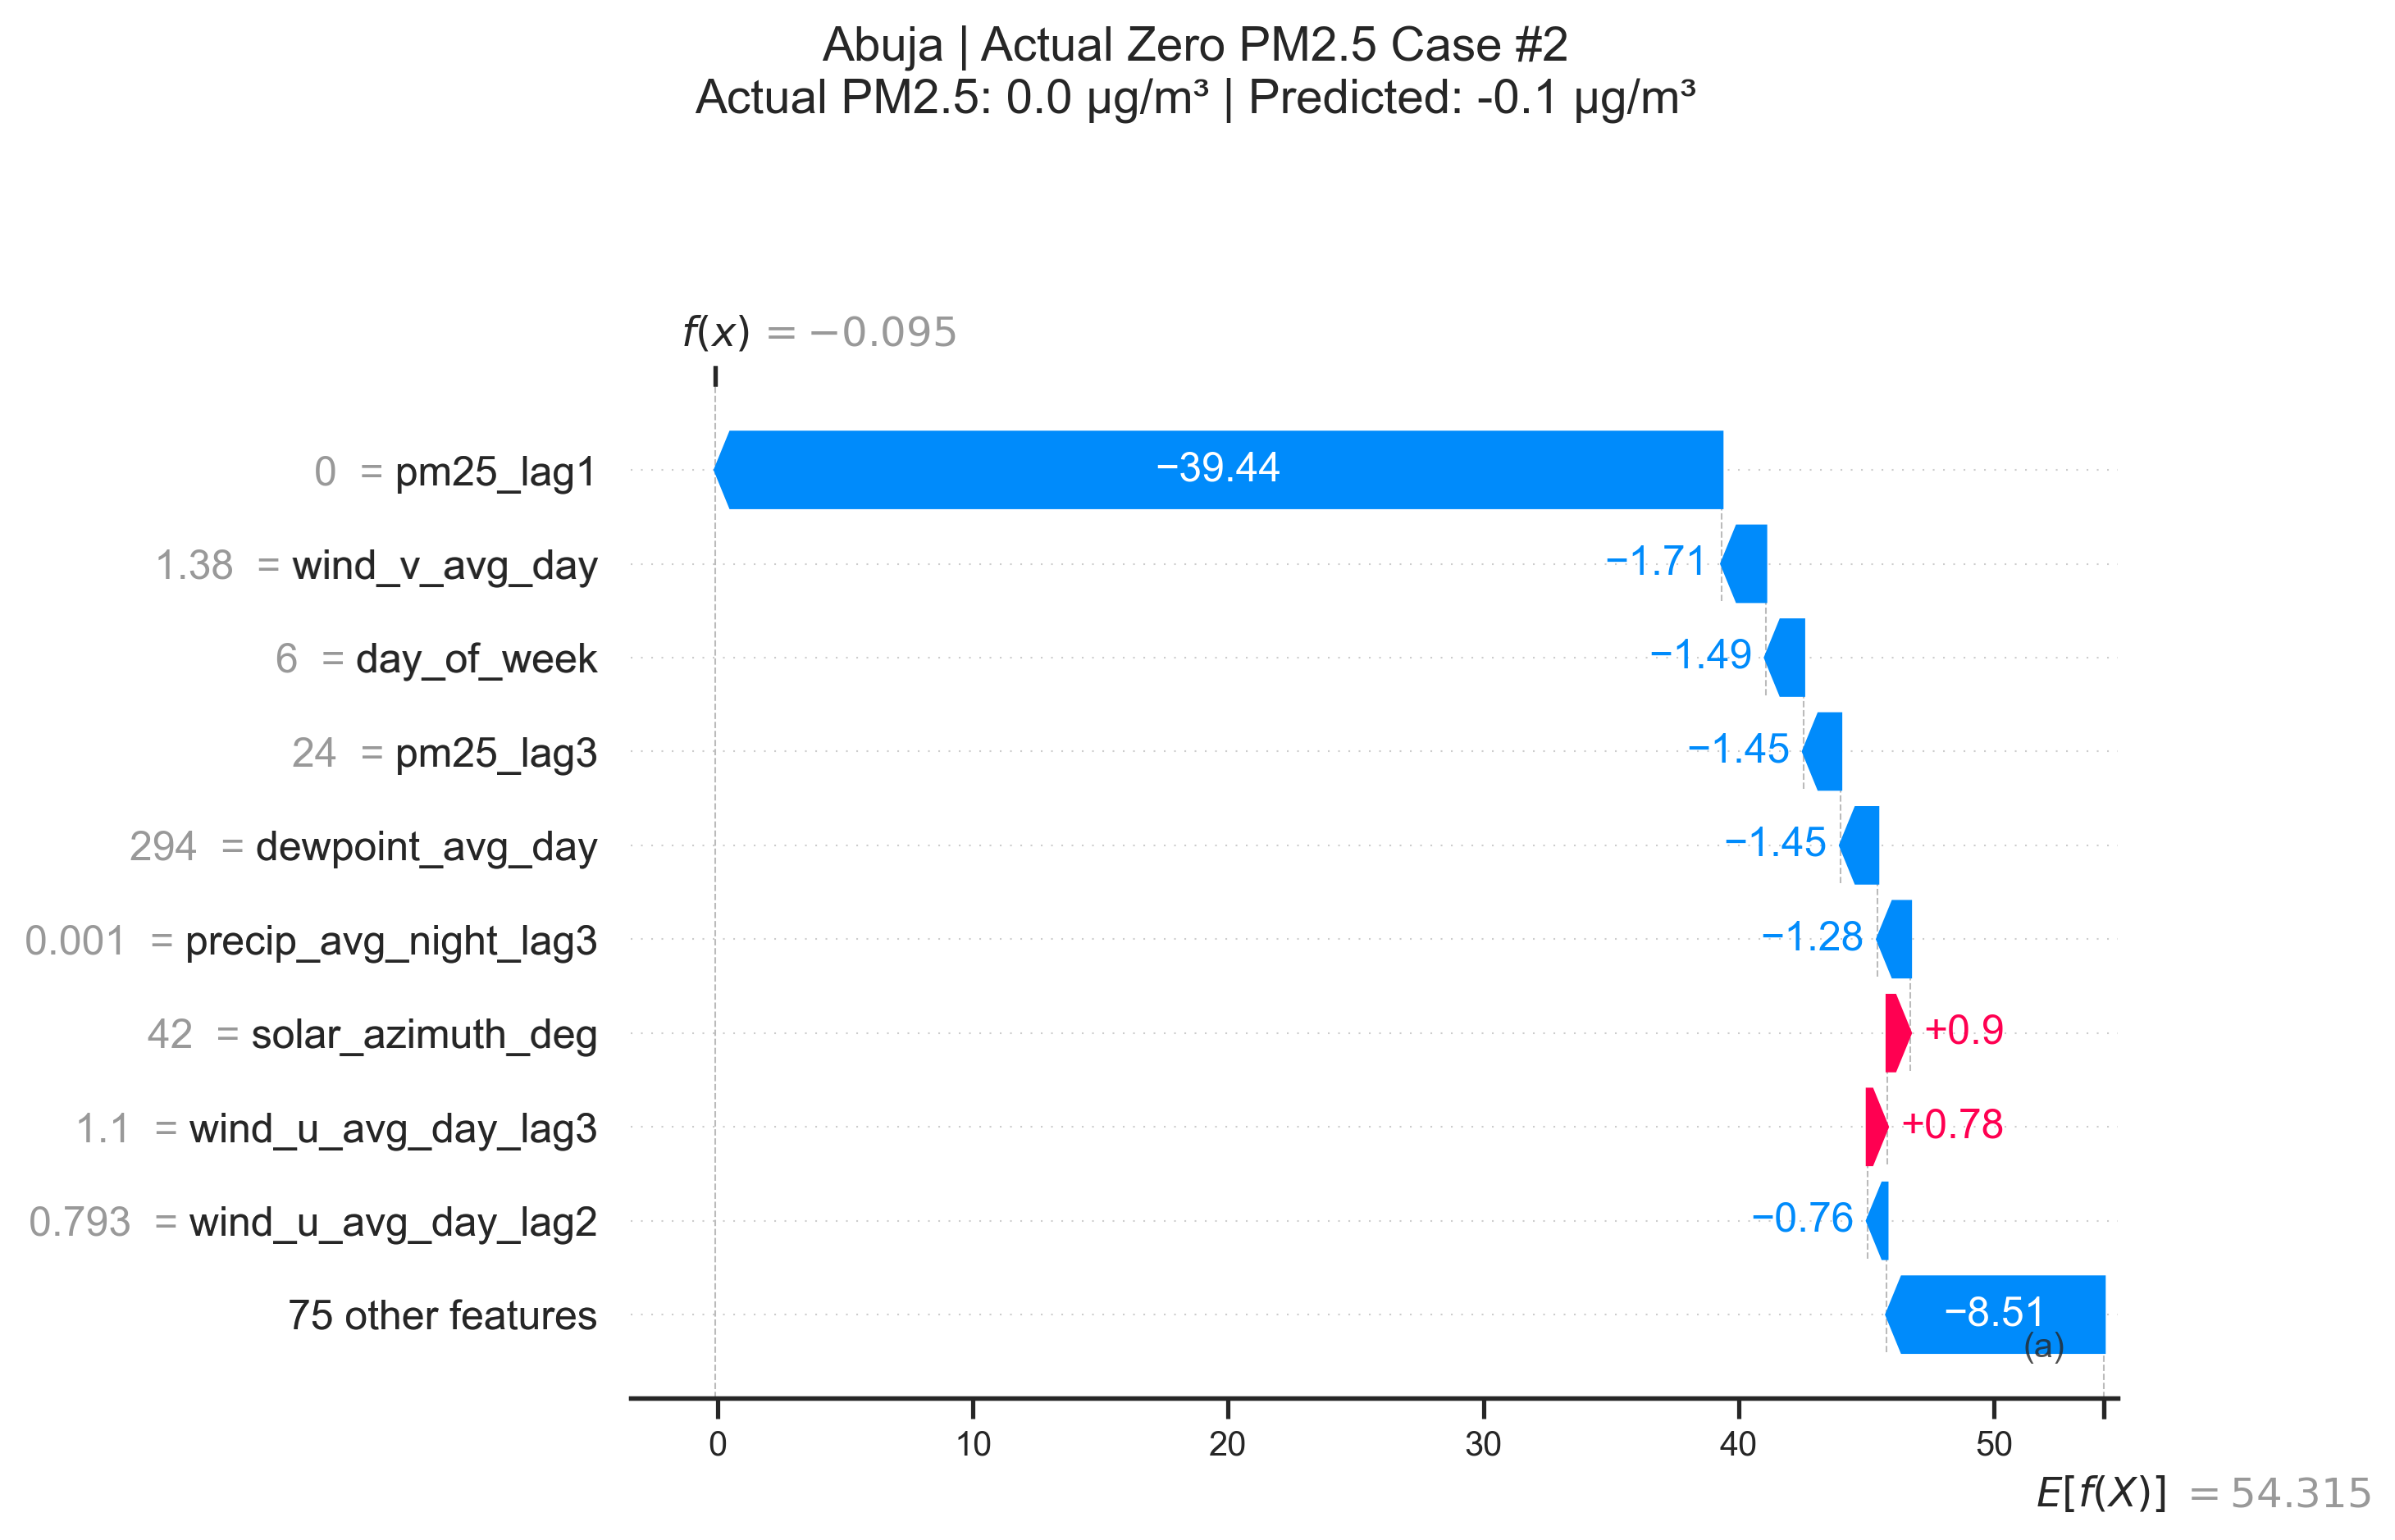

Chennai: No days with actual PM2.5 = 0
New Delhi: No days with actual PM2.5 = 0


In [141]:
def get_all_actual_zero_days(features, true_values, predictions):
    """Get all data for days with actual PM2.5 = 0."""
    is_zero_actual = true_values == 0
    if not is_zero_actual.any():
        return None, None, None

    selected_indices = np.where(is_zero_actual)[0]
    return (
        features.iloc[selected_indices],
        true_values.iloc[selected_indices],
        predictions[selected_indices]
    )

def analyze_actual_zero_days(city_name, pollution_model, training_features, true_pollution_values):
    predicted_pollution = pollution_model.predict(training_features)

    zero_features, zero_actuals, zero_preds = get_all_actual_zero_days(
        training_features, true_pollution_values, predicted_pollution
    )

    if zero_features is None:
        print(f"{city_name}: No days with actual PM2.5 = 0")
        return

    print(f"{city_name}: Found {len(zero_features)} actual zero PM2.5 days.")

    explainer = skexplain.ExplainToolkit(
        estimators=[(city_name, pollution_model)],
        X=zero_features,
        y=zero_actuals,
        feature_names=training_features.columns.tolist()
    )

    shap_config = {
        "masker": shap.maskers.Partition(training_features, max_samples=100, clustering="correlation"),
        "algorithm": "auto"
    }

    explanation_data = explainer.local_attributions(method=["shap"], shap_kws=shap_config)
    shap_values_key = f"shap_values__{city_name}"
    baseline_key = f"shap_bias__{city_name}"

    for case_idx in range(len(zero_features)):
        case_explanation = xr.Dataset(
            {
                shap_values_key: (["cases", "features"], [explanation_data[shap_values_key][case_idx].values]),
                baseline_key: (["cases"], [explanation_data[baseline_key][case_idx].item()]),
                "X": (["cases", "features"], [zero_features.iloc[case_idx].values])
            },
            coords={"cases": [0], "features": training_features.columns.tolist()},
            attrs=explanation_data.attrs
        )

        fig, _ = explainer.plot_contributions(
            contrib=case_explanation,
            estimator_names=city_name,
            features=training_features.columns.tolist(),
            show_baseline=True,
            figsize=(10, 6)
        )

        plt.suptitle(
            f"{city_name} | Actual Zero PM2.5 Case #{case_idx+1}\n"
            f"Actual PM2.5: 0.0 µg/m³ | Predicted: {zero_preds[case_idx]:.1f} µg/m³",
            y=1.05,
            fontsize=14
        )
        plt.tight_layout()
        plt.show()

def analyze_all_actual_zero_days(city_models, city_training_data):
    """Run actual-zero-day analysis for all cities."""
    for city_name, model in city_models.items():
        analyze_actual_zero_days(
            city_name,
            model,
            city_training_data[city_name]["X_train"],
            city_training_data[city_name]["y_train"]
        )

# 🔧 Execute it
analyze_all_actual_zero_days(final_models, city_data)

Global Explainability

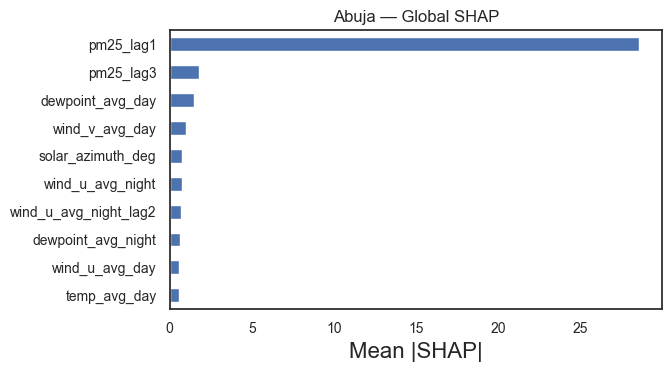

[Abuja] Top-10 global SHAP saved Datasets/explain/Abuja_GLOBAL_SHAP_train.csv


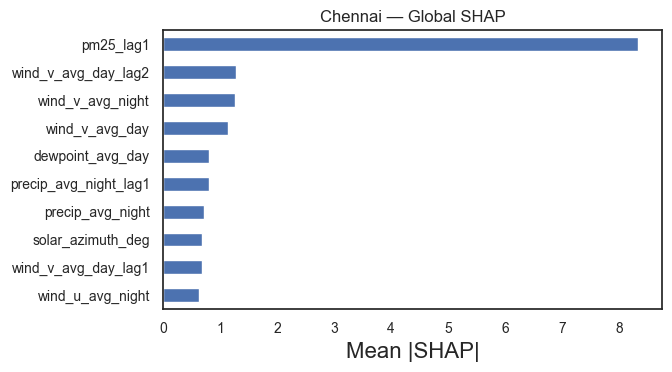

[Chennai] Top-10 global SHAP saved Datasets/explain/Chennai_GLOBAL_SHAP_train.csv


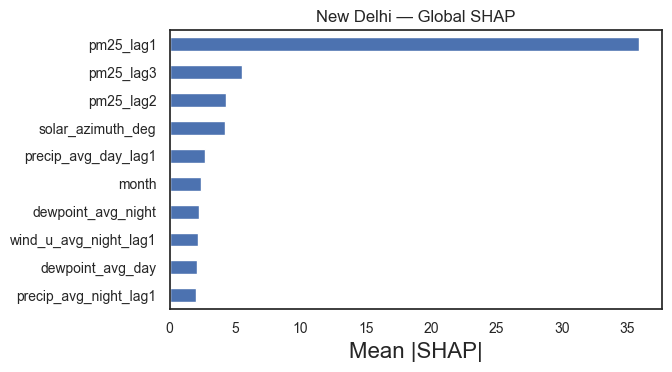

[New Delhi] Top-10 global SHAP saved Datasets/explain/New Delhi_GLOBAL_SHAP_train.csv


In [142]:
# ---------------- GLOBAL  SHAP  (TRAIN SPLIT) -----------------
import os, numpy as np, pandas as pd, shap, matplotlib.pyplot as plt

os.makedirs("Datasets/explain", exist_ok=True)

def global_shap_mean_abs(model, X):
    """
    Compute global importance as the mean absolute SHAP value per feature.
    Works for any tree-based model compatible with shap.TreeExplainer.
    """
    # TreeExplainer with 'tree_path_dependent' = fastest + exact for XGBoost
    explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
    sv = explainer.shap_values(X)           # shape (n_rows, n_features)
    return pd.Series(np.abs(sv).mean(axis=0),  # mean|SHAP|
                     index=X.columns).sort_values(ascending=False)

def plot_top_bar(series, title, top=10, figsize=(7,4), path=None):
    """Simple horizontal bar plot of the top-k importance scores."""
    s = series.head(top)[::-1]
    ax = s.plot(kind="barh", figsize=figsize)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Mean |SHAP|")
    plt.tight_layout()
    if path: plt.savefig(path, dpi=200, bbox_inches="tight")
    plt.show()
global_shap_train = {}

for city in final_models.keys():
    #  valid training rows (same mask as fit)
    y_train = city_data[city]["y_train"]
    X_train = city_data[city]["X_train"]
    mask = y_train.notna().values & np.isfinite(y_train.values)
    X_tr = X_train.iloc[mask]

    #  compute global SHAP
    g_shap = global_shap_mean_abs(final_models[city], X_tr)

    global_shap_train[city] = g_shap   

    # save & plot
    csv_path  = f"Datasets/explain/{city}_GLOBAL_SHAP_train.csv"
    g_shap.to_csv(csv_path)
    plot_top_bar(g_shap,
                 title=f"{city} — Global SHAP",
                 top=10)

    print(f"[{city}] Top-10 global SHAP saved", csv_path)


### Feature-effect curves

PyALE._ALE_generic:INFO: Continuous feature detected.


Abuja: ALE for ['pm25_lag1', 'pm25_lag3', 'dewpoint_avg_day', 'wind_v_avg_day', 'solar_azimuth_deg', 'wind_u_avg_night']


PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


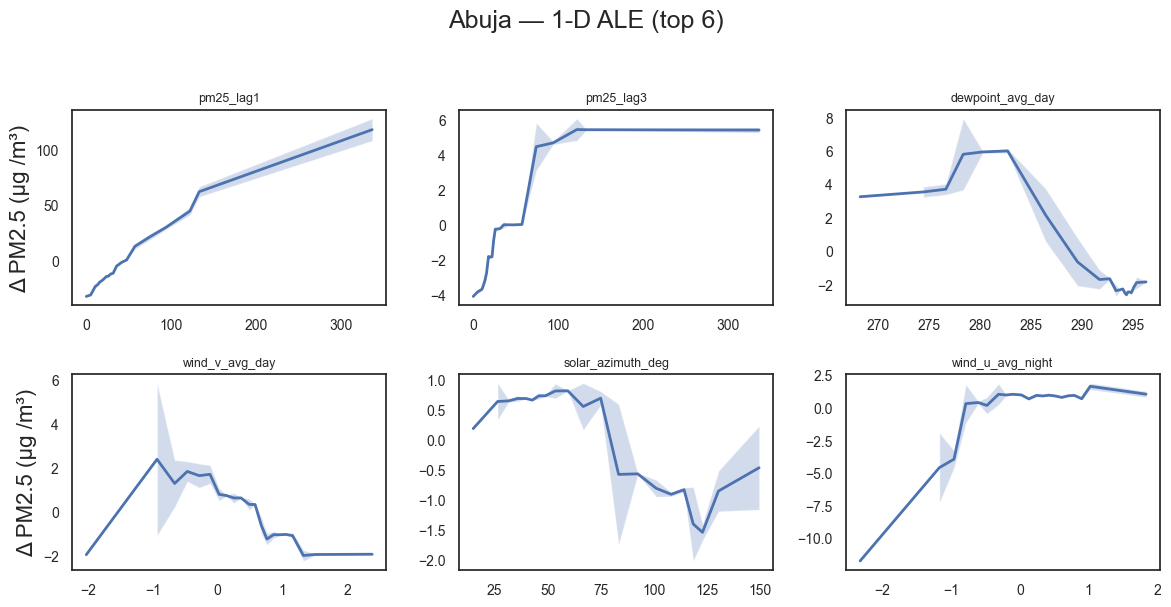

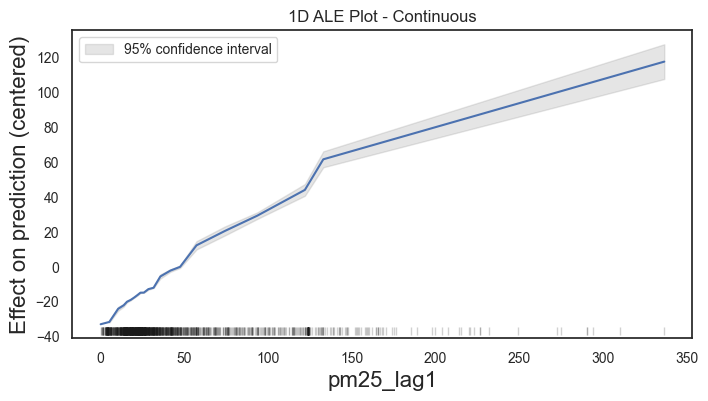

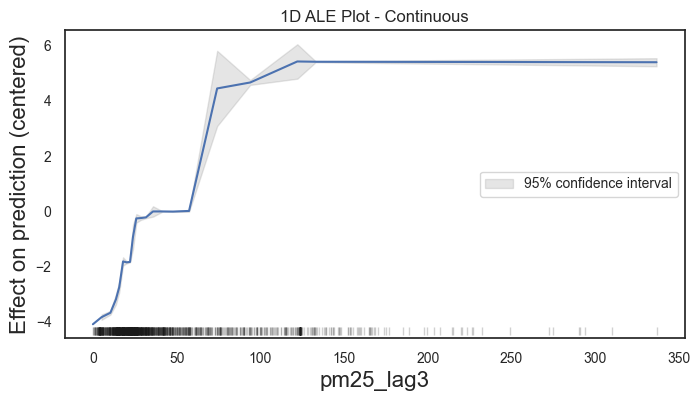

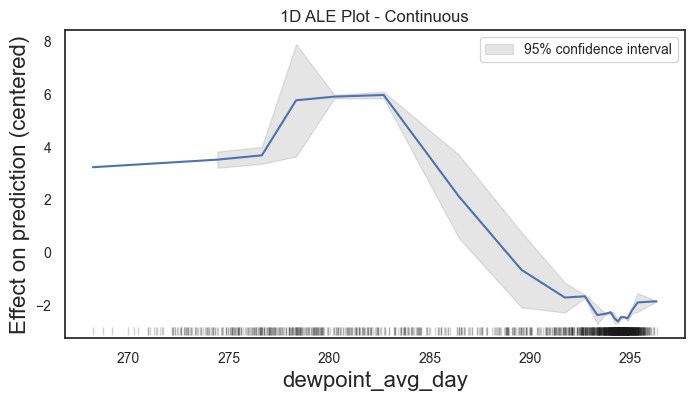

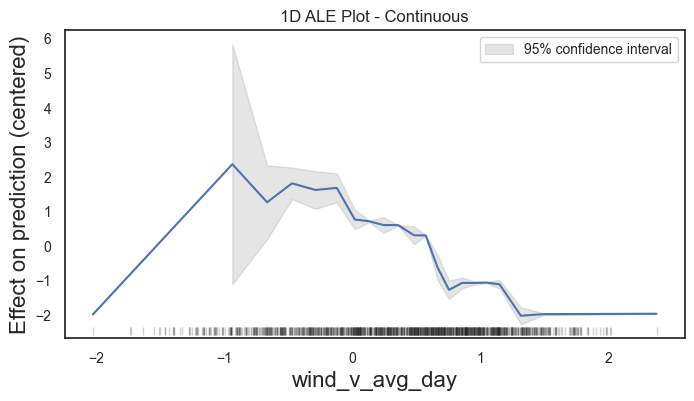

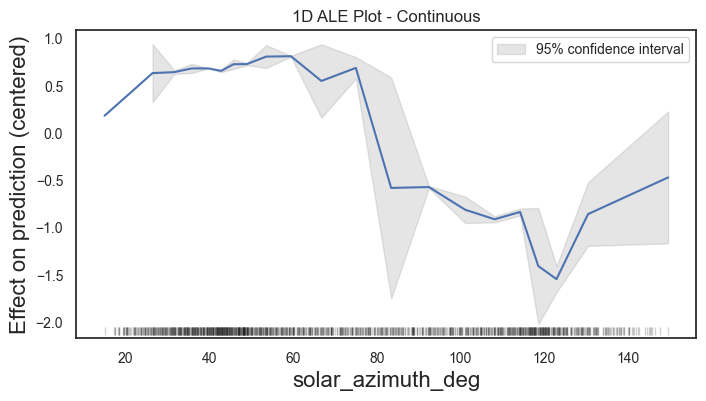

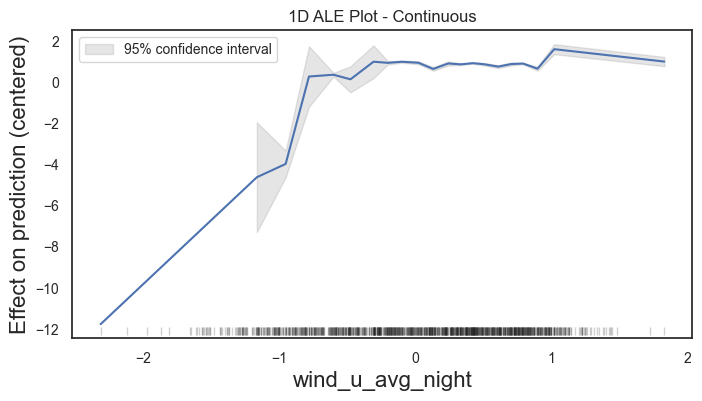

PyALE._ALE_generic:INFO: Continuous feature detected.


✔ Figures/ALE_Abuja.png
Chennai: ALE for ['pm25_lag1', 'wind_v_avg_day_lag2', 'wind_v_avg_night', 'wind_v_avg_day', 'dewpoint_avg_day', 'precip_avg_night_lag1']


PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


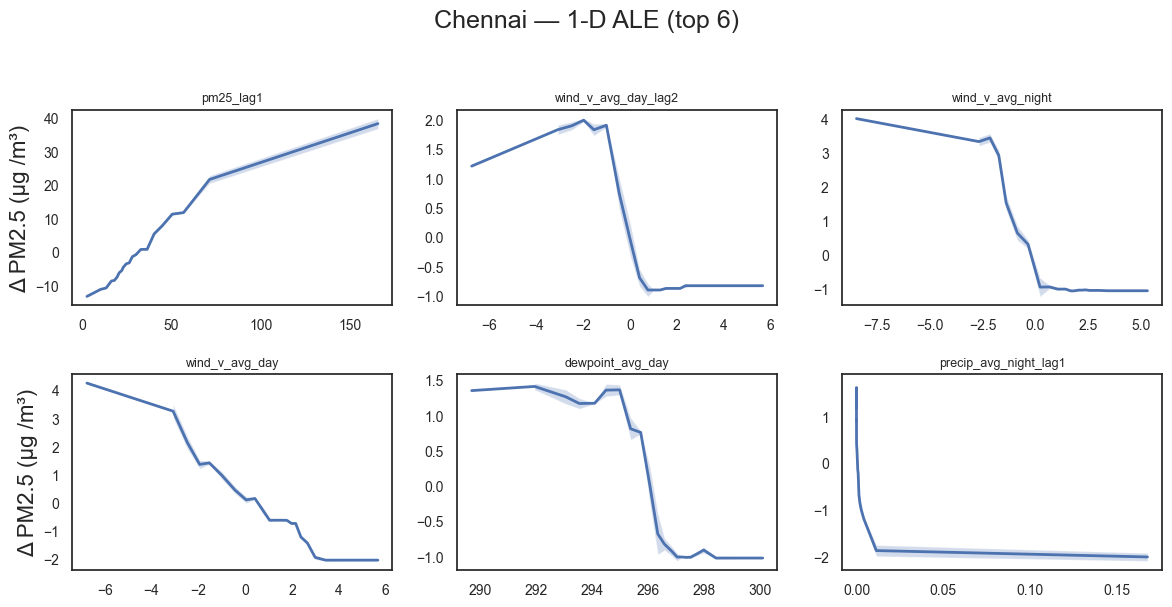

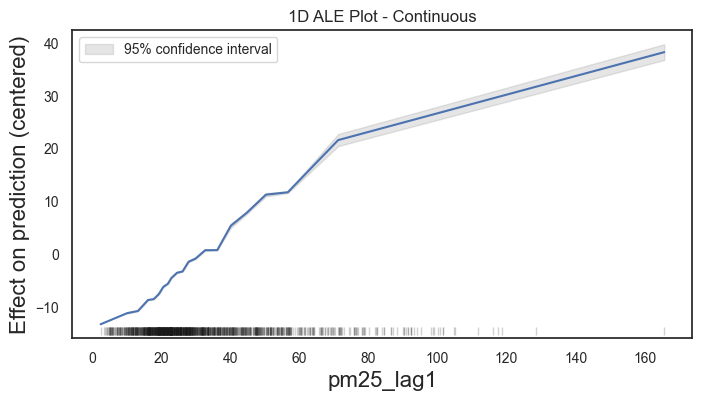

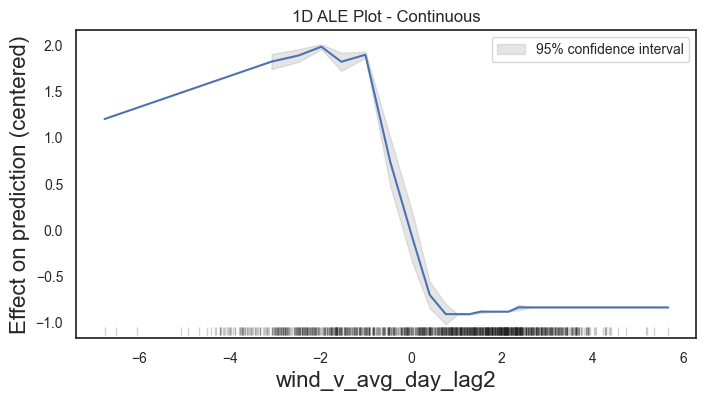

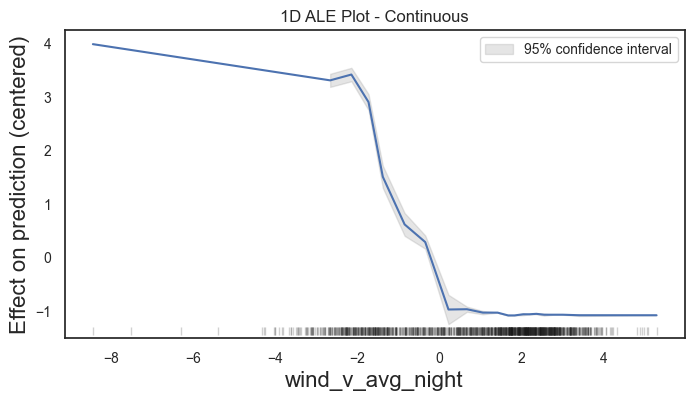

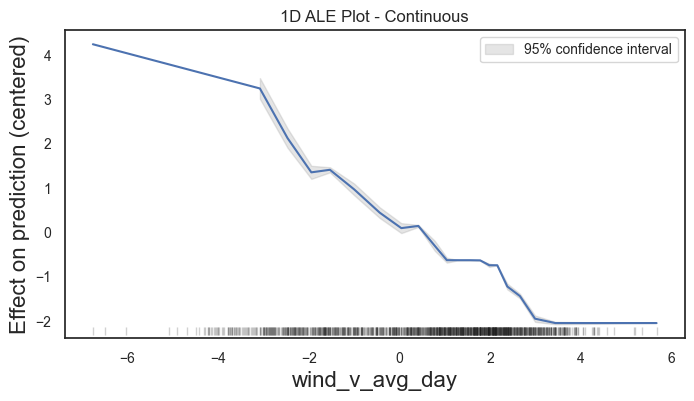

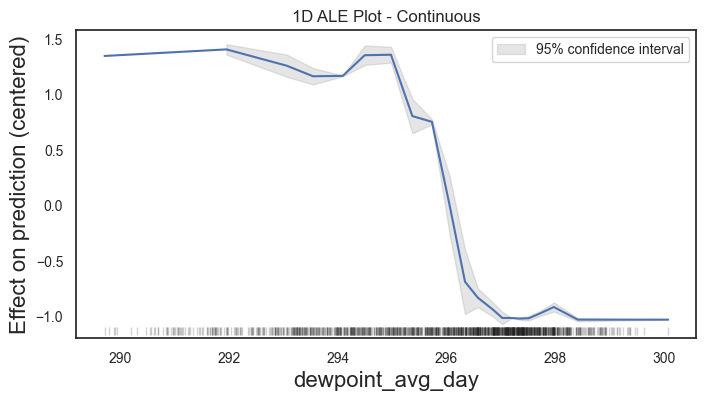

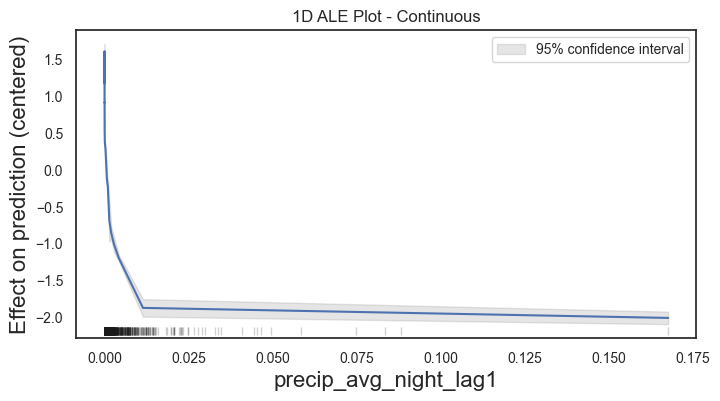

PyALE._ALE_generic:INFO: Continuous feature detected.


✔ Figures/ALE_Chennai.png
New Delhi: ALE for ['pm25_lag1', 'pm25_lag3', 'pm25_lag2', 'solar_azimuth_deg', 'precip_avg_day_lag1', 'month']


PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


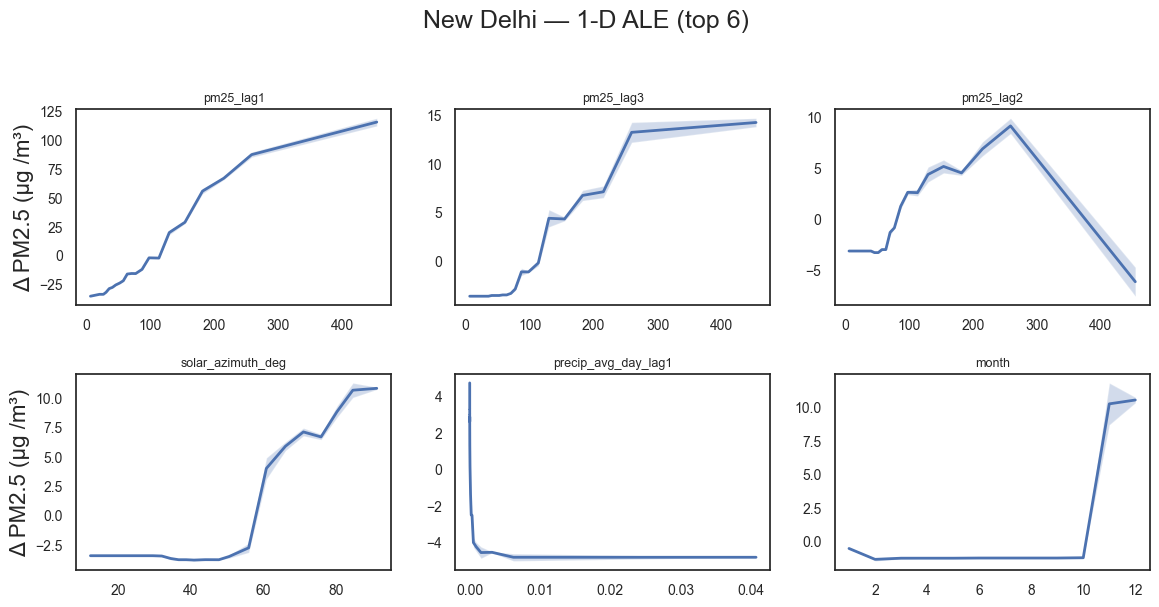

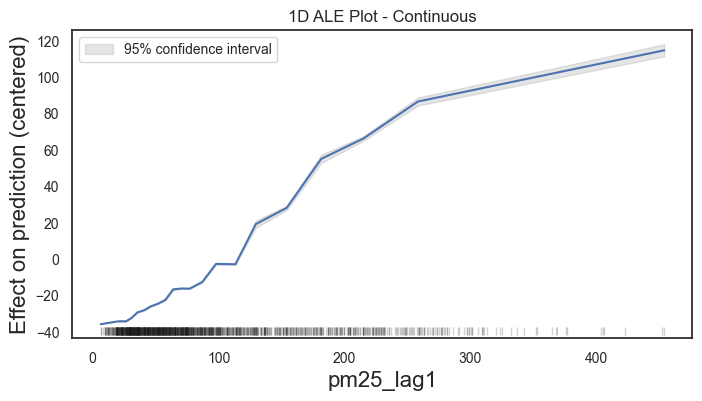

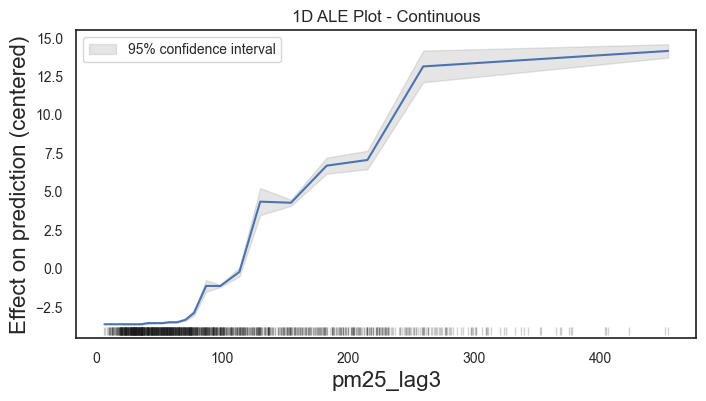

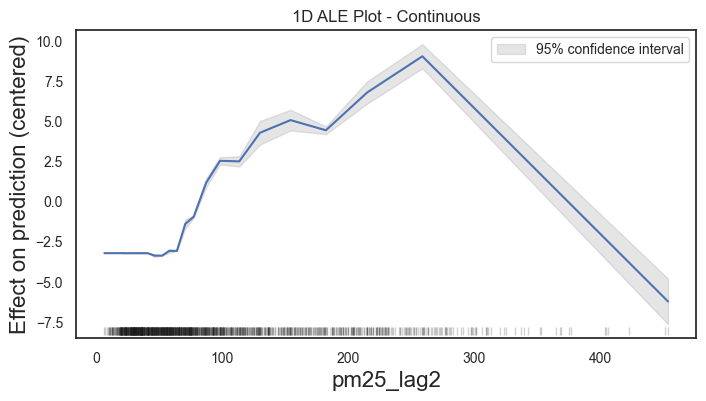

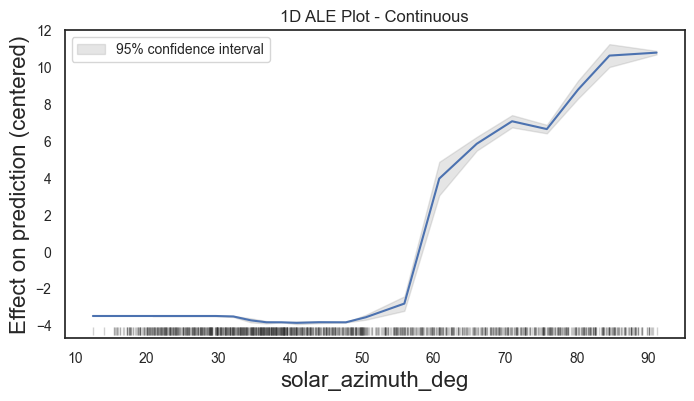

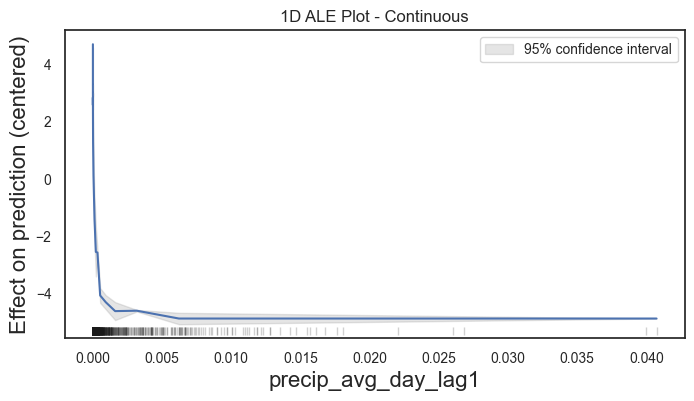

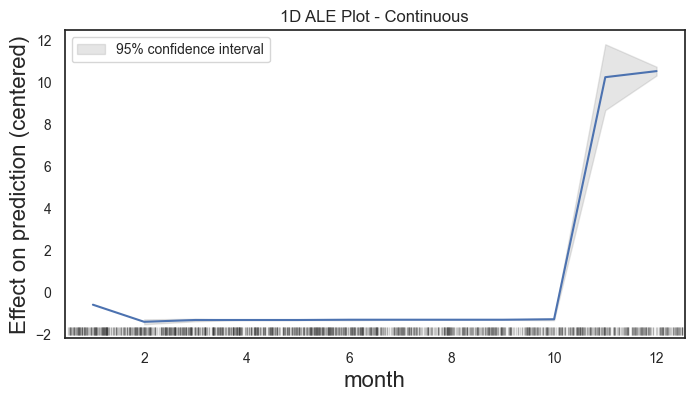

✔ Figures/ALE_New Delhi.png


In [143]:
from PyALE import ale          # Windows wheel name

class DFtoNumpyModel:
    def __init__(self, xgb): self.xgb = xgb
    def predict(self, X):          # X is a DataFrame
        return self.xgb.predict(X.to_numpy())

def plot_ale(city, model, X, feats, grid=20, save="Figures"):
    import os, matplotlib.pyplot as plt ; os.makedirs(save, exist_ok=True)
    wrap = DFtoNumpyModel(model)

    r, c = 2, 3
    fig, axes = plt.subplots(r, c, figsize=(c*4, r*3)); axes = axes.ravel()

    for i, (ax, f) in enumerate(zip(axes, feats)):
        res = ale(X, wrap, [f], grid_size=grid, include_CI=True, C=0.95)

        # x-axis: index for PyALE≥1.2, else column fallback
        x = res.index if not res.index.name is None else \
            (res['x_values'] if 'x_values' in res else res.iloc[:,0])

        y = res['eff']          if 'eff'           in res else res['ALE_effect']
        lo = res['lowerCI_95%'] if 'lowerCI_95%'  in res else res.get('ALE_ci_low')
        hi = res['upperCI_95%'] if 'upperCI_95%'  in res else res.get('ALE_ci_high')

        ax.plot(x, y, lw=2)
        if lo is not None and hi is not None:
            ax.fill_between(x, lo, hi, alpha=.25)

        ax.set_title(f, fontsize=9)
        if i % c == 0: ax.set_ylabel("Δ PM2.5 (µg /m³)")
        ax.set_xlabel("")

    for ax in axes[len(feats):]: ax.axis('off')
    fig.suptitle(f"{city} — 1-D ALE (top {len(feats)})", y=1.02)
    fig.tight_layout()
    out = f"{save}/ALE_{city}.png"
    fig.savefig(out, dpi=250); plt.show(); print("✔", out)

# ─── drive it ──────────────────────────────────────────────────────
TOPK = 6
for city, xgb in final_models.items():
    good = city_data[city]["y_train"].notna()
    Xtr  = city_data[city]["X_train"].loc[good]
    top  = global_shap_train[city].head(TOPK).index.tolist()
    print(f"{city}: ALE for {top}")
    plot_ale(city, xgb, Xtr, top)
